# CS5100 Foundations of Artificial Intelligence - Final Project
Submission by Kendall Smith 
April 8th, 2020 (Python 3.7)

Welcome to my notebook submission for our final project - Identifying Personal Attacks in Wikipedia Comments!
This project asked students to employ a range of text preprocessing and model types to see which could yield the best "hate speech" detection algorithm.  These models are all trained on an archive of wikipedia comments on "contentious" topics ranging between the years 2001 and 2016, although a majority of the observations begin in 2005.  Text classification is an age old problem, and there are a variety of traditional "statistical" methods used to solve these kinds of problems, but in recent decades, neural network architectures have become very popular and some models are achieving equal if not better predictive capabilities.

This notebook walks through one text classification method, using a combination of word vectorization and embedding (via gensim's Word2Vec library) and training a 1-dimensional convolutional neural network with the Keras API (built on top of Tensorflow).  Compared to many of the statistical methods also attempted, e.g. logistic regression, multinomial naive bayes, and random forest classifier models, and despite the longer training time (~2 hours) of this model, it achieves a very high AUC score of .9998 on training and .9954 on validation.  The final model also reduced overfitting seen in the first iteration of the neural network by weighting the Embedding layer with a matrix of the word vectors generated from gensim.  Regardless there is still likely room for further improvement via exploration with "FeatureUnion" like operations, e.g. concatenating two separate Sequential models into one predictive function, leveraging other features in the dataset, not just the text comments themselves.  However, given time constraints, this model gives a good foundation to improve upon.

![title](final_model_workflow.png)

# Step 0 - Import Python libraries and instantiate methods/classes

You can skip below to Step 1 where the real action begins.  The next few dozen cells are just importing necessary python libraries, and constructing customized methods/functions for building, testing and optimizing the performance of the final model that was chosen.

In [1]:
# supporting librariers
import pandas as pd
import numpy as np
import multiprocessing
import contractions as cons
import matplotlib.pyplot as plt
import seaborn as sns
import time, os, sys, re, string
from tqdm.notebook import tqdm

# sklearn library modules
import sklearn.manifold
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.preprocessing import label_binarize
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import resample

# gensim library modules
import gensim.models.word2vec as w2v

# keras library modules
from keras import backend as K
from keras.callbacks import Callback
from keras.layers import Conv1D, GlobalMaxPooling1D
from keras.layers import Dense, Dropout, Activation
from keras.layers import Embedding
from keras.models import Sequential
from keras.preprocessing import sequence
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.wrappers.scikit_learn import KerasClassifier

# nltk library modules
import nltk
# nltk.download() # <-- run this if you haven't downloaded NLTK library before
from nltk import pos_tag, ne_chunk
from nltk.corpus import stopwords, wordnet
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

# stemmer, lemmetizer and stop word instantiation
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()
stops = stopwords.words('english')

Using TensorFlow backend.


Configures the style for matplotlib and seaborn visualizations below in the notebook.

In [2]:
sns.set_context("notebook")

You only need to run this cell if you have not downloaded the wikipedia annotations and comments files yet.

In [3]:
# download annotated comments and annotations

ANNOTATED_COMMENTS_URL = 'https://ndownloader.figshare.com/files/7554634' 
ANNOTATIONS_URL = 'https://ndownloader.figshare.com/files/7554637' 

def download_file(url, fname):
    urllib.request.urlretrieve(url, fname)

                
## download_file(ANNOTATED_COMMENTS_URL, 'attack_annotated_comments.tsv')
## download_file(ANNOTATIONS_URL, 'attack_annotations.tsv')

Simple method for tokenizing a string of text by expanding contractions and returning only alphabetic characters.

In [4]:
def sentenceToWordlist(raw):
    clean = re.sub("[^a-zA-Z]", " ", raw)
    clean = cons.fix(clean)
    words = clean.split()
    return words

Uses NLTK wordnet to identify the parts of speech POS tagging for each word within a list of tokens.  This is used in the lemmatization process, as lemmatizing works significantly bettter when it knows what POS a given word is.

In [5]:
def identifyPosTag(word):
    tag = pos_tag([word])[0][1][0].upper()
    tag_lookup = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_lookup.get(tag, wordnet.NOUN)

Uses NLTK lemmatizer and the POS tagging method above to return cleaner lemmatized word roots

In [6]:
def lemmatizeTokens(tokens):
    return [lemmatizer.lemmatize(token, identifyPosTag(token)) for token in tokens]

Method that expands contractions in sentences, such as I'd or won't => I would, would not (respectively).  The goal of this is to better standardize the unique tokens in the corpus of words/comments and overall reduce sparseness of word vectors.

In [7]:
def expandContractions(commentArray):
    return [cons.fix(comment) for comment in commentArray]

Custom method for tokenizing documents leveraging NLTK word_tokenizer, and the two functions above to expand contractions and lemmatize string sequences.  Lastly, this tokenizer replaces the default tokenizer in the CountVectorizer() use to train statistical language models - e.g. LogisticRegression(), MultinomialNaiveBayes(), RandomForestClassifier().  This was not used in the final 1-D CNN workflow however.

In [8]:
def customTokenizer(doc):
    expandedContractions = cons.fix(doc)
    punctuationRemoved = expandedContractions.translate(str.maketrans('', '', string.punctuation))
    tokens = word_tokenize(punctuationRemoved)
    lemmatized = lemmatizeTokens(tokens)
    alphas = [token for token in lemmatized if not token.isdigit()] #token not in stops and <- english stops from nltk 
    return alphas

Method to slice TSNE plot into smaller X-axis and Y-axis bounds to investigate Word2Vec embeddings from gensim.  TSNE = T-Stochastic Neighbor Embedding, which is a machine learning algorithm for performing nonlinear dimensionality reduction suited to embedding high dimensional and sparse data, like word vectors, and easily visualizing them in a 2-D (or lower dimensinality) plane.

In [9]:
# credit to Radim Řehůřek for methodology to train and plot TSNE model
# https://radimrehurek.com/gensim/auto_examples/tutorials/run_word2vec.html#sphx-glr-auto-examples-tutorials-run-word2vec-py
def plotTsneRegion(points, x_bounds, y_bounds):
    slice = points[
        (x_bounds[0] <= points.x) &
        (points.x <= x_bounds[1]) &
        (y_bounds[0] <= points.y) &
        (points.y <= y_bounds[1])
    ]
    
    ax = slice.plot.scatter("x", "y", s=35, figsize=(10,8))
    for i, points in slice.iterrows():
        ax.text(points.x + 0.005, points.y + 0.005, points.term, fontsize=11)

Method to obtain best parameter settings from GridSearchCV

In [10]:
def getBestScoreParams(gridSearchObj):
    print("Best score: %0.3f" % gridSearchObj.best_score_)
    print("Best parameters set:")
    best_parameters = gridSearchObj.best_estimator_.get_params()
    for param_name in sorted(best_parameters.keys()):
        print("\t%s: %r" % (param_name, best_parameters[param_name]))

Method to return a preconfigured CNN model for binary classification.  The model has a simple Embedding layer (not weighted yet), a 1D convnet, global max pooling, and a hidden dense layer, with a dropout of 20% after each layer.  Finally the classification is made with a sigmoidal function.

In [11]:
def buildCnnModel():
    K.clear_session()
    model = Sequential()
    model.add(Embedding(input_dim=1000, 
                        output_dim=64))
    model.add(Dropout(0.2))
    model.add(Conv1D(filters=250, kernel_size=3, padding='valid', activation='relu', strides=1))
    model.add(GlobalMaxPooling1D())
    model.add(Dense(250))
    model.add(Dropout(0.2))
    model.add(Activation('relu'))
    model.add(Dense(1))
    model.add(Activation('sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    print(model.summary())
    return model

Constructing a class for the word embedded CNN.  I had difficulty getting it to work in the final implementation, as this was to be used in a sklearn Pipeline construct leveraging sklearn's CountVectorizer() and TfidfTransformer().  But there was a dimensionality conflict that wasn't resolved, so the solution was to just use Keras built-in tokenizing and sequence padding functionality.

In [12]:
class WordEmbeddedCnn():
    def __init__(self, vocab_size, embedding_dims, hidden_dims, max_len, filters, kernel_size, loss, optimizer, metrics): # x_train, x_test, y_train, y_test, 
        self.vocab_size = vocab_size
        self.embedding_dims = embedding_dims
        self.hidden_dims = hidden_dims
        self.max_len = max_len
        self.filters = filters
        self.kernel_size = kernel_size
#         self.x_train = x_train
#         self.x_test = x_test
#         self.y_train = y_train
#         self.y_test = y_test
        self.loss = loss
        self.optimizer = optimizer
        self.metrics = metrics
        self.model = None
        
    def buildSequential(self):
        self.model = Sequential()
        self.model.add(Embedding(input_dim=self.vocab_size, 
                                output_dim=self.embedding_dims, 
                                input_length=self.max_len))
        self.model.add(Dropout(0.2))
        self.model.add(Conv1D(self.filters, self.kernel_size, padding='valid', activation='relu', strides=1))
        self.model.add(GlobalMaxPooling1D())
        self.model.add(Dense(self.hidden_dims))
        self.model.add(Dropout(0.2))
        self.model.add(Activation('relu'))
        self.model.add(Dense(1))
        self.model.add(Activation('sigmoid'))
        
    def compileModel(self):
        self.clearSession()
        self.buildSequential()
        self.model.compile(loss=self.loss, optimizer=self.optimizer, metrics=self.metrics)
        print(self.model.summary())
        return self.model
    
    def clearSession(self):
        K.clear_session()

The Keras team built this custom class object to modify the default callback functionality within the model training/fitting step to yield ROC AUC metrics after each epoch.  This enabled me to create an ROC AUC curve in evaluating model performance to align with the statistical models attempted.

In [13]:
# credit to jamartinh
# https://github.com/keras-team/keras/issues/3230#issuecomment-319208366

class RocCallback(Callback):
    def __init__(self,training_data,validation_data):
        self.x = training_data[0]
        self.y = training_data[1]
        self.x_val = validation_data[0]
        self.y_val = validation_data[1]


    def on_train_begin(self, logs={}):
        return

    def on_train_end(self, logs={}):
        return

    def on_epoch_begin(self, epoch, logs={}):
        return

    def on_epoch_end(self, epoch, logs={}):
        y_pred_train = self.model.predict_proba(self.x)
        roc_train = roc_auc_score(self.y, y_pred_train)
        y_pred_val = self.model.predict_proba(self.x_val)
        roc_val = roc_auc_score(self.y_val, y_pred_val)
        print('\rroc-auc_train: %s - roc-auc_val: %s' % (str(round(roc_train,4)),str(round(roc_val,4))),end=100*' '+'\n')
        return

    def on_batch_begin(self, batch, logs={}):
        return

    def on_batch_end(self, batch, logs={}):
        return

Method to plot ROC AUC curve in evaluating model performance.

In [14]:
def plotRocCurve(name, tpr, fpr, auc):
    fig = plt.figure(figsize=(12, 8))
    plt.rc('font', size=8)
    plt.plot(fpr, tpr, label=f'{name}, AUC={auc}')
    plt.plot([0, 1], [0, 1], color='purple', linestyle='--')
    plt.xlabel('\nFalse Positive Rate')
    plt.ylabel('True Positive Rate\n')
    plt.title('Receiver Operating Characteristic (ROC) Curve\n')
    plt.legend(prop={'size':13}, loc='lower right')
    plt.show()

Method to plot Precision Recall curve in evaluating model performance.

In [15]:
def plotPrecisionRecallCurve(name, lr_precision, lr_recall, f1_score):
    fig = plt.figure(figsize=(5, 5))
    plt.rc('font', size=8)
    plt.plot(lr_recall, lr_precision, marker='.', label=f'{name}, F1={f1}')
    plt.title(f'Precision Recall Curve for {name}\n')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend(prop={'size':13}, loc='lower right')
    plt.show()

Method to plot confusion matrix in evaluating model performance.

In [16]:
def confusionMatrix(name, y_test, y_preds):
    cm = confusion_matrix(y_test, y_preds)
    sns.heatmap(cm, square=True, annot=True, cmap='BuPu', cbar=False,
    xticklabels=['Attack', 'Not Attack'], yticklabels=['Attack', 'Not Attack'], fmt="d")
    plt.title(f'\n Confusion Matrix for {name}\n')
    plt.xlabel('\nActual Classification')
    plt.ylabel('Predicted Classification\n')
    plt.show()

Method that yields a binary output instead of probabilistic output from model.  Yes, I know this is the same as running model.predict() instead of mode.predict_proba(), but alas, this is faster than running the prediction again.

In [17]:
def getBinaryPredFromProba(y_pred_proba):
    y_hat = []
    for item in y_pred_proba:
        if item >= 0.5:
            y_hat.append(True)
        else:
            y_hat.append(False)
    return y_hat

Method to plot the CNN model's accuracy and loss curves in evaluating model performance.

In [18]:
# credit to nikolai janakiev
# https://realpython.com/python-keras-text-classification/
def plotModelHistory(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.rc('font', size=8)
    
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

In [19]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Kendall\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Kendall\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# Step 1 - Import and merge annotations and comments data

First we need to fetch the data from the downloaded files.

In [23]:
comments = pd.read_csv('attack_annotated_comments.tsv', sep = '\t', index_col = 0)
annotations = pd.read_csv('attack_annotations.tsv',  sep = '\t')

We can remove some common prefixes that appear in all of the comments provided.

In [24]:
# remove newline and tab tokens
comments['comment'] = comments['comment'].apply(lambda x: x.replace("NEWLINE_TOKEN", " "))
comments['comment'] = comments['comment'].apply(lambda x: x.replace("TAB_TOKEN", " "))

In order to stay consistent in evaluating performance with the "strawman" method provided to us (below for comparison), I decided to keep the definition of an attack set to > 50%, in other words more than half of the annotators needed to state that something was an attack, which yields a greater than average, or simple minority, classification of attacks.  Other approaches that weren't explored were 1) if any annotators flagged as attack, or sliding 0.5 closer to 1.0, or 100% of annotators flagging as an attack.  Also the other attack type fields were not used in the analysis.  Given time constraints, this is one area I would have explored to further tweak a little more efficiency and accuracy out of the CNN model.

In [25]:
# labels a comment as an atack if the majority of annoatators did so
labels = annotations.groupby('rev_id')['attack'].mean() > 0.5

Merging the attack classification labels as a new column in the comments dataframe, joining on index.

In [26]:
# join labels and comments
comments['attack'] = labels

Here is the "strawman" method provided to us with LogisticRegression(), and the baseline for model performance used in evaluating my model later on.

In [301]:
# fit a simple text classifier
train_comments = comments.query("split=='train'")
test_comments = comments.query("split=='test'")

clf = Pipeline([
    ('vect', CountVectorizer(max_features = 10000, ngram_range = (1,2))),
    ('tfidf', TfidfTransformer(norm = 'l2')),
    ('clf', LogisticRegression()),
])

clf = clf.fit(train_comments['comment'], train_comments['attack'])

auc = roc_auc_score(test_comments['attack'], clf.predict_proba(test_comments['comment'])[:, 1])
print('Test ROC AUC: %.3f' %auc)

Test ROC AUC: 0.957


In [327]:
f1 = f1_score(test_comments['attack'], clf.predict(test_comments['comment']))

In [328]:
print(f'F1 Score Metric: {f1}')

F1 Score Metric: 0.6880941602535083


Per below in Step 2 - Visualize Dataset Distributions, I realized there were large class imbalances (attack==True/False) across all features.  Therefore some type of rebalancing is a recommended approach to getting optimal model results.  This can be achieved either by A) downsizing the majority class (False) or B) upsampling the minority class (True).  I decided to go with the latter approach as this would create more data to train the neural network on, instead of reducing the volume of available data to train with. Also in downsampling, there is a risk of creating further imbalance across features.

In [27]:
minority_class = comments[comments['attack']==True].copy()
majority_class = comments[comments['attack']==False].copy()

upsampled_minority = resample(minority_class, 
                                 replace=True,     # sample with replacement
                                 n_samples=len(majority_class),    # upsample to match majority class
                                 random_state=123) # reproducible results

new_comments = pd.concat([upsampled_minority, majority_class])

In comparison to the "strawman" approach, I also wanted to use sklearn's train_test_split methodology for generating train and test groups, instead of using the ['split'] column provided in the dataset.  As can be seen below, this feature was grossly imbalanced as well.  Using this method ensured there wasn't any overfitting in the model by using a feature predesignated as a 'train' set and a 'test' set.  Another way to account for imbalanced classes is using the stratify paramter of the train_test_split object, but I didn't run a model with this set to specific features.

In [29]:
X = new_comments['comment'].values
y = new_comments['attack'].values

In [338]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42, shuffle=True)

In [339]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(163638,)
(40910,)
(163638,)
(40910,)


# Step 2 - Visualize Dataset Distributions

An essential step in any data science workflow, and in understanding the data being used in a predictive machine learning model, is to visualize the data set so that any imbalances, or skew is occuring that might affect the outcome of the model.  Skewing in the data can cause the model to train on bad data, the age old saying "garbage in - garbage out" holds true especially in the machine learning domain.

In [298]:
comments_grouped = comments.groupby(['logged_in','ns','sample','split','year','attack']).agg({'attack': 'size'})
comments_grouped.rename(columns={'attack': 'attack_count'}, inplace=True)
comments_grouped.sort_values(by=['attack','attack_count'], ascending=False)

attack_count
logged_in ns      sample  split year attack              
False     user    blocked train 2008 True             658
                                2009 True             479
                                2006 True             470
                                2007 True             457
True      user    blocked train 2008 True             445
...                                                   ...
False     user    random  dev   2003 False              1
                                2016 False              1
                          train 2002 False              1
True      article random  dev   2001 False              1
          user    blocked train 2003 False              1

[582 rows x 1 columns]

In [299]:
new_comments_grouped = new_comments.groupby(['logged_in','ns','sample','split','year','attack']).agg({'attack': 'size'})
new_comments_grouped.rename(columns={'attack': 'attack_count'}, inplace=True)
new_comments_grouped.sort_values(by=['attack','attack_count'], ascending=False)

attack_count
logged_in ns      sample  split year attack              
False     user    blocked train 2008 True            4901
                                2006 True            3641
                                2009 True            3622
                                2007 True            3349
True      user    blocked train 2008 True            3257
...                                                   ...
False     user    random  dev   2003 False              1
                                2016 False              1
                          train 2002 False              1
True      article random  dev   2001 False              1
          user    blocked train 2003 False              1

[582 rows x 1 columns]

In [278]:
comments_grouped.reset_index(inplace=True)
new_comments_grouped.reset_index(inplace=True)

The first thing to notice about the data is that the classes are not evenly balanced, which might be a consideration for weights in models below. There are over 5 times as many False classes than True classes.  As we can see below, with rebalancing the classes, this is no longer the case.

First observation is a simple count of the number of rows by class, with unbalanced and balanced sets respectively. 

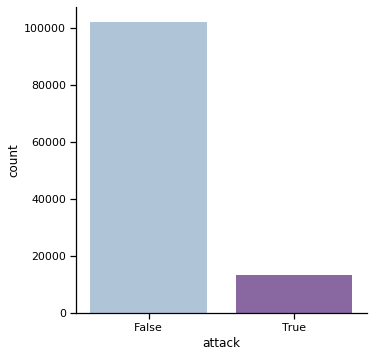

In [269]:
sns.catplot(x="attack", kind="count", palette="BuPu", data=comments)

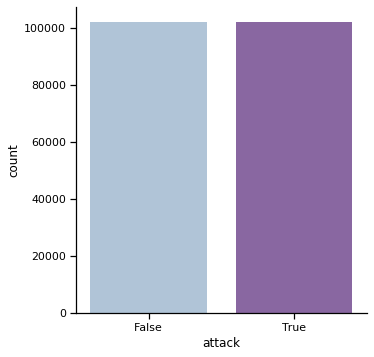

In [302]:
sns.catplot(x="attack", kind="count", palette="BuPu", data=new_comments)
plt.show()

Second observation is looking at breakdown of attack class by the namespace, with unbalanced and balanced sets respectively. 

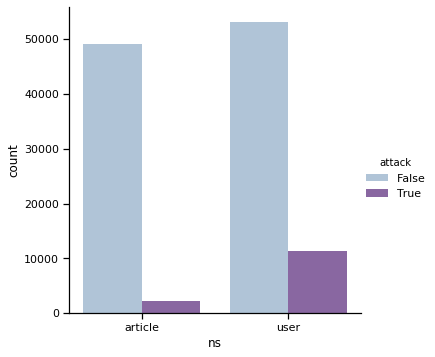

In [290]:
sns.catplot(x="ns", kind="count", hue='attack', palette="BuPu", data=comments)
plt.show()

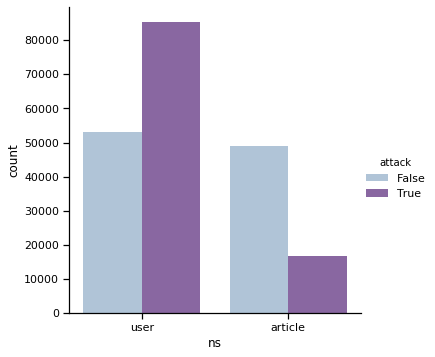

In [291]:
sns.catplot(x="ns", kind="count", hue='attack', palette="BuPu", data=new_comments)
plt.show()

Third observation is looking at breakdown of attack class by the users logged in, with unbalanced and balanced sets respectively. 

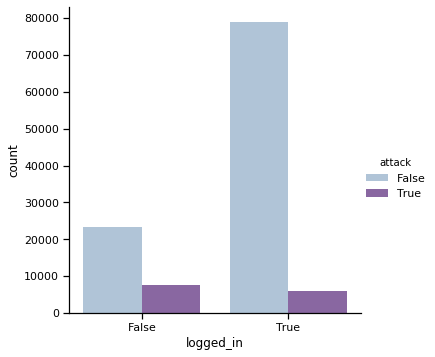

In [292]:
sns.catplot(x="logged_in", kind="count", hue='attack', palette="BuPu", data=comments)
plt.show()

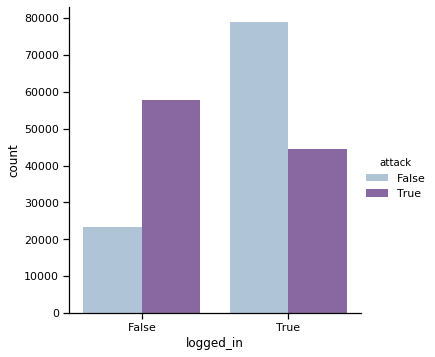

In [293]:
sns.catplot(x="logged_in", kind="count", hue='attack', palette="BuPu", data=new_comments)
plt.show()

Fourth observation is looking at breakdown of attack class by predesignated split, with unbalanced and balanced sets respectively. 

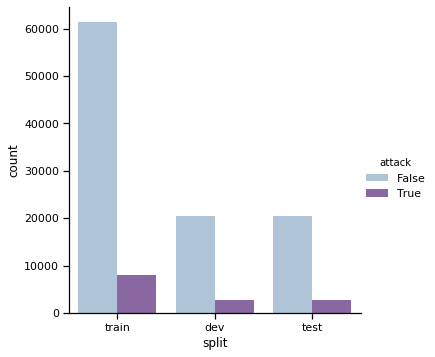

In [294]:
sns.catplot(x="split", kind="count", hue='attack', palette="BuPu", data=comments)
plt.show()

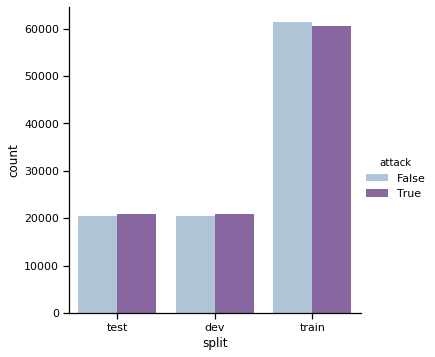

In [295]:
sns.catplot(x="split", kind="count", hue='attack', palette="BuPu", data=new_comments)
plt.show()

Last observation is looking at breakdown of attack class by year the comment was made, with unbalanced and balanced sets respectively. 

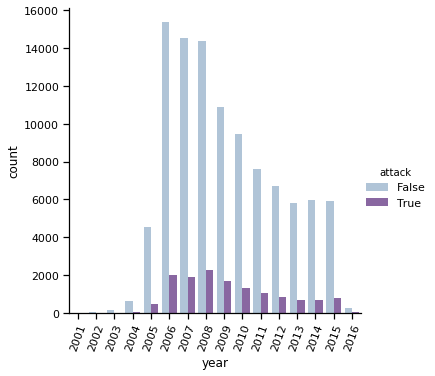

In [296]:
sns.catplot(x="year", kind="count", hue='attack', palette="BuPu", data=comments)
plt.tick_params(axis='x', rotation=70)
plt.show()

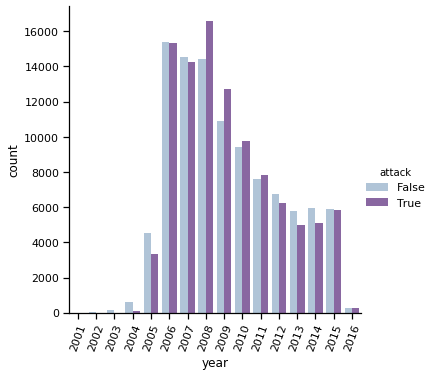

In [297]:
sns.catplot(x="year", kind="count", hue='attack', palette="BuPu", data=new_comments)
plt.tick_params(axis='x', rotation=70)
plt.show()

# Step 3 - Train Word2Vec Model

Next in order to train a convolutional neural network efficiently, I decided to use word embeddings with gensim's Word2Vec module.  Compared to building a model based on sparse word vector counts or one-hot-encoding binary features for each word, which can get unruly in size (i.e. thousands of features), the word embeddings are able to reduce the dimensionality of the model to a predefined set of features, in the case below, set to 300 features.  The lower the features the faster the embedding matrix can be built, but the less accurate, as more words that wouldn't normally be associated are forced to have some kind of relationship (in the vector space).  The setting of 300 features seemed to be a reasonable compromise to 15,000 originally recommend by GridSearchCV on a Logistic Regression model as optimal features in a sparse count vectorizer. The range of words must have at least 3 occurances, the context/distance of words from eachother is set to 7 words, and the most frequently occuring words will be downsampled to 1000.  This all helps the model to train faster while not compromising too much accuracy.  In the end this configuration still took a while to train the Word2Vec model.  Multiprocessing is used to speed the task up.

In [306]:
num_features = 300 # dimensionality, computational expensive but accurate
min_word_count = 3 # smallest set of words we want to recognize
num_workers = multiprocessing.cpu_count()
context_size = 7 # size of blocks of words for context
downsampling = 1e-3 # setting for frequent words
seed = 1 # random number generator (deterministic for debugging)

Import predefined english tokenizer from punkt

In [307]:
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')

Build an array/list of raw tokenized sentences

In [308]:
raw_sentences = []
for i in tqdm(range(len(comments['comment'].values))):
    raw_sentences.append(tokenizer.tokenize(comments['comment'].values[i]))

Merge sublists into a list for each list, in other words, each sentence in a comment is originally appended potentially as multiple sublists.  This will flatten the array structure.

In [309]:
raw_sentences_sequence = [item for sublist in raw_sentences for item in sublist]

Also might need to remove any empty sentences with length of 0

In [310]:
sentences = []
for raw_sentence in tqdm(raw_sentences_sequence):
    if len(raw_sentence) > 0:
        sentences.append(sentenceToWordlist(raw_sentence))

In [311]:
token_count = sum([len(sentence) for sentence in sentences])
print("The corpus contains {0:,} tokens".format(token_count))

The corpus contains 8,182,097 tokens


This defines the Word2Vec model structure, with parameters set to the attributes defined above, such as the number of workers (cpu count), the context window, min count of words required to appear, number of features and downsampling size.

In [312]:
attack_vec = w2v.Word2Vec(
    sg = 1,
    seed = seed,
    workers = num_workers,
    size = num_features,
    min_count = min_word_count,
    window = context_size,
    sample = downsampling
)

In [313]:
t1 = time.time()
attack_vec.build_vocab(sentences)
t2 = time.time()

In [314]:
print(f'Building the vocabulary took {t2-t1} seconds')
print("Word2Vec vocabulary length:", len(attack_vec.wv.vocab))

Building the vocabulary took 12.026078224182129 seconds
Word2Vec vocabulary length: 63196


Now to actually train the Word2Vec model on the corpus of sentences extracted from the comments dataset.

In [315]:
t1 = time.time()
attack_vec.train(
    sentences, 
    total_examples=attack_vec.corpus_count,
    epochs = 10
)
t2 = time.time()

In [316]:
print(f'Training the Word2Vec model on the comment corpus took {(t2-t1)/60} minutes')

Training the Word2Vec model on the comment corpus took 2.238131010532379 minutes


In [ ]:
if not os.path.exists('trained'):
    os.makedirs('trained')

In [ ]:
attack_vec.save(os.path.join('trained', 'attack_vec.w2v'))

# Step 4 - Create Word Embedding Matrix from Word2Vec model

Now that the Word2Vec model has been trained, we need to build a word embedding matrix that can be used weight the Embedding layer of the final 1-D convolutional neural network used to make predictions on if comments are an attack or not.

In [73]:
attack_vec = w2v.Word2Vec.load(os.path.join('trained', 'attack_vec.w2v'))

Here I use the Keras built-in tokenizer instead of using the sklearn or nltk library tokenizers. This allows for easier integration with consecutive steps to convert text to sequences and pad the sequences before training the model.

In [74]:
keras_tokenizer = Tokenizer()
keras_tokenizer.fit_on_texts(X_train)

In [77]:
vocab_size = len(keras_tokenizer.word_index) + 1

Converting the X_train and X_test text sentences to tokenized sequences.

In [75]:
X_train = keras_tokenizer.texts_to_sequences(X_train)
X_test = keras_tokenizer.texts_to_sequences(X_test)

Instantiation of a placeholder matrix for the word embeddings

In [78]:
embedding_matrix = np.zeros((vocab_size, 300))

Now we construct the actual word embedding matrix from the Word2Vec model trained by extracting the word vector values for each word.

In [81]:
for word, i in tqdm(keras_tokenizer.word_index.items()):
    try:
        embedding_vector = attack_vec[word]
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
    except Exception as e:
        print(e)
        pass

C:\Users\Kendall\anaconda3\envs\ai_env\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  This is separate from the ipykernel package so we can avoid doing imports until


"word 'don't' not in vocabulary"
"word 'u' not in vocabulary"
"word 'i'm' not in vocabulary"
"word 'it's' not in vocabulary"
"word 'you're' not in vocabulary"
"word 'can't' not in vocabulary"
"word '2' not in vocabulary"
"word '1' not in vocabulary"
"word 'i've' not in vocabulary"
"word 'that's' not in vocabulary"
"word 'doesn't' not in vocabulary"
"word 'bunksteve' not in vocabulary"
"word 'didn't' not in vocabulary"
"word 'dont' not in vocabulary"
"word 'i'll' not in vocabulary"
"word '3' not in vocabulary"
"word 'bastered' not in vocabulary"
"word 'fggt' not in vocabulary"
"word 'hanibal911you're' not in vocabulary"
"word 'chester' not in vocabulary"
"word 'marcolfuck' not in vocabulary"
"word 'isn't' not in vocabulary"
"word 'ullmann' not in vocabulary"
"word '•' not in vocabulary"
"word 'fack' not in vocabulary"
"word ''fuck' not in vocabulary"
"word 'im' not in vocabulary"
"word '5' not in vocabulary"
"word 'mothjer' not in vocabulary"
"word '0' not in vocabulary"
"word '4' not i

"word 'wasnt' not in vocabulary"
"word '42' not in vocabulary"
"word 'person's' not in vocabulary"
"word 'd3' not in vocabulary"
"word 'everyone's' not in vocabulary"
"word 'zuck' not in vocabulary"
"word '44' not in vocabulary"
"word 'dyk' not in vocabulary"
"word 'paterson' not in vocabulary"
"word 'bitchmother' not in vocabulary"
"word 'they'll' not in vocabulary"
"word '1990' not in vocabulary"
"word '39' not in vocabulary"
"word '51' not in vocabulary"
"word 'else's' not in vocabulary"
"word '1989' not in vocabulary"
"word '1988' not in vocabulary"
"word 'god's' not in vocabulary"
"word 'edward' not in vocabulary"
"word 'wiki's' not in vocabulary"
"word '72' not in vocabulary"
"word 'karen' not in vocabulary"
"word 'henry' not in vocabulary"
"word 'it'll' not in vocabulary"
"word '34' not in vocabulary"
"word 'editor's' not in vocabulary"
"word '37' not in vocabulary"
"word 'administrators'' not in vocabulary"
"word 'lessheard' not in vocabulary"
"word ''the' not in vocabulary"
"w

"word 'bwilkins' not in vocabulary"
"word 'arent' not in vocabulary"
"word 'tang' not in vocabulary"
"word 'jacob' not in vocabulary"
"word 'dayewalker' not in vocabulary"
"word 'sydney' not in vocabulary"
"word 'wikzilla' not in vocabulary"
"word 'pennsylvania' not in vocabulary"
"word 'jewranger' not in vocabulary"
"word '1973' not in vocabulary"
"word 'father's' not in vocabulary"
"word '93' not in vocabulary"
"word '3000' not in vocabulary"
"word 'osama' not in vocabulary"
"word '1950' not in vocabulary"
"word 'g1' not in vocabulary"
"word 'tna' not in vocabulary"
"word '1968' not in vocabulary"
"word 'justine's' not in vocabulary"
"word 'beth's' not in vocabulary"
"word 'illinois' not in vocabulary"
"word 'conway' not in vocabulary"
"word 'shell' not in vocabulary"
"word 'ps3' not in vocabulary"
"word 'dsfhsd0pfhiosfhsiodfhisadhiasodh0prh3rhf' not in vocabulary"
"word 'putza' not in vocabulary"
"word 'sinn' not in vocabulary"
"word 'marie' not in vocabulary"
"word 'they'd' not in 

"word 'tx' not in vocabulary"
"word 'nepal' not in vocabulary"
"word 'sidaway' not in vocabulary"
"word 'churchill' not in vocabulary"
"word '1913' not in vocabulary"
"word 'minnesota' not in vocabulary"
"word 'pira' not in vocabulary"
"word ''ebay'' not in vocabulary"
"word '767' not in vocabulary"
"word 'babylon' not in vocabulary"
"word 'viriditas' not in vocabulary"
"word 'ccp' not in vocabulary"
"word '1959' not in vocabulary"
"word 'austria' not in vocabulary"
"word 'apr' not in vocabulary"
"word 'otrs' not in vocabulary"
"word ''this' not in vocabulary"
"word 'pauline' not in vocabulary"
"word 'phillips' not in vocabulary"
"word 'brittanica' not in vocabulary"
"word 'holland' not in vocabulary"
"word 'raymond' not in vocabulary"
"word '¯' not in vocabulary"
"word 'hangingcurve' not in vocabulary"
"word '166' not in vocabulary"
"word 'i’ll' not in vocabulary"
"word 'bush's' not in vocabulary"
"word 'that'd' not in vocabulary"
"word '1961' not in vocabulary"
"word 'mississippi' no

"word 'upa' not in vocabulary"
"word '212' not in vocabulary"
"word 'hayop' not in vocabulary"
"word '1919' not in vocabulary"
"word 'athens' not in vocabulary"
"word 'newcastle' not in vocabulary"
"word 'ricky' not in vocabulary"
"word 'dan56' not in vocabulary"
"word 'medeis' not in vocabulary"
"word 'vermont' not in vocabulary"
"word '911' not in vocabulary"
"word 'sudan' not in vocabulary"
"word 'brooks' not in vocabulary"
"word 'neda' not in vocabulary"
"word 'cossde' not in vocabulary"
"word 'butler' not in vocabulary"
"word 'sina' not in vocabulary"
"word '219' not in vocabulary"
"word '135' not in vocabulary"
"word '116' not in vocabulary"
"word 'uefa' not in vocabulary"
"word 'pedro' not in vocabulary"
"word 'cornell' not in vocabulary"
"word '205' not in vocabulary"
"word 'icc' not in vocabulary"
"word 'derry' not in vocabulary"
"word 'highking' not in vocabulary"
"word 'iberian' not in vocabulary"
"word 'nisarkand' not in vocabulary"
"word 'pascal' not in vocabulary"
"word '

"word 'snopake' not in vocabulary"
"word '1921' not in vocabulary"
"word 'labongo' not in vocabulary"
"word 'kven' not in vocabulary"
"word '1980's' not in vocabulary"
"word 'whoring' not in vocabulary"
"word 'rdns' not in vocabulary"
"word '117' not in vocabulary"
"word 'abrahamic' not in vocabulary"
"word 'he’s' not in vocabulary"
"word 'chapman' not in vocabulary"
"word 'rsn' not in vocabulary"
"word 'tj' not in vocabulary"
"word 'egordon' not in vocabulary"
"word 'notcensored' not in vocabulary"
"word 'liam' not in vocabulary"
"word 'melissa' not in vocabulary"
"word 'slovak' not in vocabulary"
"word 'ayatollah' not in vocabulary"
"word 'judas' not in vocabulary"
"word 'englishman' not in vocabulary"
"word 'y'know' not in vocabulary"
"word 'imos' not in vocabulary"
"word 'calzaghe' not in vocabulary"
"word 'stormie' not in vocabulary"
"word '3f' not in vocabulary"
"word 'wales'' not in vocabulary"
"word 'caesar' not in vocabulary"
"word 'reinhard' not in vocabulary"
"word 'schiavo'

"word 'glock' not in vocabulary"
"word 'fpc' not in vocabulary"
"word 'dccc' not in vocabulary"
"word 'bunchofgrapes' not in vocabulary"
"word 'how'd' not in vocabulary"
"word 'anger22' not in vocabulary"
"word '\xa0•••e•' not in vocabulary"
"word 'cypriot' not in vocabulary"
"word 'refdesk' not in vocabulary"
"word 'khalifa' not in vocabulary"
"word ''is' not in vocabulary"
"word ''wikipedia' not in vocabulary"
"word 'nicki' not in vocabulary"
"word '3a' not in vocabulary"
"word 'copacabana' not in vocabulary"
"word 'lopez' not in vocabulary"
"word ''little' not in vocabulary"
"word 'ferdinand' not in vocabulary"
"word '216' not in vocabulary"
"word 'ffi' not in vocabulary"
"word 'philippe' not in vocabulary"
"word 'character's' not in vocabulary"
"word 'gscshoyru' not in vocabulary"
"word 'lionel' not in vocabulary"
"word 'china's' not in vocabulary"
"word 'rfd' not in vocabulary"
"word 'williamson' not in vocabulary"
"word 'argentine' not in vocabulary"
"word 'avengers' not in vocab

"word 'freud's' not in vocabulary"
"word '142' not in vocabulary"
"word 'maine' not in vocabulary"
"word 'off2riorob' not in vocabulary"
"word 'elias' not in vocabulary"
"word 'albuquerque' not in vocabulary"
"word 'fram' not in vocabulary"
"word 'ooooooh' not in vocabulary"
"word 'quah' not in vocabulary"
"word 'afghanistan's' not in vocabulary"
"word '1908' not in vocabulary"
"word 'lucasbfr' not in vocabulary"
"word 'locke' not in vocabulary"
"word 'facking' not in vocabulary"
"word 'fukkers' not in vocabulary"
"word ''in' not in vocabulary"
"word 'lutheran' not in vocabulary"
"word 'debian' not in vocabulary"
"word '113' not in vocabulary"
"word 'okinawan' not in vocabulary"
"word 'greenman' not in vocabulary"
"word 'oneeuropeanheart' not in vocabulary"
"word 'pabloflores' not in vocabulary"
"word 'kenta' not in vocabulary"
"word 'merriam' not in vocabulary"
"word '243' not in vocabulary"
"word 'nebraska' not in vocabulary"
"word 'spamhaus' not in vocabulary"
"word 'hitchens' not i

"word 'nruf2' not in vocabulary"
"word 'wimpy' not in vocabulary"
"word 'gannon' not in vocabulary"
"word 'modernist' not in vocabulary"
"word 'fehime' not in vocabulary"
"word 'staten' not in vocabulary"
"word '227' not in vocabulary"
"word 'lambeth' not in vocabulary"
"word 'troll's' not in vocabulary"
"word '146' not in vocabulary"
"word 'muzemike' not in vocabulary"
"word 'commodore' not in vocabulary"
"word 'khuzaima' not in vocabulary"
"word 'bektashi' not in vocabulary"
"word 'ncc' not in vocabulary"
"word 'botswana' not in vocabulary"
"word 'beetlefart' not in vocabulary"
"word '45px' not in vocabulary"
"word 'capri' not in vocabulary"
"word 'rhawoth' not in vocabulary"
"word 'gokdel' not in vocabulary"
"word 'aulahehelalelalala' not in vocabulary"
"word 'verne' not in vocabulary"
"word 'vlachs' not in vocabulary"
"word 'e6' not in vocabulary"
"word 'tv5' not in vocabulary"
"word 'nikumaroro' not in vocabulary"
"word 'prbeacon' not in vocabulary"
"word 'bree' not in vocabulary"

"word 'hilbert' not in vocabulary"
"word 'cirt' not in vocabulary"
"word '178070' not in vocabulary"
"word 'maddox' not in vocabulary"
"word 'breakin' not in vocabulary"
"word '247' not in vocabulary"
"word 'blubbering' not in vocabulary"
"word 'mensa' not in vocabulary"
"word 'perf' not in vocabulary"
"word 'murdoch' not in vocabulary"
"word 'seraphimblade' not in vocabulary"
"word 'welcomebotresearch' not in vocabulary"
"word 'mahawiki' not in vocabulary"
"word 'zhang' not in vocabulary"
"word 'jewboy' not in vocabulary"
"word 'fheis' not in vocabulary"
"word 'winkler' not in vocabulary"
"word 'lyk' not in vocabulary"
"word 'barrow' not in vocabulary"
"word 'finkelstein' not in vocabulary"
"word 'counterpunch' not in vocabulary"
"word 'ernesto' not in vocabulary"
"word 'hasta' not in vocabulary"
"word 'crossmr' not in vocabulary"
"word 'koch' not in vocabulary"
"word 'destructobot' not in vocabulary"
"word 'baird' not in vocabulary"
"word 'worker's' not in vocabulary"
"word 'jacobson

"word 'calgary' not in vocabulary"
"word 'nonrenewable' not in vocabulary"
"word 'basij' not in vocabulary"
"word 'cpc' not in vocabulary"
"word 'mothr' not in vocabulary"
"word 'wikipda' not in vocabulary"
"word 'pename' not in vocabulary"
"word 'blargh' not in vocabulary"
"word 'writer's' not in vocabulary"
"word 'criminial' not in vocabulary"
"word 'nazlet' not in vocabulary"
"word 'khater' not in vocabulary"
"word 'aeon1006' not in vocabulary"
"word 'australia's' not in vocabulary"
"word 'ova's' not in vocabulary"
"word 'ckhead' not in vocabulary"
"word 'galatasaray' not in vocabulary"
"word 'duran' not in vocabulary"
"word 'wally' not in vocabulary"
"word 'davies' not in vocabulary"
"word 'happyme22' not in vocabulary"
"word 'feldspar' not in vocabulary"
"word 'ncis' not in vocabulary"
"word 'g6' not in vocabulary"
"word 'shorne' not in vocabulary"
"word 'd1' not in vocabulary"
"word 'dragoneer' not in vocabulary"
"word 'mak\u200e' not in vocabulary"
"word 'iamthecoinman' not in v

"word 'filiquarian' not in vocabulary"
"word 'lasso' not in vocabulary"
"word 'ddelete' not in vocabulary"
"word 'fyou' not in vocabulary"
"word 'thjoker' not in vocabulary"
"word 'butttface' not in vocabulary"
"word 'likesits' not in vocabulary"
"word 'anymoreanyways' not in vocabulary"
"word 'buttaafce' not in vocabulary"
"word 'agsman61' not in vocabulary"
"word '201' not in vocabulary"
"word 'mayassa' not in vocabulary"
"word 'creativecommons' not in vocabulary"
"word 'sheikha' not in vocabulary"
"word 'blackmetalbaz' not in vocabulary"
"word 'eding' not in vocabulary"
"word 'minaj' not in vocabulary"
"word 'lukemia' not in vocabulary"
"word 'scotia' not in vocabulary"
"word 'vukovar' not in vocabulary"
"word 'lyr' not in vocabulary"
"word 'whatt' not in vocabulary"
"word 'bertrand' not in vocabulary"
"word 'snopes' not in vocabulary"
"word 'vanessa' not in vocabulary"
"word 'digimons' not in vocabulary"
"word 'zambia' not in vocabulary"
"word 'hg' not in vocabulary"
"word 'norfolk

"word 'navcruit' not in vocabulary"
"word '1133' not in vocabulary"
"word 'textfuck' not in vocabulary"
"word 'yahya' not in vocabulary"
"word '310' not in vocabulary"
"word 'zoroastrian' not in vocabulary"
"word 'alexandria' not in vocabulary"
"word 'pearse' not in vocabulary"
"word 'cucking' not in vocabulary"
"word 'hogtie' not in vocabulary"
"word 'rebbeca' not in vocabulary"
"word 'pmdrive1061' not in vocabulary"
"word 'qurayza' not in vocabulary"
"word 'tresman' not in vocabulary"
"word 'hehehehehe' not in vocabulary"
"word 'cacknuck' not in vocabulary"
"word 'sess' not in vocabulary"
"word 'bakersfield' not in vocabulary"
"word 'scrappy' not in vocabulary"
"word '940' not in vocabulary"
"word 'oregonian' not in vocabulary"
"word '548' not in vocabulary"
"word 'svu' not in vocabulary"
"word 'culminates' not in vocabulary"
"word 'stabler' not in vocabulary"
"word 'raquel' not in vocabulary"
"word 'orlady' not in vocabulary"
"word 'huffman' not in vocabulary"
"word 'marston' not in

"word 'xiii' not in vocabulary"
"word 'aec' not in vocabulary"
"word 'poy' not in vocabulary"
"word 'saale' not in vocabulary"
"word 'r1' not in vocabulary"
"word 'doggone' not in vocabulary"
"word 'foley' not in vocabulary"
"word 'xaidenx' not in vocabulary"
"word 'ziggy' not in vocabulary"
"word 'sawdust' not in vocabulary"
"word 'wikid77' not in vocabulary"
"word 'hos' not in vocabulary"
"word 'm1ss1ontomars2k4' not in vocabulary"
"word 'zulu' not in vocabulary"
"word '•c' not in vocabulary"
"word 'everlast's' not in vocabulary"
"word 'fanpop' not in vocabulary"
"word 'auckland' not in vocabulary"
"word 'dumbfucks' not in vocabulary"
"word 'season33333333333333333333333333333333333333333333333333333333333333333333333' not in vocabulary"
"word '33333' not in vocabulary"
"word ''wiki' not in vocabulary"
"word 'foxworth' not in vocabulary"
"word 'verga' not in vocabulary"
"word 'jacob's' not in vocabulary"
"word 'mulla' not in vocabulary"
"word '“conflict' not in vocabulary"
"word 'int

"word 'fotopoulos' not in vocabulary"
"word 'usb' not in vocabulary"
"word 'wayamba' not in vocabulary"
"word 'wikipedea' not in vocabulary"
"word 'gdańsk' not in vocabulary"
"word 'funimation' not in vocabulary"
"word '153' not in vocabulary"
"word 'lexi' not in vocabulary"
"word 'yot' not in vocabulary"
"word 'yuh' not in vocabulary"
"word 'braggin'' not in vocabulary"
"word 'asswipes' not in vocabulary"
"word 'egotists' not in vocabulary"
"word 'britannia' not in vocabulary"
"word 'köse' not in vocabulary"
"word 'sango' not in vocabulary"
"word 'trinidad' not in vocabulary"
"word 'staffs' not in vocabulary"
"word 'authoties' not in vocabulary"
"word 'atp' not in vocabulary"
"word 'italiana' not in vocabulary"
"word 'rinky' not in vocabulary"
"word 'baden' not in vocabulary"
"word 'planet's' not in vocabulary"
"word 'aip' not in vocabulary"
"word 'buchanan' not in vocabulary"
"word 'wasn’t' not in vocabulary"
"word 'oslo' not in vocabulary"
"word 'ciutat' not in vocabulary"
"word 'qb

"word 'bautista' not in vocabulary"
"word 'elam' not in vocabulary"
"word 'when's' not in vocabulary"
"word 'proabivouac' not in vocabulary"
"word 'wussie' not in vocabulary"
"word 'alking' not in vocabulary"
"word ''dude'' not in vocabulary"
"word 'washington's' not in vocabulary"
"word 'boyle' not in vocabulary"
"word 'v2' not in vocabulary"
"word 'semenuk' not in vocabulary"
"word 'chynks' not in vocabulary"
"word 'cockass' not in vocabulary"
"word 'chynk' not in vocabulary"
"word 'slyin' not in vocabulary"
"word 'ninny' not in vocabulary"
"word 'sh1t' not in vocabulary"
"word 'gose' not in vocabulary"
"word 'a380' not in vocabulary"
"word 'latvian' not in vocabulary"
"word 'kids'' not in vocabulary"
"word 'shouldn’t' not in vocabulary"
"word '3pm' not in vocabulary"
"word 'offff' not in vocabulary"
"word ''common' not in vocabulary"
"word 'wikipedic' not in vocabulary"
"word 'jdwolff' not in vocabulary"
"word 'ne1' not in vocabulary"
"word 'cockmaster' not in vocabulary"
"word 'let

"word 'zhu' not in vocabulary"
"word 'espicially' not in vocabulary"
"word 'samurai' not in vocabulary"
"word 'altetendekrabbe' not in vocabulary"
"word 'bcn' not in vocabulary"
"word 'wikigod' not in vocabulary"
"word 'fuggin' not in vocabulary"
"word 'godwin' not in vocabulary"
"word 'xv' not in vocabulary"
"word 'kollias' not in vocabulary"
"word 'aviv' not in vocabulary"
"word 'caputo' not in vocabulary"
"word 'uncollaborative' not in vocabulary"
"word 'fdg' not in vocabulary"
"word 'benjiboi' not in vocabulary"
"word 'discriminator' not in vocabulary"
"word 'kc' not in vocabulary"
"word 'azzhole' not in vocabulary"
"word '246' not in vocabulary"
"word 'x4' not in vocabulary"
"word 'eq' not in vocabulary"
"word 'bennett' not in vocabulary"
"word 'lonympics' not in vocabulary"
"word 'pssy' not in vocabulary"
"word 'demaing' not in vocabulary"
"word 'asssssss' not in vocabulary"
"word 'soulja' not in vocabulary"
"word 'cletus' not in vocabulary"
"word 'wuts' not in vocabulary"
"word 

"word 'tiozzo' not in vocabulary"
"word '12432' not in vocabulary"
"word 'cotw' not in vocabulary"
"word 'wilbur' not in vocabulary"
"word 'aids7x' not in vocabulary"
"word 'amerindians' not in vocabulary"
"word 'cumdrinker' not in vocabulary"
"word 'peking' not in vocabulary"
"word 'warrens' not in vocabulary"
"word 'renaim' not in vocabulary"
"word 'injuction' not in vocabulary"
"word 'injuctions' not in vocabulary"
"word 'hitleric' not in vocabulary"
"word 'stategy' not in vocabulary"
"word 'roayl' not in vocabulary"
"word 'y's' not in vocabulary"
"word 'aave' not in vocabulary"
"word 'wikiwankers' not in vocabulary"
"word 'headleydown' not in vocabulary"
"word 'reaesarch' not in vocabulary"
"word 'yto' not in vocabulary"
"word 'reconsiders' not in vocabulary"
"word 'chinatown' not in vocabulary"
"word 'stealthusa' not in vocabulary"
"word 'artise' not in vocabulary"
"word 'leaky' not in vocabulary"
"word 'merkey' not in vocabulary"
"word 'zereshk' not in vocabulary"
"word 'counters

"word '52362' not in vocabulary"
"word 'america’s' not in vocabulary"
"word 'attainder' not in vocabulary"
"word 'bather' not in vocabulary"
"word 'kb's' not in vocabulary"
"word 'gwernol's' not in vocabulary"
"word 'congradulations' not in vocabulary"
"word 'waaaaaaaaaanker' not in vocabulary"
"word 'cred' not in vocabulary"
"word 'insulant' not in vocabulary"
"word 'purpse' not in vocabulary"
"word 'discrimating' not in vocabulary"
"word 'querfurt' not in vocabulary"
"word 'anhat' not in vocabulary"
"word 'sachsenanhalt' not in vocabulary"
"word 'gwenrol' not in vocabulary"
"word 'walters' not in vocabulary"
"word 'alaexis' not in vocabulary"
"word 'sycophant' not in vocabulary"
"word 'sutlej' not in vocabulary"
"word 'kohai' not in vocabulary"
"word 'kco' not in vocabulary"
"word 'corrijean' not in vocabulary"
"word 'santiago' not in vocabulary"
"word 'wikapidea' not in vocabulary"
"word 'nijas' not in vocabulary"
"word 'o'reilly's' not in vocabulary"
"word 'diabolo' not in vocabula

"word 'matthews' not in vocabulary"
"word 'sou' not in vocabulary"
"word 'khoi' not in vocabulary"
"word 'stephens' not in vocabulary"
"word 'dnc' not in vocabulary"
"word 'minelli' not in vocabulary"
"word 'hypocrasy' not in vocabulary"
"word 'wikimossad' not in vocabulary"
"word 'fourthly' not in vocabulary"
"word 'schneider' not in vocabulary"
"word 'peee' not in vocabulary"
"word 'yewww' not in vocabulary"
"word 'fleabag' not in vocabulary"
"word 'afreaka' not in vocabulary"
"word 'nyb' not in vocabulary"
"word 'is'' not in vocabulary"
"word 'steadman' not in vocabulary"
"word 'balonie' not in vocabulary"
"word 'armstrong's' not in vocabulary"
"word 'htings' not in vocabulary"
"word 'fbi's' not in vocabulary"
"word 'algr' not in vocabulary"
"word 'asha' not in vocabulary"
"word 'malini' not in vocabulary"
"word ''neutral'' not in vocabulary"
"word 'cyphoidbomb's' not in vocabulary"
"word 'abservers' not in vocabulary"
"word 'hahhahahhaha' not in vocabulary"
"word 'blokced' not in v

"word 'gambon' not in vocabulary"
"word 'retart' not in vocabulary"
"word 'eiffel' not in vocabulary"
"word 'bartlett' not in vocabulary"
"word 'ustase' not in vocabulary"
"word 'abb' not in vocabulary"
"word 'progessive' not in vocabulary"
"word 'gaulish' not in vocabulary"
"word ''''oppose'''' not in vocabulary"
"word 'uk's' not in vocabulary"
"word 'colleen' not in vocabulary"
"word 'brazil's' not in vocabulary"
"word 'rathe' not in vocabulary"
"word 'jakew' not in vocabulary"
"word 'becker' not in vocabulary"
"word 'basil' not in vocabulary"
"word 'charley' not in vocabulary"
"word 'awfulness' not in vocabulary"
"word 'suryanath' not in vocabulary"
"word 'ifrs' not in vocabulary"
"word 'awards'' not in vocabulary"
"word 'catgut' not in vocabulary"
"word 'ert' not in vocabulary"
"word 'ftutocdg' not in vocabulary"
"word 'reportin'' not in vocabulary"
"word 'yooooooooooooooooooooooooooooooouuuuuuuuuuuuuuuuuuuu' not in vocabulary"
"word 'gonzales' not in vocabulary"
"word 'dipshitted'

"word 'musk' not in vocabulary"
"word 'ejanev' not in vocabulary"
"word 'jonnynsqgames' not in vocabulary"
"word 'sathya' not in vocabulary"
"word 'hallowmas' not in vocabulary"
"word '818' not in vocabulary"
"word '839' not in vocabulary"
"word 'digustingly' not in vocabulary"
"word 'daan' not in vocabulary"
"word 'sasquatchness' not in vocabulary"
"word 'kitschbam0' not in vocabulary"
"word 'blumffled' not in vocabulary"
"word 'heartburn' not in vocabulary"
"word 'bharatveer' not in vocabulary"
"word 'mathrfuker' not in vocabulary"
"word 'idioooot' not in vocabulary"
"word 'billcjs' not in vocabulary"
"word 'montego' not in vocabulary"
"word 'loremaster' not in vocabulary"
"word 'burmese' not in vocabulary"
"word ''''\xa0《》'''' not in vocabulary"
"word ''new'' not in vocabulary"
"word 'mears' not in vocabulary"
"word 'iranistics' not in vocabulary"
"word 'babbler' not in vocabulary"
"word 'cleo' not in vocabulary"
"word 'gouged' not in vocabulary"
"word 'marcos' not in vocabulary"
"w

"word 'bluezy' not in vocabulary"
"word 'anushirvan' not in vocabulary"
"word 'hurted' not in vocabulary"
"word 'persinized' not in vocabulary"
"word 'thives' not in vocabulary"
"word 'goblin' not in vocabulary"
"word 'obsessives' not in vocabulary"
"word 'differenc' not in vocabulary"
"word 'sooooooooooooo' not in vocabulary"
"word 'broo' not in vocabulary"
"word 'jfd' not in vocabulary"
"word 'withg' not in vocabulary"
"word ''s'' not in vocabulary"
"word 'alhanuty' not in vocabulary"
"word 'hatreds' not in vocabulary"
"word 'fagging' not in vocabulary"
"word 'changan' not in vocabulary"
"word 'smarojit' not in vocabulary"
"word 'kieferskunk' not in vocabulary"
"word 'gow' not in vocabulary"
"word 'biruni' not in vocabulary"
"word 'idoits' not in vocabulary"
"word 'wabalios' not in vocabulary"
"word 'wabalio' not in vocabulary"
"word 'narcotic' not in vocabulary"
"word 'mariujuana' not in vocabulary"
"word 'dopeaholics' not in vocabulary"
"word 'meany' not in vocabulary"
"word 'selas

"word 'reaked' not in vocabulary"
"word 'vardarska' not in vocabulary"
"word 'ahle' not in vocabulary"
"word 'jewishness' not in vocabulary"
"word 'furfags' not in vocabulary"
"word 'llolis' not in vocabulary"
"word 'bosworth' not in vocabulary"
"word 'odocoileus' not in vocabulary"
"word 'virginianus' not in vocabulary"
"word 'idahoensis' not in vocabulary"
"word 'mirv' not in vocabulary"
"word 'endevor' not in vocabulary"
"word 'manag' not in vocabulary"
"word 'ipad' not in vocabulary"
"word 'wikiusers' not in vocabulary"
"word 'barrymore' not in vocabulary"
"word 'chanakya' not in vocabulary"
"word 'scott's' not in vocabulary"
"word 'knockin' not in vocabulary"
"word 'strategists' not in vocabulary"
"word 'walsingham' not in vocabulary"
"word 'sigint' not in vocabulary"
"word '792' not in vocabulary"
"word 'redmond' not in vocabulary"
"word '1584' not in vocabulary"
"word 'thomas'' not in vocabulary"
"word 'baps' not in vocabulary"
"word 'milo' not in vocabulary"
"word 'kilkenny' no

"word '\u200ejytdog' not in vocabulary"
"word 'corkythehornetfan' not in vocabulary"
"word 'dma' not in vocabulary"
"word 'pritty' not in vocabulary"
"word 'moonsaults' not in vocabulary"
"word 'som1' not in vocabulary"
"word 'taughtby' not in vocabulary"
"word 'rondakalitus' not in vocabulary"
"word 'laik' not in vocabulary"
"word 'unmairez' not in vocabulary"
"word 'taim' not in vocabulary"
"word 'conside' not in vocabulary"
"word 'salivo' not in vocabulary"
"word 'timberwolf' not in vocabulary"
"word 'nown' not in vocabulary"
"word 'dangerouser' not in vocabulary"
"word 'grround' not in vocabulary"
"word 'chutiyaay' not in vocabulary"
"word 'oye' not in vocabulary"
"word 'ludayyy' not in vocabulary"
"word 'amartyabaag' not in vocabulary"
"word 'laand' not in vocabulary"
"word 'harmi' not in vocabulary"
"word 'bokka' not in vocabulary"
"word 'chooda' not in vocabulary"
"word 'laudayy' not in vocabulary"
"word 'lannd' not in vocabulary"
"word 'tamar' not in vocabulary"
"word 'gibson's

"word 'century's' not in vocabulary"
"word 'cpc's' not in vocabulary"
"word 'shomehow' not in vocabulary"
"word 'pinoshit' not in vocabulary"
"word 'prekmurje' not in vocabulary"
"word 'papa' not in vocabulary"
"word 'faith'' not in vocabulary"
"word 'pam' not in vocabulary"
"word 'nightwish' not in vocabulary"
"word 'pellegrini' not in vocabulary"
"word 'empidemic' not in vocabulary"
"word 'intersecting' not in vocabulary"
"word 'reatard' not in vocabulary"
"word 'youdoing' not in vocabulary"
"word 'lucasarts' not in vocabulary"
"word 'robertissimo' not in vocabulary"
"word 'hahahahahahahahahah' not in vocabulary"
"word 'arran' not in vocabulary"
"word 'understaning' not in vocabulary"
"word 'heckel' not in vocabulary"
"word 'quitter's' not in vocabulary"
"word 'bahammut' not in vocabulary"
"word 'surbold' not in vocabulary"
"word 'riggr' not in vocabulary"
"word 'silvery' not in vocabulary"
"word 'bcozz' not in vocabulary"
"word 'succede' not in vocabulary"
"word 'mitrovica' not in v

"word 'studs' not in vocabulary"
"word 'charlton' not in vocabulary"
"word 'burdon' not in vocabulary"
"word 'deathly' not in vocabulary"
"word 'wikibullshit' not in vocabulary"
"word 'pluggers' not in vocabulary"
"word 'chemotheraphy' not in vocabulary"
"word 'bdsm' not in vocabulary"
"word 'edd' not in vocabulary"
"word 'travilla' not in vocabulary"
"word 'tcp' not in vocabulary"
"word 'evryday' not in vocabulary"
"word 'vanalizing' not in vocabulary"
"word 'toyboy' not in vocabulary"
"word 'flipora' not in vocabulary"
"word 'maldivians' not in vocabulary"
"word 'dejaun' not in vocabulary"
"word 'episodse' not in vocabulary"
"word 'jurai' not in vocabulary"
"word 'noobsauce' not in vocabulary"
"word 'poland's' not in vocabulary"
"word '261' not in vocabulary"
"word 'carmel' not in vocabulary"
"word 'gaines' not in vocabulary"
"word 'muhammadans' not in vocabulary"
"word 'uop' not in vocabulary"
"word 'reedy' not in vocabulary"
"word 'npia' not in vocabulary"
"word 'snigbrook' not in 

"word 'comptes' not in vocabulary"
"word 'merde' not in vocabulary"
"word 'où' not in vocabulary"
"word 'greaser' not in vocabulary"
"word ''poor' not in vocabulary"
"word 'theories'' not in vocabulary"
"word 'cvs' not in vocabulary"
"word 'butwhy' not in vocabulary"
"word 'dissaprove' not in vocabulary"
"word 'rudget' not in vocabulary"
"word 'hitching's' not in vocabulary"
"word 'rattlerbrat' not in vocabulary"
"word 'deary' not in vocabulary"
"word 'leveson' not in vocabulary"
"word 'hurricanefan25' not in vocabulary"
"word 'johnfos' not in vocabulary"
"word 'idiot'' not in vocabulary"
"word 'arbcomm' not in vocabulary"
"word 'wikid' not in vocabulary"
"word '£400' not in vocabulary"
"word 'fuckyourselves' not in vocabulary"
"word 'auschvitz' not in vocabulary"
"word 'everyfucking' not in vocabulary"
"word 'sucxs' not in vocabulary"
"word 'karrmann' not in vocabulary"
"word 'ibelive' not in vocabulary"
"word 'baste' not in vocabulary"
"word 'hvo' not in vocabulary"
"word 'ashkenazim

"word 'lakers' not in vocabulary"
"word '“now' not in vocabulary"
"word 'miley's' not in vocabulary"
"word 'emacs' not in vocabulary"
"word 'biol' not in vocabulary"
"word 'huxley' not in vocabulary"
"word 'grouwe' not in vocabulary"
"word 'groupsps' not in vocabulary"
"word 'igho' not in vocabulary"
"word 'otegheri' not in vocabulary"
"word 'seldin' not in vocabulary"
"word 'kimimaro' not in vocabulary"
"word 'registrar' not in vocabulary"
"word '4137738' not in vocabulary"
"word 'microstructure' not in vocabulary"
"word 'todd's' not in vocabulary"
"word 'client's' not in vocabulary"
"word 'events”' not in vocabulary"
"word '1559' not in vocabulary"
"word 'emilyn' not in vocabulary"
"word 'djk' not in vocabulary"
"word 'shastri' not in vocabulary"
"word '1849' not in vocabulary"
"word 'zabrak' not in vocabulary"
"word 'aram' not in vocabulary"
"word 'aidz' not in vocabulary"
"word '390' not in vocabulary"
"word 'burlington' not in vocabulary"
"word 'afb' not in vocabulary"
"word 'melr

"word 'grc' not in vocabulary"
"word 'patrick's' not in vocabulary"
"word 'tecmobowl' not in vocabulary"
"word 'orignial' not in vocabulary"
"word 'tedder' not in vocabulary"
"word 'limewire' not in vocabulary"
"word 'rfcn' not in vocabulary"
"word 'itub' not in vocabulary"
"word 'twatbags' not in vocabulary"
"word 'gbawden' not in vocabulary"
"word 'jewpedia' not in vocabulary"
"word 'coach's' not in vocabulary"
"word 'kuh' not in vocabulary"
"word 'khem' not in vocabulary"
"word 'lms' not in vocabulary"
"word 'chilla' not in vocabulary"
"word 'gonden' not in vocabulary"
"word 'maunkey' not in vocabulary"
"word 'cobbler' not in vocabulary"
"word 'fućk' not in vocabulary"
"word 'hor' not in vocabulary"
"word 'yankie' not in vocabulary"
"word 'wylie' not in vocabulary"
"word 'moooovvvvvveeeeeeeeeerrrrrrrrr' not in vocabulary"
"word 'fuuuuuuuuuuuuuucccccckkkkkkkkkkkkkkeeeeeeeeeeeer' not in vocabulary"
"word 'imbisil' not in vocabulary"
"word 'ramdasi' not in vocabulary"
"word 'monterrey'

"word 'ealdgyth' not in vocabulary"
"word 'mihiaim' not in vocabulary"
"word 'feeney' not in vocabulary"
"word 'argying' not in vocabulary"
"word 'dolmades' not in vocabulary"
"word 'baklavadis' not in vocabulary"
"word 'harav' not in vocabulary"
"word '1s' not in vocabulary"
"word 'qworty' not in vocabulary"
"word 'cusse' not in vocabulary"
"word 'thryduulf' not in vocabulary"
"word 'wikistalkers' not in vocabulary"
"word 'insititution' not in vocabulary"
"word 'opel' not in vocabulary"
"word 'rolfing' not in vocabulary"
"word 'skeptic's' not in vocabulary"
"word 'dispises' not in vocabulary"
"word 'vigilance's' not in vocabulary"
"word 'girlloving' not in vocabulary"
"word 'ssbohio' not in vocabulary"
"word 'hostilely' not in vocabulary"
"word ''possible'' not in vocabulary"
"word 'mcgovern' not in vocabulary"
"word 'hehehheheh' not in vocabulary"
"word 'scums' not in vocabulary"
"word 'fukushima' not in vocabulary"
"word 'terrence' not in vocabulary"
"word 'simpleton's' not in vocab

"word 'nightscream's' not in vocabulary"
"word 'gnjilane' not in vocabulary"
"word 'toolbox' not in vocabulary"
"word 'comedrinker' not in vocabulary"
"word 'emabarrassed' not in vocabulary"
"word '（）' not in vocabulary"
"word 'general's' not in vocabulary"
"word 'interfaith' not in vocabulary"
"word 'cush' not in vocabulary"
"word 'killamanjario' not in vocabulary"
"word 'karsenty' not in vocabulary"
"word 'suckybaby' not in vocabulary"
"word 'vt' not in vocabulary"
"word 'removeing' not in vocabulary"
"word 'reza' not in vocabulary"
"word 'spaz's' not in vocabulary"
"word 'gillard' not in vocabulary"
"word 'jewbo' not in vocabulary"
"word '882' not in vocabulary"
"word 'cbo' not in vocabulary"
"word 'crones' not in vocabulary"
"word 'mistersmiley' not in vocabulary"
"word 'atomic49er' not in vocabulary"
"word 'bressman' not in vocabulary"
"word 'epicenter' not in vocabulary"
"word 'izan' not in vocabulary"
"word 'dieter' not in vocabulary"
"word 'mzilikazi's' not in vocabulary"
"word

"word '502' not in vocabulary"
"word '586' not in vocabulary"
"word 'alsdfsml' not in vocabulary"
"word 'kfjsdf' not in vocabulary"
"word 'shem' not in vocabulary"
"word 'preparatory' not in vocabulary"
"word 'textbig' not in vocabulary"
"word 'bruns' not in vocabulary"
"word 'dickass' not in vocabulary"
"word 'adsl' not in vocabulary"
"word 'pimpticon' not in vocabulary"
"word 'changeing' not in vocabulary"
"word 'totalistic' not in vocabulary"
"word 'wikipolitician' not in vocabulary"
"word 'fuuuuuuck' not in vocabulary"
"word 'hurrian' not in vocabulary"
"word 'peres' not in vocabulary"
"word 'talabani' not in vocabulary"
"word 'lfp' not in vocabulary"
"word 'rfef' not in vocabulary"
"word 'liga' not in vocabulary"
"word 'cristiano' not in vocabulary"
"word 'reus' not in vocabulary"
"word ''bullshit'' not in vocabulary"
"word 'cobra' not in vocabulary"
"word 'hdz' not in vocabulary"
"word 'shion' not in vocabulary"
"word 'kof10th' not in vocabulary"
"word 'felonious' not in vocabula

"word '425' not in vocabulary"
"word 'sheuli' not in vocabulary"
"word 'sheulibose' not in vocabulary"
"word '1e' not in vocabulary"
"word '1817' not in vocabulary"
"word 'geordie' not in vocabulary"
"word 'hu12's' not in vocabulary"
"word 'griot' not in vocabulary"
"word '40th' not in vocabulary"
"word 'colts' not in vocabulary"
"word 'vandalism1' not in vocabulary"
"word 'castigating' not in vocabulary"
"word 'anouncement' not in vocabulary"
"word 'zorn' not in vocabulary"
"word 'macfarlane' not in vocabulary"
"word 'where'd' not in vocabulary"
"word 'granholm' not in vocabulary"
"word '74rash' not in vocabulary"
"word 'katzrin' not in vocabulary"
"word '607502596' not in vocabulary"
"word '607494715' not in vocabulary"
"word 'fj' not in vocabulary"
"word 'b0' not in vocabulary"
"word 'smotrov' not in vocabulary"
"word 'kingoomieiii' not in vocabulary"
"word 'onanizing' not in vocabulary"
"word 'brainsick' not in vocabulary"
"word 'monstor' not in vocabulary"
"word 'lion's' not in vo

"word 'leari' not in vocabulary"
"word 'carwin' not in vocabulary"
"word 'hrrmmity' not in vocabulary"
"word 'exectued' not in vocabulary"
"word 'fedarated' not in vocabulary"
"word 'ak74' not in vocabulary"
"word 'pattani' not in vocabulary"
"word 'freako' not in vocabulary"
"word 'wackos' not in vocabulary"
"word 'itvs' not in vocabulary"
"word 'mennonite' not in vocabulary"
"word 'politkovskaya' not in vocabulary"
"word 'muhamad' not in vocabulary"
"word 'pik' not in vocabulary"
"word 'bursa' not in vocabulary"
"word 'yenice' not in vocabulary"
"word '1801' not in vocabulary"
"word '\xa0blanchardb\xa0' not in vocabulary"
"word 'loprieno' not in vocabulary"
"word 'meier' not in vocabulary"
"word ''semi' not in vocabulary"
"word 'spd' not in vocabulary"
"word 'tippx' not in vocabulary"
"word 'pearcey' not in vocabulary"
"word 'ohhhh' not in vocabulary"
"word 'lingayat' not in vocabulary"
"word 'zordanlighter' not in vocabulary"
"word 'howarth' not in vocabulary"
"word 'liberator' not 

"word ''70s' not in vocabulary"
"word 'bhattarai' not in vocabulary"
"word '6'' not in vocabulary"
"word 'nomnination' not in vocabulary"
"word 'gran' not in vocabulary"
"word 'rianna' not in vocabulary"
"word 'fairys' not in vocabulary"
"word 'zelaya' not in vocabulary"
"word 'higgys' not in vocabulary"
"word 'ornament' not in vocabulary"
"word 'crusade1' not in vocabulary"
"word 'war1' not in vocabulary"
"word 'fuicky' not in vocabulary"
"word 'vilayet' not in vocabulary"
"word 'fukkk' not in vocabulary"
"word 'docklands' not in vocabulary"
"word 'turin' not in vocabulary"
"word 'cabot' not in vocabulary"
"word 'thak' not in vocabulary"
"word 'zinn' not in vocabulary"
"word 'qizilbash' not in vocabulary"
"word 'supremes' not in vocabulary"
"word 'wikibattle' not in vocabulary"
"word 'herohe' not in vocabulary"
"word 'clefify' not in vocabulary"
"word 'ilija' not in vocabulary"
"word 'garasanin' not in vocabulary"
"word 'nacertanije' not in vocabulary"
"word 'rulled' not in vocabulary

"word 'arpad' not in vocabulary"
"word 'gucci' not in vocabulary"
"word 'blablabla' not in vocabulary"
"word 'hahahahhaa' not in vocabulary"
"word 'spa's' not in vocabulary"
"word 'arturo' not in vocabulary"
"word 'gaon' not in vocabulary"
"word 'tamerlane' not in vocabulary"
"word 'moo' not in vocabulary"
"word 'marcil' not in vocabulary"
"word 'language's' not in vocabulary"
"word 'denton' not in vocabulary"
"word 'kean' not in vocabulary"
"word 'castillo' not in vocabulary"
"word 'shazbot' not in vocabulary"
"word 'guillaume' not in vocabulary"
"word 'pairadox' not in vocabulary"
"word 'marseille' not in vocabulary"
"word 'zapatancas' not in vocabulary"
"word 'goryeo' not in vocabulary"
"word 'blowdart's' not in vocabulary"
"word 'sil' not in vocabulary"
"word '069131994' not in vocabulary"
"word 'tekir' not in vocabulary"
"word 'cartan' not in vocabulary"
"word 'isbe' not in vocabulary"
"word 'nagas' not in vocabulary"
"word 'gpu' not in vocabulary"
"word 'caryophyllales' not in vo

"word 'brownian' not in vocabulary"
"word 'abbot' not in vocabulary"
"word 'radin' not in vocabulary"
"word 'mecklenburg' not in vocabulary"
"word 'shahaf' not in vocabulary"
"word 'monterey' not in vocabulary"
"word 'gonzález' not in vocabulary"
"word 'v3n0m' not in vocabulary"
"word 'berksguy' not in vocabulary"
"word 'zee' not in vocabulary"
"word 'dozer' not in vocabulary"
"word 'polskinarodowiec1985' not in vocabulary"
"word 'pistons' not in vocabulary"
"word 'authoriy' not in vocabulary"
"word 'offed' not in vocabulary"
"word 'bodhidharma' not in vocabulary"
"word 'glenelg' not in vocabulary"
"word 'knowone' not in vocabulary"
"word 'sabretooth' not in vocabulary"
"word 'guyzero' not in vocabulary"
"word 'earp' not in vocabulary"
"word 'perosn' not in vocabulary"
"word 'enemies'' not in vocabulary"
"word 'goanimate' not in vocabulary"
"word 'rubenstein' not in vocabulary"
"word 'mccarthy's' not in vocabulary"
"word 'prehaps' not in vocabulary"
"word 'shamefully' not in vocabulary

"word 'staley' not in vocabulary"
"word 'hasbro' not in vocabulary"
"word 'noyes' not in vocabulary"
"word 'narom' not in vocabulary"
"word 'neruda' not in vocabulary"
"word 'wiggum' not in vocabulary"
"word 'hitchcock' not in vocabulary"
"word 'hahahahahahahahahahahahahahahahahahahahahahahahahahahahahah' not in vocabulary"
"word 'thomas's' not in vocabulary"
"word 'libération' not in vocabulary"
"word 'placename' not in vocabulary"
"word 'boulton' not in vocabulary"
"word 'segal' not in vocabulary"
"word 'mastrbating' not in vocabulary"
"word 'kenyon' not in vocabulary"
"word 'tcc' not in vocabulary"
"word 'f8eaba' not in vocabulary"
"word 'mimi' not in vocabulary"
"word 'ghori' not in vocabulary"
"word 'atk' not in vocabulary"
"word 'anonymouseditor' not in vocabulary"
"word 'oceansplash' not in vocabulary"
"word 'vpp' not in vocabulary"
"word 'college's' not in vocabulary"
"word 'lyden' not in vocabulary"
"word 'pompass' not in vocabulary"
"word 'smurf' not in vocabulary"
"word 'pol

"word 'warnings'' not in vocabulary"
"word 'thows' not in vocabulary"
"word 'f1faff' not in vocabulary"
"word '6em' not in vocabulary"
"word 'ffc17e' not in vocabulary"
"word '23px' not in vocabulary"
"word 'wahabism' not in vocabulary"
"word 'zawahiri' not in vocabulary"
"word 'zarqawi' not in vocabulary"
"word 'lashkar' not in vocabulary"
"word 'kashi' not in vocabulary"
"word 'this'' not in vocabulary"
"word 'hayasa' not in vocabulary"
"word 'munir' not in vocabulary"
"word 'dhimmitude' not in vocabulary"
"word 'denominators' not in vocabulary"
"word 'yøu' not in vocabulary"
"word 'tø' not in vocabulary"
"word 'browns' not in vocabulary"
"word 'sdp' not in vocabulary"
"word 'hummor' not in vocabulary"
"word 'beuracracy' not in vocabulary"
"word 'madras' not in vocabulary"
"word 'emanuel's' not in vocabulary"
"word 'calvary' not in vocabulary"
"word 'killyourself' not in vocabulary"
"word 'renoir' not in vocabulary"
"word 'carmine' not in vocabulary"
"word 'pa7' not in vocabulary"
"w

"word 'tito's' not in vocabulary"
"word 'gronowksi' not in vocabulary"
"word 'glibly' not in vocabulary"
"word 'blib' not in vocabulary"
"word 'cnet' not in vocabulary"
"word 'edmonds' not in vocabulary"
"word 'ffd' not in vocabulary"
"word 'dan's' not in vocabulary"
"word 'c0cksucking' not in vocabulary"
"word 'wh0res' not in vocabulary"
"word 'cvnt' not in vocabulary"
"word '1c1rnhn' not in vocabulary"
"word 'enin478in478' not in vocabulary"
"word '629' not in vocabulary"
"word 'zealand's' not in vocabulary"
"word 'cynthia' not in vocabulary"
"word 'murdock' not in vocabulary"
"word 'hlqall' not in vocabulary"
"word 'tanaka' not in vocabulary"
"word 'combinator' not in vocabulary"
"word 'muthafuckas' not in vocabulary"
"word 'zaolzie' not in vocabulary"
"word 'rustled' not in vocabulary"
"word 'benn' not in vocabulary"
"word 'rodrigo' not in vocabulary"
"word 'kupcinet's' not in vocabulary"
"word 'franti' not in vocabulary"
"word 'mandarins' not in vocabulary"
"word 'gaymed' not in v

"word 'bitchfest' not in vocabulary"
"word 'astérix' not in vocabulary"
"word 'amerika' not in vocabulary"
"word 'ferngully' not in vocabulary"
"word 'gibnews' not in vocabulary"
"word '23s' not in vocabulary"
"word 'eberhard' not in vocabulary"
"word 'auerbach' not in vocabulary"
"word 'rdos' not in vocabulary"
"word 'levit' not in vocabulary"
"word '4he' not in vocabulary"
"word 'crystalline' not in vocabulary"
"word 'glogower' not in vocabulary"
"word 'articlessss' not in vocabulary"
"word '300pcs' not in vocabulary"
"word 'is'nt' not in vocabulary"
"word 'university’s' not in vocabulary"
"word '—123' not in vocabulary"
"word 'lilo' not in vocabulary"
"word 'jt' not in vocabulary"
"word 'flake' not in vocabulary"
"word 'börek' not in vocabulary"
"word 'bangladeshis's' not in vocabulary"
"word 'tawfeeq' not in vocabulary"
"word 'joie' not in vocabulary"
"word 'kodiak' not in vocabulary"
"word 'ayran' not in vocabulary"
"word 'raptor' not in vocabulary"
"word 'serra' not in vocabulary

"word 'h's' not in vocabulary"
"word '1850s' not in vocabulary"
"word 'c5' not in vocabulary"
"word 'horrorshow' not in vocabulary"
"word 'amhara' not in vocabulary"
"word 'codm' not in vocabulary"
"word 'meknès' not in vocabulary"
"word 'mehdi' not in vocabulary"
"word 'morison' not in vocabulary"
"word 'cbbc' not in vocabulary"
"word 'archibald' not in vocabulary"
"word 'grail' not in vocabulary"
"word 'mackan79' not in vocabulary"
"word 'americans'' not in vocabulary"
"word 'prestonwood' not in vocabulary"
"word 'akkad' not in vocabulary"
"word 'bache' not in vocabulary"
"word 'bdort' not in vocabulary"
"word 'lavergne's' not in vocabulary"
"word 'benders' not in vocabulary"
"word 'vilna' not in vocabulary"
"word 'eula' not in vocabulary"
"word 'amadou' not in vocabulary"
"word 'diabe' not in vocabulary"
"word 'habsmtl' not in vocabulary"
"word 'kommandohimmler' not in vocabulary"
"word 'lässt' not in vocabulary"
"word 'grüßen' not in vocabulary"
"word 'ukraine's' not in vocabulary"

"word 'moré' not in vocabulary"
"word 'theodor' not in vocabulary"
"word 'malhotra' not in vocabulary"
"word 'usercheck' not in vocabulary"
"word 'interest'' not in vocabulary"
"word ''random'' not in vocabulary"
"word 'jip' not in vocabulary"
"word 'ihave' not in vocabulary"
"word 'ebichu' not in vocabulary"
"word '790' not in vocabulary"
"word '638' not in vocabulary"
"word '338' not in vocabulary"
"word '853' not in vocabulary"
"word 'nederlands' not in vocabulary"
"word 'permanente' not in vocabulary"
"word 'golda' not in vocabulary"
"word 'quaid' not in vocabulary"
"word 'bloopers' not in vocabulary"
"word 'obsessedwithwrestling' not in vocabulary"
"word '6'8' not in vocabulary"
"word '5'3' not in vocabulary"
"word 'gregor' not in vocabulary"
"word 'sd's' not in vocabulary"
"word 'sotos' not in vocabulary"
"word 'hardin' not in vocabulary"
"word 'monolith' not in vocabulary"
"word 'adagp' not in vocabulary"
"word 'hindley' not in vocabulary"
"word 'linotype' not in vocabulary"
"wo

"word 'cyron' not in vocabulary"
"word 'wikipediatrix' not in vocabulary"
"word 'siskel' not in vocabulary"
"word 'downton' not in vocabulary"
"word 'reis' not in vocabulary"
"word ''comtemplary'' not in vocabulary"
"word 'masturbathons' not in vocabulary"
"word 'lange's' not in vocabulary"
"word 'bef' not in vocabulary"
"word '1935–1945' not in vocabulary"
"word 'disqualifications' not in vocabulary"
"word 'rutland's' not in vocabulary"
"word 'actors'' not in vocabulary"
"word 'now's' not in vocabulary"
"word 'whackjob' not in vocabulary"
"word 'gillian' not in vocabulary"
"word 'â' not in vocabulary"
"word 'erivan' not in vocabulary"
"word 'ionian' not in vocabulary"
"word 'mondays' not in vocabulary"
"word '“progressive' not in vocabulary"
"word 'guestbook' not in vocabulary"
"word 'rj' not in vocabulary"
"word 'sails' not in vocabulary"
"word 'naser' not in vocabulary"
"word 'jawaharlal' not in vocabulary"
"word 'mahdi' not in vocabulary"
"word 'strat' not in vocabulary"
"word 'hul

"word 'revises' not in vocabulary"
"word 'eaton' not in vocabulary"
"word 'illyria' not in vocabulary"
"word 'prilep' not in vocabulary"
"word 'ђ' not in vocabulary"
"word 'ć' not in vocabulary"
"word 'џ' not in vocabulary"
"word 'ч' not in vocabulary"
"word 'jayant' not in vocabulary"
"word 'arbuthnet' not in vocabulary"
"word 'controversy'' not in vocabulary"
"word 'ucr' not in vocabulary"
"word '2054' not in vocabulary"
"word 'layla' not in vocabulary"
"word 'wikidick' not in vocabulary"
"word 'bloted' not in vocabulary"
"word 'bloqué' not in vocabulary"
"word 'créer' not in vocabulary"
"word 'd’aol' not in vocabulary"
"word 'speech'' not in vocabulary"
"word 'surgeon's' not in vocabulary"
"word 'neurosurgery' not in vocabulary"
"word 'marbury' not in vocabulary"
"word 'olson' not in vocabulary"
"word 'folke' not in vocabulary"
"word 'bernadotte' not in vocabulary"
"word 'group'' not in vocabulary"
"word 'rna' not in vocabulary"
"word 'ziua' not in vocabulary"
"word 'altman' not in 

"word ''willy'' not in vocabulary"
"word ''wheels'' not in vocabulary"
"word 'copenhagen' not in vocabulary"
"word 'hakim' not in vocabulary"
"word 'transdniester' not in vocabulary"
"word 'wordsworth' not in vocabulary"
"word 'bibliotheca' not in vocabulary"
"word 'tendentiously' not in vocabulary"
"word 'synod' not in vocabulary"
"word 'meaner' not in vocabulary"
"word 'spitefully' not in vocabulary"
"word 'son’s' not in vocabulary"
"word 'handshake' not in vocabulary"
"word 'sutcliff' not in vocabulary"
"word 'dynasty's' not in vocabulary"
"word 'castilians' not in vocabulary"
"word 'bauxite' not in vocabulary"
"word 'cymru' not in vocabulary"
"word 'gaels' not in vocabulary"
"word 'lightsticks' not in vocabulary"
"word 'asides' not in vocabulary"
"word 'ocotea' not in vocabulary"
"word 'schumer' not in vocabulary"
"word 'belmarsh' not in vocabulary"
"word 'ewhc' not in vocabulary"
"word 'woul' not in vocabulary"
"word 'civilty' not in vocabulary"
"word 'thoene' not in vocabulary"
"

"word 'sandal' not in vocabulary"
"word 'deville' not in vocabulary"
"word 'endurances' not in vocabulary"
"word 'morgannwg' not in vocabulary"
"word 'effigies' not in vocabulary"
"word 'slab' not in vocabulary"
"word 'johanson' not in vocabulary"
"word 'oguz' not in vocabulary"
"word 'hurst' not in vocabulary"
"word 'zubaty' not in vocabulary"
"word 'kiaxar' not in vocabulary"
"word 'cctv' not in vocabulary"
"word 'itpas' not in vocabulary"
"word 'olamot' not in vocabulary"
"word 'hanoverians' not in vocabulary"
"word 'luka' not in vocabulary"
"word 'karpinski' not in vocabulary"
"word 'link'' not in vocabulary"
"word 'febr' not in vocabulary"
"word '2030' not in vocabulary"
"word 'sharukh' not in vocabulary"
"word 'chilena' not in vocabulary"
"word 'bernake' not in vocabulary"
"word 'aft5' not in vocabulary"
"word 'miyagi' not in vocabulary"
"word 'seaphoto' not in vocabulary"
"word 'ballance' not in vocabulary"
"word 'baptists'' not in vocabulary"
"word 'proselytism' not in vocabula

"word 'universaliss's' not in vocabulary"
"word 'parishad' not in vocabulary"
"word 'titanica' not in vocabulary"
"word 'center's' not in vocabulary"
"word 'wessely’s' not in vocabulary"
"word 'hitler’s' not in vocabulary"
"word ''nordic'' not in vocabulary"
"word ''69' not in vocabulary"
"word 'sexbat' not in vocabulary"
"word 'batt' not in vocabulary"
"word 'frank's' not in vocabulary"
"word 'abbie' not in vocabulary"
"word 'flog' not in vocabulary"
"word 'ammonia' not in vocabulary"
"word 'saudis' not in vocabulary"
"word 'pease' not in vocabulary"
"word 'srt' not in vocabulary"
"word 'conscripts' not in vocabulary"
"word 'oren' not in vocabulary"
"word 'bern' not in vocabulary"
"word 'compuware' not in vocabulary"
"word 'luke's' not in vocabulary"
"word '“comfort' not in vocabulary"
"word '“non' not in vocabulary"
"word 'estes' not in vocabulary"
"word 'habsburgs' not in vocabulary"
"word 'rossitano' not in vocabulary"
"word 'singapore's' not in vocabulary"
"word 'samarkand' not in

"word 'alexf' not in vocabulary"
"word 'dev920' not in vocabulary"
"word 'handel' not in vocabulary"
"word 'you\ufeff' not in vocabulary"
"word 'qurayza's' not in vocabulary"
"word 'arundhati' not in vocabulary"
"word 'socialcasting' not in vocabulary"
"word 'bathurst' not in vocabulary"
"word 'magnagr' not in vocabulary"
"word 'neurotransmitters' not in vocabulary"
"word 'sg1' not in vocabulary"
"word 'townlet' not in vocabulary"
"word '8b' not in vocabulary"
"word '10a' not in vocabulary"
"word 'mdann52' not in vocabulary"
"word 'pentecostal' not in vocabulary"
"word 'aloan's' not in vocabulary"
"word 'dante's' not in vocabulary"
"word 'tumors' not in vocabulary"
"word 'hypothosised' not in vocabulary"
"word 'snatchers' not in vocabulary"
"word 'hadrada' not in vocabulary"
"word 'millitants' not in vocabulary"
"word 'koven' not in vocabulary"
"word 'mugabe's' not in vocabulary"
"word 'has'nt' not in vocabulary"
"word 'prasi90' not in vocabulary"
"word 'wikus' not in vocabulary"
"word

"word 'cma671b' not in vocabulary"
"word 'mmgs' not in vocabulary"
"word 'testpattern' not in vocabulary"
"word 'oaoo' not in vocabulary"
"word 'ipas' not in vocabulary"
"word 'makeuseof' not in vocabulary"
"word 'yupigo' not in vocabulary"
"word 'heatly' not in vocabulary"
"word '720p' not in vocabulary"
"word 'kiplingkat' not in vocabulary"
"word 'irishpunktom' not in vocabulary"
"word 'gaye' not in vocabulary"
"word 'lachman' not in vocabulary"
"word 'reeve' not in vocabulary"
"word 'gau' not in vocabulary"
"word 'marjoribanks' not in vocabulary"
"word 'grahama' not in vocabulary"
"word 'rahotep' not in vocabulary"
"word 'gilliard' not in vocabulary"
"word 'japan’s' not in vocabulary"
"word 'chaigneau' not in vocabulary"
"word 'josie' not in vocabulary"
"word 'enya' not in vocabulary"
"word 'behemoth' not in vocabulary"
"word 'kabbalistic' not in vocabulary"
"word 'televisión' not in vocabulary"
"word 'tilburg' not in vocabulary"
"word 'tiesto' not in vocabulary"
"word 'nyct' not in

"word 'theotokos' not in vocabulary"
"word 'haarp' not in vocabulary"
"word 'modalism' not in vocabulary"
"word 'uen' not in vocabulary"
"word 'hunnish' not in vocabulary"
"word 'biodiesel' not in vocabulary"
"word 'śrī' not in vocabulary"
"word 'chinagate' not in vocabulary"
"word 'smcs' not in vocabulary"
"word 'killisport' not in vocabulary"
"word 'koei' not in vocabulary"
"word 'ussc' not in vocabulary"
"word 'prohias' not in vocabulary"
"word 'deewana' not in vocabulary"
"word 'einsatzgruppen' not in vocabulary"
"word 'littell' not in vocabulary"
"word 'brádaigh' not in vocabulary"
"word 'anotherguy' not in vocabulary"
"word ''major'' not in vocabulary"
"word 'haghighatjoo' not in vocabulary"
"word '845507' not in vocabulary"
"word 'sahrawis' not in vocabulary"
"word 'padmasambhava' not in vocabulary"
"word 'patrecia' not in vocabulary"
"word 'zsource' not in vocabulary"
"word '3021' not in vocabulary"
"word 'ruijin' not in vocabulary"
"word 'www1' not in vocabulary"
"word '55363'

"word 'c21k' not in vocabulary"
"word 'mqm' not in vocabulary"
"word 'lucas'' not in vocabulary"
"word 'tongs' not in vocabulary"
"word 'grate' not in vocabulary"
"word 'lifetimes' not in vocabulary"
"word 'aniane' not in vocabulary"
"word 'osnabrück' not in vocabulary"
"word 'nummersechs' not in vocabulary"
"word 'elizium23's' not in vocabulary"
"word 'bureaucomité' not in vocabulary"
"word 'médical' not in vocabulary"
"word 'happeens' not in vocabulary"
"word 'hasteur' not in vocabulary"
"word 'iyengar' not in vocabulary"
"word 'fezmar9' not in vocabulary"
"word '“verifiable”' not in vocabulary"
"word 'kayaking' not in vocabulary"
"word 'lpr' not in vocabulary"
"word 'coatracks' not in vocabulary"
"word 'whoe' not in vocabulary"
"word 'squaring' not in vocabulary"
"word 'invert' not in vocabulary"
"word 'nlf' not in vocabulary"
"word 'struble' not in vocabulary"
"word 'krause' not in vocabulary"
"word 'jpegs' not in vocabulary"
"word 'heuvel' not in vocabulary"
"word 'persaud' not in

"word 'lula' not in vocabulary"
"word '\u2060—\u2060' not in vocabulary"
"word 'seguin' not in vocabulary"
"word 'sanskritic' not in vocabulary"
"word 'ˉˉ' not in vocabulary"
"word 'muscovy' not in vocabulary"
"word 'demur' not in vocabulary"
"word 'commonnames' not in vocabulary"
"word 'lurie' not in vocabulary"
"word 'is…' not in vocabulary"
"word 'ortega' not in vocabulary"
"word 'tskhinval' not in vocabulary"
"word 'sojourn' not in vocabulary"
"word 'frugality' not in vocabulary"
"word 'inquisitive' not in vocabulary"
"word 'intially' not in vocabulary"
"word 'unguarded' not in vocabulary"
"word 'emmons' not in vocabulary"
"word 'beback's' not in vocabulary"
"word 'osborn' not in vocabulary"
"word 'dorismith' not in vocabulary"
"word 'switchboard' not in vocabulary"
"word 'nobuhiro' not in vocabulary"
"word 'watsuki' not in vocabulary"
"word 'mergeaccount' not in vocabulary"
"word '“vandal”' not in vocabulary"
"word 'nft' not in vocabulary"
"word 'rfc1912' not in vocabulary"
"word 

"word 'cuchifritín' not in vocabulary"
"word 'blackness' not in vocabulary"
"word 'probus' not in vocabulary"
"word 'crickets' not in vocabulary"
"word 'complaintant' not in vocabulary"
"word ''discuss'' not in vocabulary"
"word 'bidip' not in vocabulary"
"word 'zwicky' not in vocabulary"
"word 'recomendations' not in vocabulary"
"word 'competantly' not in vocabulary"
"word 'texasandroid' not in vocabulary"
"word 'chevyc' not in vocabulary"
"word '20van' not in vocabulary"
"word 'encycolpedia' not in vocabulary"
"word 'netopia' not in vocabulary"
"word 'krona' not in vocabulary"
"word 'sfd' not in vocabulary"
"word 'sometemplate' not in vocabulary"
"word 'fgh' not in vocabulary"
"word 'hwan' not in vocabulary"
"word 'thaler' not in vocabulary"
"word 'integrand' not in vocabulary"
"word 'integrals' not in vocabulary"
"word 'deputise' not in vocabulary"
"word 'beliving' not in vocabulary"
"word 'searchers' not in vocabulary"
"word 'hardblock' not in vocabulary"
"word 'finches' not in voc

"word 'article—' not in vocabulary"
"word 'gurion's' not in vocabulary"
"word 'yudelkrinsky' not in vocabulary"
"word 'drmaik' not in vocabulary"
"word 'img440' not in vocabulary"
"word '9864' not in vocabulary"
"word 'redid' not in vocabulary"
"word 'extemely' not in vocabulary"
"word 'novaya' not in vocabulary"
"word ''liberal'' not in vocabulary"
"word 'brealyn' not in vocabulary"
"word 'meaneager' not in vocabulary"
"word 'sandy's' not in vocabulary"
"word 'shabbat' not in vocabulary"
"word 'globes' not in vocabulary"
"word 'sgp' not in vocabulary"
"word 'bethnahrin' not in vocabulary"
"word 'trashorras' not in vocabulary"
"word 'galician' not in vocabulary"
"word 'scooter' not in vocabulary"
"word 'greekness' not in vocabulary"
"word 'texton' not in vocabulary"
"word 'lagrangian' not in vocabulary"
"word 'wakeboarder' not in vocabulary"
"word 'studies'' not in vocabulary"
"word 'rejang' not in vocabulary"
"word 'bengkulu' not in vocabulary"
"word 'kepahiang' not in vocabulary"
"wo

"word ''not'' not in vocabulary"
"word '1036' not in vocabulary"
"word '1042' not in vocabulary"
"word 'bodin' not in vocabulary"
"word 'pacakges' not in vocabulary"
"word 'centos' not in vocabulary"
"word 'exclaiming' not in vocabulary"
"word 'ino' not in vocabulary"
"word 'hinata' not in vocabulary"
"word 'utfuckin' not in vocabulary"
"word 'bitchc' not in vocabulary"
"word 'ucn' not in vocabulary"
"word 'hairstyle' not in vocabulary"
"word 'thte' not in vocabulary"
"word 'critters' not in vocabulary"
"word 'parables' not in vocabulary"
"word '087' not in vocabulary"
"word 'brazeau' not in vocabulary"
"word 'primas' not in vocabulary"
"word 'primus' not in vocabulary"
"word 'lesher' not in vocabulary"
"word 'pilsudski' not in vocabulary"
"word 'thiefs' not in vocabulary"
"word 'plumbers' not in vocabulary"
"word 'actinoscyphia' not in vocabulary"
"word 'aurelia' not in vocabulary"
"word 'weijibaikebianji' not in vocabulary"
"word 'untenability' not in vocabulary"
"word 'soutehrn' not

"word 'rahm's' not in vocabulary"
"word ''or'' not in vocabulary"
"word 'decommissioning' not in vocabulary"
"word 'wnt' not in vocabulary"
"word 'roanoke' not in vocabulary"
"word 'cc9999' not in vocabulary"
"word '27bama' not in vocabulary"
"word 'tshirts' not in vocabulary"
"word 'reimposed' not in vocabulary"
"word 'framebuffer' not in vocabulary"
"word 'inexistent' not in vocabulary"
"word '“original' not in vocabulary"
"word 'quarterfinal' not in vocabulary"
"word '6'2' not in vocabulary"
"word '6'0' not in vocabulary"
"word 'huffpo' not in vocabulary"
"word 'orson' not in vocabulary"
"word 'trib' not in vocabulary"
"word 'unbeknownst' not in vocabulary"
"word 'sportswriter' not in vocabulary"
"word 'folowing' not in vocabulary"
"word 'sn2' not in vocabulary"
"word 'palmitate' not in vocabulary"
"word 'rj11' not in vocabulary"
"word 'fga' not in vocabulary"
"word '3p' not in vocabulary"
"word '264' not in vocabulary"
"word 'shoudln't' not in vocabulary"
"word 'granted'' not in vo

"word 'akmal94' not in vocabulary"
"word 'hera' not in vocabulary"
"word 'hermes' not in vocabulary"
"word 'hephaestus' not in vocabulary"
"word 'hestia' not in vocabulary"
"word 'bisgh' not in vocabulary"
"word 'necessarliy' not in vocabulary"
"word 'undrestand' not in vocabulary"
"word 'points'' not in vocabulary"
"word 'fluctuating' not in vocabulary"
"word 'likebox' not in vocabulary"
"word 'conway's' not in vocabulary"
"word 'harperperennial' not in vocabulary"
"word 'lpi' not in vocabulary"
"word 'rrr' not in vocabulary"
"word 'omm's' not in vocabulary"
"word 'reagan's' not in vocabulary"
"word 'innerdovat' not in vocabulary"
"word 'underlinked' not in vocabulary"
"word 'wikivandalizer' not in vocabulary"
"word 'ellesmere' not in vocabulary"
"word 'darkhorn' not in vocabulary"
"word 'doublegun' not in vocabulary"
"word 'articles'''' not in vocabulary"
"word 'oasisoftheheart' not in vocabulary"
"word 'fracas' not in vocabulary"
"word 'moroccans' not in vocabulary"
"word 'okami' no

"word 'classicism' not in vocabulary"
"word 'quarantine' not in vocabulary"
"word 'sa'id' not in vocabulary"
"word 'zio' not in vocabulary"
"word 'cubism' not in vocabulary"
"word 'markfield' not in vocabulary"
"word 'leicestershire' not in vocabulary"
"word 'differencies' not in vocabulary"
"word '1200s' not in vocabulary"
"word 'alummini' not in vocabulary"
"word 'mishna' not in vocabulary"
"word 'maclagan' not in vocabulary"
"word 'glossaryoftribes03rose' not in vocabulary"
"word 'n5' not in vocabulary"
"word 'muhammadan' not in vocabulary"
"word 'denzil' not in vocabulary"
"word 'panjabcastes00ibbe' not in vocabulary"
"word 'n7' not in vocabulary"
"word 'julaha' not in vocabulary"
"word ''bazzaz'' not in vocabulary"
"word 'chamiirs' not in vocabulary"
"word 'carrion' not in vocabulary"
"word 'raidiisi' not in vocabulary"
"word 'rabdasi' not in vocabulary"
"word 'pdhul' not in vocabulary"
"word 'nanakpanthi' not in vocabulary"
"word 'pcikul' not in vocabulary"
"word 'rab' not in voc

"word 'thing'' not in vocabulary"
"word 'bono45' not in vocabulary"
"word 'redbog54' not in vocabulary"
"word 'liszt's' not in vocabulary"
"word 'swaths' not in vocabulary"
"word 'bastardization' not in vocabulary"
"word 'catalogs' not in vocabulary"
"word 'aweful' not in vocabulary"
"word 'diete003' not in vocabulary"
"word 'kinne' not in vocabulary"
"word 'zubeidi' not in vocabulary"
"word 'mtmsquared' not in vocabulary"
"word 'beginner's' not in vocabulary"
"word 'jgr' not in vocabulary"
"word 'alegedly' not in vocabulary"
"word 'wutai' not in vocabulary"
"word 'godai' not in vocabulary"
"word 'shishak' not in vocabulary"
"word 'rohl's' not in vocabulary"
"word 'kozhikode' not in vocabulary"
"word 'tue' not in vocabulary"
"word 'bridge”' not in vocabulary"
"word 'sideloading' not in vocabulary"
"word 'wahhabies' not in vocabulary"
"word '“sun”' not in vocabulary"
"word 'sintheg2' not in vocabulary"
"word 'asside' not in vocabulary"
"word 'satyrtn' not in vocabulary"
"word ''always' 

"word 'gad' not in vocabulary"
"word 'kovpak' not in vocabulary"
"word 'mallow' not in vocabulary"
"word 'goulburn' not in vocabulary"
"word 'dookie' not in vocabulary"
"word 'buddhas' not in vocabulary"
"word 'platonov' not in vocabulary"
"word 'chickenpox' not in vocabulary"
"word 'stopthe' not in vocabulary"
"word 'millington' not in vocabulary"
"word ''jorge's' not in vocabulary"
"word ''restawhile'' not in vocabulary"
"word 'yearssince' not in vocabulary"
"word 'roesler' not in vocabulary"
"word ''coincidence'' not in vocabulary"
"word ''coincidence' not in vocabulary"
"word 'blueboy96'' not in vocabulary"
"word 'burglarize' not in vocabulary"
"word '62\u200e' not in vocabulary"
"word 'geldof' not in vocabulary"
"word 'geldof\u200e' not in vocabulary"
"word 'sabbath\u200e' not in vocabulary"
"word 'paranoid\u200e' not in vocabulary"
"word 'ernest\u200e' not in vocabulary"
"word 'cunningham\u200e' not in vocabulary"
"word 'blank\u200e' not in vocabulary"
"word 'yello\u200e' not in 

"word 'haisch' not in vocabulary"
"word 'resents' not in vocabulary"
"word 'en8' not in vocabulary"
"word 'dvdtalk' not in vocabulary"
"word 'excavations' not in vocabulary"
"word 'digraceful' not in vocabulary"
"word 'hitchhikers' not in vocabulary"
"word 'monkey3' not in vocabulary"
"word 'blantly' not in vocabulary"
"word 'begind' not in vocabulary"
"word 'inso' not in vocabulary"
"word 'assocites' not in vocabulary"
"word 'copyviolaters' not in vocabulary"
"word 'leashes' not in vocabulary"
"word 'copyviolater' not in vocabulary"
"word '703' not in vocabulary"
"word 'republication' not in vocabulary"
"word 'bremer' not in vocabulary"
"word 'onemadscientist' not in vocabulary"
"word 'transgressor' not in vocabulary"
"word 'mindfuck' not in vocabulary"
"word 'koko' not in vocabulary"
"word 'studi' not in vocabulary"
"word 'aziendali' not in vocabulary"
"word 'cpv' not in vocabulary"
"word 'crus' not in vocabulary"
"word '13equni' not in vocabulary"
"word 'ticino' not in vocabulary"
"

"word 'undent' not in vocabulary"
"word '“dan' not in vocabulary"
"word 'crow”' not in vocabulary"
"word 'particpating' not in vocabulary"
"word 'e18' not in vocabulary"
"word 'speakers2' not in vocabulary"
"word 'scaa' not in vocabulary"
"word 'usask' not in vocabulary"
"word 'arafat's' not in vocabulary"
"word 'khatib' not in vocabulary"
"word ''secret' not in vocabulary"
"word 'deepa' not in vocabulary"
"word 'chides' not in vocabulary"
"word 'witting' not in vocabulary"
"word 'mahajan' not in vocabulary"
"word 'progeny' not in vocabulary"
"word 'lacuna' not in vocabulary"
"word 'golani' not in vocabulary"
"word '¿why' not in vocabulary"
"word 'præpuce' not in vocabulary"
"word 'toponymy' not in vocabulary"
"word 'panian' not in vocabulary"
"word 'brezhnev' not in vocabulary"
"word 'allegros' not in vocabulary"
"word 'marque' not in vocabulary"
"word 'pitney' not in vocabulary"
"word 'siieg' not in vocabulary"
"word 'matanui' not in vocabulary"
"word 'wmak' not in vocabulary"
"word 

"word 'theat' not in vocabulary"
"word 'azrealist' not in vocabulary"
"word 'pyrrhus' not in vocabulary"
"word 'jewell' not in vocabulary"
"word 'marceau' not in vocabulary"
"word 'fallback' not in vocabulary"
"word 'wikibase' not in vocabulary"
"word 'vassilis' not in vocabulary"
"word 'blacking' not in vocabulary"
"word 'aggretion' not in vocabulary"
"word 'ins't' not in vocabulary"
"word 'mwct' not in vocabulary"
"word '033988391' not in vocabulary"
"word 'farkhor' not in vocabulary"
"word 'ayni' not in vocabulary"
"word 'dushanbe' not in vocabulary"
"word 'munster' not in vocabulary"
"word 'hippopotomonstrosesquipedaliophobia' not in vocabulary"
"word 'bps' not in vocabulary"
"word 'snacks' not in vocabulary"
"word 'incurring' not in vocabulary"
"word 'sandpeople' not in vocabulary"
"word 'wall'' not in vocabulary"
"word 'vejvačice' not in vocabulary"
"word 'cruciani' not in vocabulary"
"word 'p25' not in vocabulary"
"word ''wilhelm' not in vocabulary"
"word 'scream'' not in vocabu

"word 'oasis'' not in vocabulary"
"word 'kemi' not in vocabulary"
"word 'olunloyo' not in vocabulary"
"word 'workmen's' not in vocabulary"
"word 'deelishis' not in vocabulary"
"word 'troll'''' not in vocabulary"
"word 'bdb484' not in vocabulary"
"word 'barros' not in vocabulary"
"word 'konquest' not in vocabulary"
"word 'chakavian' not in vocabulary"
"word 'ča' not in vocabulary"
"word 'kaj' not in vocabulary"
"word 'shelling' not in vocabulary"
"word 'stepanakert' not in vocabulary"
"word 'taysia' not in vocabulary"
"word 'juss' not in vocabulary"
"word 'statecraft' not in vocabulary"
"word 'administration’s' not in vocabulary"
"word '‘international' not in vocabulary"
"word 'reform’' not in vocabulary"
"word 'soared' not in vocabulary"
"word 'iwgvt' not in vocabulary"
"word 'rtf' not in vocabulary"
"word 'marxsite' not in vocabulary"
"word '20gamble2' not in vocabulary"
"word 'washingtons' not in vocabulary"
"word '1859842712' not in vocabulary"
"word 'globalrecession' not in vocabul

"word 'mua'dh' not in vocabulary"
"word 'qaynuqa' not in vocabulary"
"word 'lubaba's' not in vocabulary"
"word 'yeor' not in vocabulary"
"word 'kister's' not in vocabulary"
"word 'ramadan's' not in vocabulary"
"word 'burrburr' not in vocabulary"
"word 'karrine' not in vocabulary"
"word 'steffans' not in vocabulary"
"word 'counterintuitive' not in vocabulary"
"word 'jagged85' not in vocabulary"
"word 'creakle' not in vocabulary"
"word 'mazepa' not in vocabulary"
"word 'suc' not in vocabulary"
"word 'becca' not in vocabulary"
"word 'handcuffed' not in vocabulary"
"word 'distincion' not in vocabulary"
"word 'smári' not in vocabulary"
"word 'salegi' not in vocabulary"
"word 'daw' not in vocabulary"
"word 'lofoten' not in vocabulary"
"word 'yechiel' not in vocabulary"
"word 'wobbles' not in vocabulary"
"word 'polkerpatty' not in vocabulary"
"word 'lupin's' not in vocabulary"
"word 'hermeneutics' not in vocabulary"
"word 'benitez' not in vocabulary"
"word '570' not in vocabulary"
"word 'appr

"word 'karatedo' not in vocabulary"
"word 'kab' not in vocabulary"
"word 'reiterates' not in vocabulary"
"word 'yaw' not in vocabulary"
"word 'desysops' not in vocabulary"
"word 'montreal's' not in vocabulary"
"word 'kora' not in vocabulary"
"word 'wiedersehen' not in vocabulary"
"word 'milonakis' not in vocabulary"
"word 'vcr' not in vocabulary"
"word '0600z' not in vocabulary"
"word 'chas' not in vocabulary"
"word 'mahidol' not in vocabulary"
"word 'zaloog' not in vocabulary"
"word '1759' not in vocabulary"
"word 'iroquois' not in vocabulary"
"word 'nono' not in vocabulary"
"word 'saltsman' not in vocabulary"
"word 'p72' not in vocabulary"
"word 'eisenman' not in vocabulary"
"word 'elihu' not in vocabulary"
"word 'haim' not in vocabulary"
"word 'enrages' not in vocabulary"
"word 'delphos' not in vocabulary"
"word 'generalizes' not in vocabulary"
"word 'p'' not in vocabulary"
"word 'polyhedron' not in vocabulary"
"word 'trainswiki' not in vocabulary"
"word 'copernicium' not in vocabul

"word 'turkistan' not in vocabulary"
"word 'sytem' not in vocabulary"
"word 'debretts' not in vocabulary"
"word 'berwick' not in vocabulary"
"word ''lady'' not in vocabulary"
"word 'fach' not in vocabulary"
"word 'tungusic' not in vocabulary"
"word 'ovcara' not in vocabulary"
"word 'filmbio' not in vocabulary"
"word 'oot' not in vocabulary"
"word 'goldmine' not in vocabulary"
"word 'mandating' not in vocabulary"
"word 'actresses'' not in vocabulary"
"word 'agricultre' not in vocabulary"
"word 'counselors' not in vocabulary"
"word 'sirex' not in vocabulary"
"word 'oms' not in vocabulary"
"word 'sicknesses' not in vocabulary"
"word '12840743' not in vocabulary"
"word 'porks' not in vocabulary"
"word 'polluters' not in vocabulary"
"word 'lagoon' not in vocabulary"
"word 'unam' not in vocabulary"
"word 'lavi' not in vocabulary"
"word 'thottle' not in vocabulary"
"word 'techtv' not in vocabulary"
"word 'pueblos' not in vocabulary"
"word 'fueron' not in vocabulary"
"word 'illazilla' not in v

"word 'tayyip' not in vocabulary"
"word 'erdogan' not in vocabulary"
"word 'gabby' not in vocabulary"
"word 'sepcifically' not in vocabulary"
"word 'bocanegra' not in vocabulary"
"word 'jeimy' not in vocabulary"
"word 'osorio' not in vocabulary"
"word 'aymeé' not in vocabulary"
"word 'nuviola' not in vocabulary"
"word 'modesto' not in vocabulary"
"word 'lacén' not in vocabulary"
"word 'calvo' not in vocabulary"
"word 'autocratically' not in vocabulary"
"word 'bolin' not in vocabulary"
"word 'stereophile' not in vocabulary"
"word 'smishing' not in vocabulary"
"word 'transl8it' not in vocabulary"
"word 'cronulla' not in vocabulary"
"word 'eskrigge' not in vocabulary"
"word 'thenovabus' not in vocabulary"
"word 'monpezat' not in vocabulary"
"word 'danilovic' not in vocabulary"
"word 'childers' not in vocabulary"
"word 'strogg's' not in vocabulary"
"word 'bluish' not in vocabulary"
"word 'escondido' not in vocabulary"
"word 'enciclopediaenlinea' not in vocabulary"
"word 'elderfield' not in

"word 'bulfinch' not in vocabulary"
"word 'istoriya' not in vocabulary"
"word 'suvars' not in vocabulary"
"word 'afceh' not in vocabulary"
"word 'ethanol' not in vocabulary"
"word 'callanecc's' not in vocabulary"
"word 'nollaig' not in vocabulary"
"word 'gadhra' not in vocabulary"
"word 'árd' not in vocabulary"
"word 'devalera' not in vocabulary"
"word 'eschoir' not in vocabulary"
"word '☑' not in vocabulary"
"word 'uelwantman' not in vocabulary"
"word 'unscathed' not in vocabulary"
"word 'trento' not in vocabulary"
"word 'baratitties' not in vocabulary"
"word 'atua' not in vocabulary"
"word 'matariri' not in vocabulary"
"word 'vaeiko' not in vocabulary"
"word 'heima' not in vocabulary"
"word 'hakamarui' not in vocabulary"
"word 'métraux' not in vocabulary"
"word ''ai' not in vocabulary"
"word 'hakamaruhi' not in vocabulary"
"word 'cannt' not in vocabulary"
"word '117mikef' not in vocabulary"
"word '2human' not in vocabulary"
"word 'brexx' not in vocabulary"
"word 'garuda' not in vocab

"word 'qsar' not in vocabulary"
"word 'pharmacophore' not in vocabulary"
"word 'piperidine' not in vocabulary"
"word '919' not in vocabulary"
"word 'phenoperidine' not in vocabulary"
"word 'ohmefentanyl' not in vocabulary"
"word 'scienta' not in vocabulary"
"word 'sinica' not in vocabulary"
"word '721' not in vocabulary"
"word 'omf' not in vocabulary"
"word 'jmc' not in vocabulary"
"word '3652' not in vocabulary"
"word '3659' not in vocabulary"
"word '1547' not in vocabulary"
"word '1557' not in vocabulary"
"word 'ge90' not in vocabulary"
"word 'pusillanimous' not in vocabulary"
"word 'mortenson' not in vocabulary"
"word 'kurban' not in vocabulary"
"word 'bairam' not in vocabulary"
"word 'conceiving' not in vocabulary"
"word 'klović' not in vocabulary"
"word 'illuminator' not in vocabulary"
"word 'impprecise' not in vocabulary"
"word '500th' not in vocabulary"
"word 'clovius' not in vocabulary"
"word 'croatus' not in vocabulary"
"word 'posta' not in vocabulary"
"word 'idmarke' not in v

"word 'reference''' not in vocabulary"
"word 'hitro' not in vocabulary"
"word 'lokesh12202195' not in vocabulary"
"word 'useron' not in vocabulary"
"word '‘cult’' not in vocabulary"
"word 'refrigeration' not in vocabulary"
"word 'kypreos' not in vocabulary"
"word 'hovhaness's' not in vocabulary"
"word 'sofas' not in vocabulary"
"word 'federline' not in vocabulary"
"word 'licened' not in vocabulary"
"word 'discouaraged' not in vocabulary"
"word 'apporach' not in vocabulary"
"word 'understoood' not in vocabulary"
"word 'mcnaught' not in vocabulary"
"word 'mcw' not in vocabulary"
"word 'hwa' not in vocabulary"
"word 'geodata' not in vocabulary"
"word 'autoroute' not in vocabulary"
"word '583676' not in vocabulary"
"word '675073' not in vocabulary"
"word 'brweakdown' not in vocabulary"
"word 'thuier' not in vocabulary"
"word 'satff' not in vocabulary"
"word 'lordi' not in vocabulary"
"word 'fralembert' not in vocabulary"
"word 'writtenand' not in vocabulary"
"word 'deepwater' not in vocabu

"word ''insider' not in vocabulary"
"word 'gamingsteve' not in vocabulary"
"word 'skeezix' not in vocabulary"
"word 'higashinakano' not in vocabulary"
"word 'strategical' not in vocabulary"
"word 'lockys' not in vocabulary"
"word 'lockyer' not in vocabulary"
"word '10994' not in vocabulary"
"word '64168' not in vocabulary"
"word 'cup—their' not in vocabulary"
"word '1927–28' not in vocabulary"
"word 'kirkby' not in vocabulary"
"word 'illusionary' not in vocabulary"
"word ''philosophy'' not in vocabulary"
"word ''views' not in vocabulary"
"word 'yerpo' not in vocabulary"
"word 'fritillaria' not in vocabulary"
"word 'meleagris' not in vocabulary"
"word 'barje2' not in vocabulary"
"word 'armisen' not in vocabulary"
"word 'ika' not in vocabulary"
"word 'discusison' not in vocabulary"
"word 'zorbol' not in vocabulary"
"word 'naysayer' not in vocabulary"
"word 'serous' not in vocabulary"
"word 'theia' not in vocabulary"
"word 'runciman' not in vocabulary"
"word 'enouraged' not in vocabulary"

"word 'oppy' not in vocabulary"
"word 'wrting' not in vocabulary"
"word 'shhows' not in vocabulary"
"word 'nonsnesical' not in vocabulary"
"word 'griggsy' not in vocabulary"
"word 'destrooys' not in vocabulary"
"word 'theodicies' not in vocabulary"
"word 'naturalismm' not in vocabulary"
"word 'penitential' not in vocabulary"
"word 'source—james' not in vocabulary"
"word '145–7' not in vocabulary"
"word 'patrullero' not in vocabulary"
"word 'agente' not in vocabulary"
"word 'agentes' not in vocabulary"
"word 'alvaro' not in vocabulary"
"word 'agente's' not in vocabulary"
"word 'freds' not in vocabulary"
"word 'oaten' not in vocabulary"
"word 'baer' not in vocabulary"
"word 'efbwz' not in vocabulary"
"word 'sik8s' not in vocabulary"
"word 'goalkeeper's' not in vocabulary"
"word 'soares' not in vocabulary"
"word 'adndola' not in vocabulary"
"word 'chari' not in vocabulary"
"word 'beginnning' not in vocabulary"
"word 'ann’s' not in vocabulary"
"word '“reasons”' not in vocabulary"
"word '“a

"word 'brushs' not in vocabulary"
"word 'beret' not in vocabulary"
"word 'kinow' not in vocabulary"
"word 'elligible' not in vocabulary"
"word 'straightfo9rward' not in vocabulary"
"word 'pedantisme' not in vocabulary"
"word 'mmormon' not in vocabulary"
"word 'exterm¨n' not in vocabulary"
"word 'conacts' not in vocabulary"
"word 'representants' not in vocabulary"
"word 'neutraly' not in vocabulary"
"word 'hyjack7' not in vocabulary"
"word 'lecount' not in vocabulary"
"word 'notabel' not in vocabulary"
"word 'leedryburgh' not in vocabulary"
"word 'jvms' not in vocabulary"
"word 'javac' not in vocabulary"
"word 'xxaltjvm' not in vocabulary"
"word 'murasaki' not in vocabulary"
"word 'shikibu' not in vocabulary"
"word 'alarbus' not in vocabulary"
"word 'months'' not in vocabulary"
"word 'watercleaning' not in vocabulary"
"word 'alexmcfire' not in vocabulary"
"word 'arby'sman' not in vocabulary"
"word 'stortfordians' not in vocabulary"
"word 'blackburnians' not in vocabulary"
"word 'tamensi

"word 'enouygh' not in vocabulary"
"word 'eglinton' not in vocabulary"
"word 'adjoins' not in vocabulary"
"word 'fony' not in vocabulary"
"word 'ilp's' not in vocabulary"
"word 'jim's' not in vocabulary"
"word 'telescoopes' not in vocabulary"
"word 'romacedonia' not in vocabulary"
"word 'cyngen' not in vocabulary"
"word 'cadell' not in vocabulary"
"word 'agglomeration' not in vocabulary"
"word 'ganeshan' not in vocabulary"
"word 'rajini' not in vocabulary"
"word 'chebyshev' not in vocabulary"
"word 'estimator' not in vocabulary"
"word 'gillespies' not in vocabulary"
"word 'dragger' not in vocabulary"
"word 'prager's' not in vocabulary"
"word 'breastfeeing' not in vocabulary"
"word 'be…' not in vocabulary"
"word 'principes' not in vocabulary"
"word 'tarpley's' not in vocabulary"
"word 'pegelow' not in vocabulary"
"word 'tomruen' not in vocabulary"
"word 'eppstein's' not in vocabulary"
"word 'ingstad' not in vocabulary"
"word 'dartmoor' not in vocabulary"
"word 'exmoor' not in vocabulary

"word ''publications' not in vocabulary"
"word 'analysts'' not in vocabulary"
"word 'afewerki' not in vocabulary"
"word 'deathrow' not in vocabulary"
"word 'dubaruwa' not in vocabulary"
"word 'snotty'' not in vocabulary"
"word 'session7' not in vocabulary"
"word 'magering' not in vocabulary"
"word 'publishers'' not in vocabulary"
"word 'bbc'' not in vocabulary"
"word 'tomasz' not in vocabulary"
"word 'winnicki' not in vocabulary"
"word 'vagoo' not in vocabulary"
"word 'raaz' not in vocabulary"
"word 'tomottoe' not in vocabulary"
"word 'pupeteer' not in vocabulary"
"word 'aaaaaaaahhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhh' not in vocabulary"
"word 'usbig' not in vocabulary"
"word 'chandels' not in vocabulary"
"word 'bundelkhand' not in vocabulary"
"word 'chandel' not in vocabulary"
"word 'sexykick' not in vocabulary"
"word 'gamepro' not in vocabulary"
"word 'ryūkotsusei's' not in vocabulary"
"word 'indrian's' not in vocabulary"
"word 'ozisoft' not in vocabulary"
"word 'associate's' not in vocabu

"word 'gigs”' not in vocabulary"
"word 'hijinks' not in vocabulary"
"word 'lou”' not in vocabulary"
"word '“guitar”' not in vocabulary"
"word '“illinois' not in vocabulary"
"word 'nazis—i' not in vocabulary"
"word 'aretha' not in vocabulary"
"word 'ray’s' not in vocabulary"
"word 'brothers’s' not in vocabulary"
"word 'band’s' not in vocabulary"
"word '‘triumphant' not in vocabulary"
"word 'return’' not in vocabulary"
"word '833643' not in vocabulary"
"word 'reaiable' not in vocabulary"
"word 'catalin' not in vocabulary"
"word 'albats' not in vocabulary"
"word 'levchenko's' not in vocabulary"
"word 'laferrari' not in vocabulary"
"word 'apostlevoncolorado' not in vocabulary"
"word 'survivable' not in vocabulary"
"word '78815' not in vocabulary"
"word 'gunns' not in vocabulary"
"word 'tinzaouaten' not in vocabulary"
"word 'rightthe' not in vocabulary"
"word 'geneation' not in vocabulary"
"word 'enchancement' not in vocabulary"
"word 'manookina' not in vocabulary"
"word 'roychowdhuri's' no

"word 'unquantifiable' not in vocabulary"
"word 'clonazepam' not in vocabulary"
"word 'ainaalfddarladarlingdearly' not in vocabulary"
"word 'lovedeternal' not in vocabulary"
"word 'girlforever' not in vocabulary"
"word 'girlforevermydarlingicon' not in vocabulary"
"word 'girlkyra' not in vocabulary"
"word 'mariemaryopheliaveronica' not in vocabulary"
"word 'raspberries' not in vocabulary"
"word 'uktowns' not in vocabulary"
"word 'neilston' not in vocabulary"
"word 'nemes' not in vocabulary"
"word 'commonanme' not in vocabulary"
"word 'ncriver' not in vocabulary"
"word 'volums' not in vocabulary"
"word 'clerely' not in vocabulary"
"word 'wanner' not in vocabulary"
"word 'colonizer' not in vocabulary"
"word 'tuna's' not in vocabulary"
"word 'infedelities' not in vocabulary"
"word 'doco' not in vocabulary"
"word 'janse' not in vocabulary"
"word 'ulikely' not in vocabulary"
"word 'ashokrowkavi' not in vocabulary"
"word '20030809' not in vocabulary"
"word 'possespoland' not in vocabulary"
"

"word 'holdiays' not in vocabulary"
"word 'disgreed' not in vocabulary"
"word 'spidervenom123' not in vocabulary"
"word 'wrecksmurfy' not in vocabulary"
"word 'anyother' not in vocabulary"
"word 'wikidio' not in vocabulary"
"word 'anz' not in vocabulary"
"word 'gagliardi' not in vocabulary"
"word '489' not in vocabulary"
"word ''immersive' not in vocabulary"
"word 'design'' not in vocabulary"
"word 'daily—breakfast' not in vocabulary"
"word 'rechecking' not in vocabulary"
"word 'peculiartone' not in vocabulary"
"word 'donado' not in vocabulary"
"word 'intellectualy' not in vocabulary"
"word 'dihonesty' not in vocabulary"
"word 'masterton' not in vocabulary"
"word 'lubna' not in vocabulary"
"word 'encypt' not in vocabulary"
"word 'explaned' not in vocabulary"
"word 'easy·' not in vocabulary"
"word 'zune' not in vocabulary"
"word 'burnside' not in vocabulary"
"word 'disapora' not in vocabulary"
"word 'circumfetishist' not in vocabulary"
"word 'atach' not in vocabulary"
"word 'complitely'

"word 'archive6' not in vocabulary"
"word 'archive7' not in vocabulary"
"word 'archive8' not in vocabulary"
"word 'covena' not in vocabulary"
"word 'theonion' not in vocabulary"
"word 'judases' not in vocabulary"
"word '16373' not in vocabulary"
"word 'despotically' not in vocabulary"
"word ''multinational'' not in vocabulary"
"word 'srđa' not in vocabulary"
"word 'popović' not in vocabulary"
"word 'knuckling' not in vocabulary"
"word 'kagoshima' not in vocabulary"
"word 'tashiro's' not in vocabulary"
"word 'hok' not in vocabulary"
"word 'haonshin' not in vocabulary"
"word 'matan' not in vocabulary"
"word 'mountation' not in vocabulary"
"word 'blaaaaaaaaaaaaaaaaah' not in vocabulary"
"word 'suppored' not in vocabulary"
"word 'chilis' not in vocabulary"
"word 'ppy' not in vocabulary"
"word 'bangladesh's' not in vocabulary"
"word 'satified' not in vocabulary"
"word 'oradea' not in vocabulary"
"word 'cjbn' not in vocabulary"
"word 'legislatie' not in vocabulary"
"word 'lege' not in vocabu

"word 'magnaminence' not in vocabulary"
"word 'affilated' not in vocabulary"
"word 'cora' not in vocabulary"
"word 'kaisersanders' not in vocabulary"
"word 'elp127' not in vocabulary"
"word 'karmapas' not in vocabulary"
"word 'khyentses' not in vocabulary"
"word 'believed'' not in vocabulary"
"word 'ingratiating' not in vocabulary"
"word 'hellam' not in vocabulary"
"word 'uncopyrighted' not in vocabulary"
"word 'ozarks' not in vocabulary"
"word 'koryu' not in vocabulary"
"word 'morihei' not in vocabulary"
"word 'ueshiba' not in vocabulary"
"word 'seiza' not in vocabulary"
"word 'aiki' not in vocabulary"
"word 'flexbook' not in vocabulary"
"word 'flexbooks' not in vocabulary"
"word 'vigil' not in vocabulary"
"word 'subdiscussion' not in vocabulary"
"word 'nickelodeon's' not in vocabulary"
"word 'disgregard' not in vocabulary"
"word 'christianophobia' not in vocabulary"
"word 'mushroomed' not in vocabulary"
"word 'retore' not in vocabulary"
"word 'lindashiers'' not in vocabulary"
"word '

"word 'akhter' not in vocabulary"
"word 'historicwarrior' not in vocabulary"
"word 'seah' not in vocabulary"
"word 'ancieny' not in vocabulary"
"word 'europeam' not in vocabulary"
"word ''stand' not in vocabulary"
"word 'antioxidants' not in vocabulary"
"word 'sya' not in vocabulary"
"word '970120' not in vocabulary"
"word 'linz' not in vocabulary"
"word 'torus' not in vocabulary"
"word 'filney' not in vocabulary"
"word 'ica' not in vocabulary"
"word 'kamov' not in vocabulary"
"word '1990–91' not in vocabulary"
"word 'bellasara' not in vocabulary"
"word 'durie' not in vocabulary"
"word 'sidebark' not in vocabulary"
"word 'chire' not in vocabulary"
"word 'pansies' not in vocabulary"
"word 'mishehu' not in vocabulary"
"word 'msf's' not in vocabulary"
"word 'bludgeoning' not in vocabulary"
"word 'venuzza67' not in vocabulary"
"word 'zoidberg' not in vocabulary"
"word 'decapodian' not in vocabulary"
"word ''amazon' not in vocabulary"
"word 'mood'' not in vocabulary"
"word ''song' not in vo

"word 'vänliga' not in vocabulary"
"word 'hälsningar' not in vocabulary"
"word 'grynet' not in vocabulary"
"word 'madrimasd' not in vocabulary"
"word 'virusemergentes' not in vocabulary"
"word '0175' not in vocabulary"
"word 'slyly' not in vocabulary"
"word 'downloaders' not in vocabulary"
"word 'subkoff's' not in vocabulary"
"word 'archipalego' not in vocabulary"
"word 'shemash' not in vocabulary"
"word ''attendant' not in vocabulary"
"word 'candle'' not in vocabulary"
"word 'hanukkiah' not in vocabulary"
"word 'chanukah' not in vocabulary"
"word 'menorah' not in vocabulary"
"word 'chanukkah' not in vocabulary"
"word 'jogues' not in vocabulary"
"word 'wolkiewiez' not in vocabulary"
"word 'astronomy2009' not in vocabulary"
"word 'jmissing' not in vocabulary"
"word 'gobekli' not in vocabulary"
"word 'tepi' not in vocabulary"
"word 'rhine's' not in vocabulary"
"word 'confluance' not in vocabulary"
"word 'revertible' not in vocabulary"
"word 'anamorava' not in vocabulary"
"word 'pomoravlj

"word 'tomdispatch' not in vocabulary"
"word '11by' not in vocabulary"
"word 'konzentration' not in vocabulary"
"word 'sollten' not in vocabulary"
"word 'republikaner' not in vocabulary"
"word 'wahlen' not in vocabulary"
"word 'gewinnen' not in vocabulary"
"word 'gefährden' not in vocabulary"
"word 'ihren' not in vocabulary"
"word 'kandidaten' not in vocabulary"
"word 'obersten' not in vocabulary"
"word 'gerichtshof' not in vocabulary"
"word 'letztlich' not in vocabulary"
"word 'amerikanische' not in vocabulary"
"word 'verfassung' not in vocabulary"
"word 'süddeutschen' not in vocabulary"
"word '482028' not in vocabulary"
"word 'gcn' not in vocabulary"
"word 'bevan' not in vocabulary"
"word 'testerman' not in vocabulary"
"word 'sveral' not in vocabulary"
"word 'heightned' not in vocabulary"
"word 'authroship' not in vocabulary"
"word 'mrgage' not in vocabulary"
"word 'porperties' not in vocabulary"
"word 'newstand' not in vocabulary"
"word 'actiivities' not in vocabulary"
"word 'tallah

"word 'падший' not in vocabulary"
"word 'ангел' not in vocabulary"
"word 'manitowoc' not in vocabulary"
"word 'smies' not in vocabulary"
"word '10pm' not in vocabulary"
"word 'scientifice' not in vocabulary"
"word ''poste' not in vocabulary"
"word 'schengen'' not in vocabulary"
"word 'deport' not in vocabulary"
"word 'americannot' not in vocabulary"
"word 'britishenglish' not in vocabulary"
"word 'adminshipo' not in vocabulary"
"word 'directe' not in vocabulary"
"word 'shirted' not in vocabulary"
"word 'australasia' not in vocabulary"
"word 'elrc' not in vocabulary"
"word 'milisecond' not in vocabulary"
"word 'coffeebreak' not in vocabulary"
"word 'rhodius'' not in vocabulary"
"word ''later' not in vocabulary"
"word 'east'' not in vocabulary"
"word 'potw's' not in vocabulary"
"word 'skunk's' not in vocabulary"
"word 'radioberks' not in vocabulary"
"word 'camillo' not in vocabulary"
"word 'boito' not in vocabulary"
"word 'unblockme' not in vocabulary"
"word 'realitytv' not in vocabulary

"word 'dispensing' not in vocabulary"
"word 'mexcian' not in vocabulary"
"word 'gerontologt' not in vocabulary"
"word 'ihateyou' not in vocabulary"
"word 'schoolbook' not in vocabulary"
"word 'lihaas's' not in vocabulary"
"word 'rschen's' not in vocabulary"
"word 'alt4' not in vocabulary"
"word 'trinity's' not in vocabulary"
"word 'fatured' not in vocabulary"
"word 'claming' not in vocabulary"
"word 'niether' not in vocabulary"
"word 'malotto' not in vocabulary"
"word '186244188' not in vocabulary"
"word '186207407' not in vocabulary"
"word '185558688' not in vocabulary"
"word '185544339' not in vocabulary"
"word 'recurred' not in vocabulary"
"word 'averting' not in vocabulary"
"word 'recurrence' not in vocabulary"
"word 'arunning' not in vocabulary"
"word 'bdell555' not in vocabulary"
"word 'eleventy' not in vocabulary"
"word 'squillion' not in vocabulary"
"word 'bazillion' not in vocabulary"
"word 'introductionsecond' not in vocabulary"
"word 'defederation' not in vocabulary"
"word '

"word 'vowles' not in vocabulary"
"word ''pondebadgery'' not in vocabulary"
"word 'badgery' not in vocabulary"
"word 'budgeri' not in vocabulary"
"word 'powwell' not in vocabulary"
"word 'unblocing' not in vocabulary"
"word 'wallflower' not in vocabulary"
"word ''brushing' not in vocabulary"
"word 'jacoplame' not in vocabulary"
"word '75377964' not in vocabulary"
"word 'unfreeze' not in vocabulary"
"word 'medialens' not in vocabulary"
"word 'wjbscribe's' not in vocabulary"
"word 'herby's' not in vocabulary"
"word 'whizkids' not in vocabulary"
"word 'vio's' not in vocabulary"
"word 'sweeter' not in vocabulary"
"word 'bakken' not in vocabulary"
"word 'fieldgoalunit' not in vocabulary"
"word 'tyldesley' not in vocabulary"
"word 'worcs' not in vocabulary"
"word 'uttarpradesh' not in vocabulary"
"word 'magadhas' not in vocabulary"
"word 'videhas' not in vocabulary"
"word 'angas' not in vocabulary"
"word 'mauryas' not in vocabulary"
"word 'nanda' not in vocabulary"
"word 'pala' not in vocabu

"word 'states—has' not in vocabulary"
"word 'nrcprm2026' not in vocabulary"
"word 'nondistinguished' not in vocabulary"
"word 'anshan' not in vocabulary"
"word 'bertolini' not in vocabulary"
"word 'brunel' not in vocabulary"
"word 'cayman' not in vocabulary"
"word 'kamakiri' not in vocabulary"
"word 'lapierre' not in vocabulary"
"word 'misu' not in vocabulary"
"word 'mystiko' not in vocabulary"
"word 'ouqba' not in vocabulary"
"word 'pausanias' not in vocabulary"
"word 'culhane' not in vocabulary"
"word 'd'arcy' not in vocabulary"
"word 'douieb' not in vocabulary"
"word 'haggas' not in vocabulary"
"word 'hughie' not in vocabulary"
"word 'giggsy' not in vocabulary"
"word 'qamdo' not in vocabulary"
"word 'contributiions' not in vocabulary"
"word 'thisé' not in vocabulary"
"word '157th' not in vocabulary"
"word 'rivenburg' not in vocabulary"
"word 'department's' not in vocabulary"
"word 'barbie's' not in vocabulary"
"word 'fibbed' not in vocabulary"
"word 'biographer's' not in vocabulary"

"word 'upsr' not in vocabulary"
"word 'penilaian' not in vocabulary"
"word 'pencapaian' not in vocabulary"
"word 'infarction' not in vocabulary"
"word 'rawlin's' not in vocabulary"
"word 'kammann's' not in vocabulary"
"word 'disbelievers'' not in vocabulary"
"word 'truzzi's' not in vocabulary"
"word 'zetetic' not in vocabulary"
"word 'simlarly' not in vocabulary"
"word 'evidnece' not in vocabulary"
"word 'ionia' not in vocabulary"
"word 'skrewdriver' not in vocabulary"
"word 'abhinav' not in vocabulary"
"word 'bindra' not in vocabulary"
"word 'harbhajan' not in vocabulary"
"word 'milkha' not in vocabulary"
"word 'meadlist' not in vocabulary"
"word '200m' not in vocabulary"
"word 'preiests' not in vocabulary"
"word 'bedding' not in vocabulary"
"word 'biscuity' not in vocabulary"
"word 'kate's' not in vocabulary"
"word 'roloffs' not in vocabulary"
"word 'fanaticals' not in vocabulary"
"word 'orginized' not in vocabulary"
"word 'bonnamie' not in vocabulary"
"word 'bonnamie's' not in vocab

"word 'gerrie' not in vocabulary"
"word 'nel' not in vocabulary"
"word 'occuputation' not in vocabulary"
"word 'zaydra' not in vocabulary"
"word 'pena' not in vocabulary"
"word 'balke' not in vocabulary"
"word 'prescritpion' not in vocabulary"
"word 'kcals' not in vocabulary"
"word 'brileypta' not in vocabulary"
"word 'tri001' not in vocabulary"
"word 'ellicott' not in vocabulary"
"word 'streetscape' not in vocabulary"
"word ''pain' not in vocabulary"
"word 'relief'' not in vocabulary"
"word 'guber' not in vocabulary"
"word 'privatizers' not in vocabulary"
"word 'urbanity' not in vocabulary"
"word 'kamban' not in vocabulary"
"word 'ilango' not in vocabulary"
"word 'adigal' not in vocabulary"
"word 'bharatidasan' not in vocabulary"
"word 'mahendravarman' not in vocabulary"
"word 'narasimhavarman' not in vocabulary"
"word 'sekkilar' not in vocabulary"
"word 'dravidaputras' not in vocabulary"
"word 'crescat100' not in vocabulary"
"word 'sruc' not in vocabulary"
"word 'finalization' not in

"word 'shortfatlad' not in vocabulary"
"word 'appeal·' not in vocabulary"
"word 'ismap' not in vocabulary"
"word 'termezi' not in vocabulary"
"word 'khurasani' not in vocabulary"
"word 'neyshapour' not in vocabulary"
"word 'husayn' not in vocabulary"
"word 'svmc' not in vocabulary"
"word 'urdirt' not in vocabulary"
"word 'setlist' not in vocabulary"
"word 'aifs' not in vocabulary"
"word 'cheese's' not in vocabulary"
"word 'starke' not in vocabulary"
"word 'garrus' not in vocabulary"
"word 'vakarian' not in vocabulary"
"word 'pyong' not in vocabulary"
"word 'phooey' not in vocabulary"
"word 'iptay' not in vocabulary"
"word 'jwh3's' not in vocabulary"
"word 'lamaloleshla' not in vocabulary"
"word 'beitenu' not in vocabulary"
"word 'bedouins'' not in vocabulary"
"word 'zmcnamee' not in vocabulary"
"word 'immediat' not in vocabulary"
"word 'geee' not in vocabulary"
"word 'snowspinner's' not in vocabulary"
"word 'igor's' not in vocabulary"
"word 'telephon' not in vocabulary"
"word 'maesh' n

"word 'sakharov' not in vocabulary"
"word 'campaigners' not in vocabulary"
"word 'gonville' not in vocabulary"
"word 'caius' not in vocabulary"
"word 'wilberforce' not in vocabulary"
"word 'dignatories' not in vocabulary"
"word 'schleswig' not in vocabulary"
"word 'holstein' not in vocabulary"
"word 'excavated' not in vocabulary"
"word 'recorde' not in vocabulary"
"word 'controlfreak' not in vocabulary"
"word 'virusmyth' not in vocabulary"
"word 'bildungsportal' not in vocabulary"
"word 'niedersachsenbildungsportal' not in vocabulary"
"word 'niedersachsen' not in vocabulary"
"word 'welt' not in vocabulary"
"word 'farenhype' not in vocabulary"
"word ''1960s' not in vocabulary"
"word 'äfrican' not in vocabulary"
"word ''survey' not in vocabulary"
"word ''casue' not in vocabulary"
"word 'emperical' not in vocabulary"
"word 'acumen' not in vocabulary"
"word '\xa0‑\xa0\xa0' not in vocabulary"
"word 'nawruz' not in vocabulary"
"word 'transducer' not in vocabulary"
"word 'superconductivity' n

"word 'pique' not in vocabulary"
"word 'scjessey's' not in vocabulary"
"word ''community'' not in vocabulary"
"word 'puckered' not in vocabulary"
"word 'disgussions' not in vocabulary"
"word 'disolving' not in vocabulary"
"word 'gidonb' not in vocabulary"
"word 'lebou' not in vocabulary"
"word 'wolofization' not in vocabulary"
"word 'rt's' not in vocabulary"
"word 'mc's' not in vocabulary"
"word 'cinemascore' not in vocabulary"
"word '62mm' not in vocabulary"
"word 'm118' not in vocabulary"
"word 'hamming' not in vocabulary"
"word 'crick's' not in vocabulary"
"word 'aditionally' not in vocabulary"
"word 'geneaologies' not in vocabulary"
"word 'ats' not in vocabulary"
"word 'mf'er' not in vocabulary"
"word 'ipsockpuppet' not in vocabulary"
"word 'folkswagen' not in vocabulary"
"word 'nanostray' not in vocabulary"
"word 'xm29' not in vocabulary"
"word 'componets' not in vocabulary"
"word '25mm' not in vocabulary"
"word '20mm' not in vocabulary"
"word 'thereat' not in vocabulary"
"word 'w

"word ''blogged'' not in vocabulary"
"word 'qala' not in vocabulary"
"word 'embededed' not in vocabulary"
"word 'rtnews' not in vocabulary"
"word 'keyless' not in vocabulary"
"word 'experinced' not in vocabulary"
"word 'presbite' not in vocabulary"
"word 'djboot' not in vocabulary"
"word 'flockaveli' not in vocabulary"
"word 'ibx' not in vocabulary"
"word 'sticktosource' not in vocabulary"
"word 'bloviation' not in vocabulary"
"word 'troppo' not in vocabulary"
"word 'millikon' not in vocabulary"
"word 'ludwid' not in vocabulary"
"word 'wō' not in vocabulary"
"word 'jō' not in vocabulary"
"word 'iō' not in vocabulary"
"word 'hönd' not in vocabulary"
"word 'fé' not in vocabulary"
"word 'ahsc's' not in vocabulary"
"word 'airbrushing' not in vocabulary"
"word 'exremists' not in vocabulary"
"word 'queda' not in vocabulary"
"word 'sentai' not in vocabulary"
"word 'bluray's' not in vocabulary"
"word 'szálasi' not in vocabulary"
"word 'hungarianan' not in vocabulary"
"word 'theatricals' not in

"word ''''hi' not in vocabulary"
"word 'intelati' not in vocabulary"
"word 'fishback' not in vocabulary"
"word 'neithr' not in vocabulary"
"word 'scharring' not in vocabulary"
"word 'hausens' not in vocabulary"
"word 'yearlings' not in vocabulary"
"word 'resultion' not in vocabulary"
"word 'offputting' not in vocabulary"
"word '\xa0███\xa0' not in vocabulary"
"word 'getwith' not in vocabulary"
"word 'blainster' not in vocabulary"
"word 'igdir' not in vocabulary"
"word '293abbatai' not in vocabulary"
"word 'supprise' not in vocabulary"
"word 'amre' not in vocabulary"
"word 'appeciate' not in vocabulary"
"word 'traaze' not in vocabulary"
"word 'savagebladez' not in vocabulary"
"word 'imahorney' not in vocabulary"
"word 'jumpguru' not in vocabulary"
"word 'citizenswho' not in vocabulary"
"word 'riyast' not in vocabulary"
"word 'shivkalin' not in vocabulary"
"word 'deatils' not in vocabulary"
"word '→spread' not in vocabulary"
"word 'popultaion' not in vocabulary"
"word 'lushful' not in vo

"word 'calulations' not in vocabulary"
"word '2425' not in vocabulary"
"word '86400' not in vocabulary"
"word 'rogers's' not in vocabulary"
"word 'jades' not in vocabulary"
"word 'abandonded' not in vocabulary"
"word 'posessed' not in vocabulary"
"word 'couinidence' not in vocabulary"
"word 'ark's' not in vocabulary"
"word 'speculatively' not in vocabulary"
"word 'recapped' not in vocabulary"
"word 'k3hz' not in vocabulary"
"word '1445bc' not in vocabulary"
"word '“ark' not in vocabulary"
"word 'covenant”' not in vocabulary"
"word '‘raiders' not in vocabulary"
"word 'ark’' not in vocabulary"
"word 'popularise' not in vocabulary"
"word 'artefact' not in vocabulary"
"word 'rollicking' not in vocabulary"
"word 'sassoon' not in vocabulary"
"word 'courson' not in vocabulary"
"word 'chrisbot' not in vocabulary"
"word 'ordotempli' not in vocabulary"
"word 'badillo' not in vocabulary"
"word 'footstool' not in vocabulary"
"word 'mentually' not in vocabulary"
"word 'hearth' not in vocabulary"
"w

"word 'underwhelming' not in vocabulary"
"word 'vapourings' not in vocabulary"
"word 'paedia' not in vocabulary"
"word 'bromwell' not in vocabulary"
"word 'stikk' not in vocabulary"
"word 'headbutting' not in vocabulary"
"word 'dissidentaggressor' not in vocabulary"
"word 'himwell' not in vocabulary"
"word 'timebut' not in vocabulary"
"word 'timeyou' not in vocabulary"
"word 'pcwiz11' not in vocabulary"
"word 'sweated' not in vocabulary"
"word 'narco' not in vocabulary"
"word 'tology's' not in vocabulary"
"word 'ltwin' not in vocabulary"
"word 'sandles' not in vocabulary"
"word 'pentecostalism' not in vocabulary"
"word 'thngs' not in vocabulary"
"word 'herei've' not in vocabulary"
"word 'behaviorwhy' not in vocabulary"
"word 'shrivelled' not in vocabulary"
"word 'chlorians' not in vocabulary"
"word 'fransico' not in vocabulary"
"word 'mk32' not in vocabulary"
"word 'pba' not in vocabulary"
"word 'overemphasized' not in vocabulary"
"word 'googlers' not in vocabulary"
"word '“damp”' not 

"word 'billingsley' not in vocabulary"
"word 'ciation' not in vocabulary"
"word ''proved'' not in vocabulary"
"word 'ffpe' not in vocabulary"
"word 'fonction' not in vocabulary"
"word 'européenne' not in vocabulary"
"word 'beckert' not in vocabulary"
"word 'fitzmas' not in vocabulary"
"word 'pacafistic' not in vocabulary"
"word 'equelly' not in vocabulary"
"word 'fimiliar' not in vocabulary"
"word 'doesn'tblow' not in vocabulary"
"word 'wouldn't→' not in vocabulary"
"word 'ands' not in vocabulary"
"word 'diffen't' not in vocabulary"
"word 'knowwhat' not in vocabulary"
"word 'desolved' not in vocabulary"
"word 'gon't' not in vocabulary"
"word 'pampered' not in vocabulary"
"word 'rightiousness' not in vocabulary"
"word 'wize' not in vocabulary"
"word 'enevitably' not in vocabulary"
"word 'tranclusionless' not in vocabulary"
"word ''forums'' not in vocabulary"
"word 'pags' not in vocabulary"
"word 'aademia' not in vocabulary"
"word '20004' not in vocabulary"
"word 'icecap' not in vocabula

"word 'mccullough' not in vocabulary"
"word 'gnu'd' not in vocabulary"
"word 'bamafuck' not in vocabulary"
"word 'integ' not in vocabulary"
"word 'martika' not in vocabulary"
"word 'ibarra' not in vocabulary"
"word 'iraniate' not in vocabulary"
"word 'tern' not in vocabulary"
"word 'wikipdiad' not in vocabulary"
"word ''typo' not in vocabulary"
"word 'fix'' not in vocabulary"
"word 'interencheres' not in vocabulary"
"word 'ventes' not in vocabulary"
"word 'encheres' not in vocabulary"
"word 'actualite' not in vocabulary"
"word 'winry' not in vocabulary"
"word 'portraied' not in vocabulary"
"word 'hoenhime' not in vocabulary"
"word 'lancing' not in vocabulary"
"word 'fashen' not in vocabulary"
"word 'explosition' not in vocabulary"
"word 'dimovo' not in vocabulary"
"word 'dickinson's' not in vocabulary"
"word 'zipzor' not in vocabulary"
"word 'internationall' not in vocabulary"
"word 'genocidetext' not in vocabulary"
"word 'soccio' not in vocabulary"
"word 'housey' not in vocabulary"
"w

"word 'ferociously' not in vocabulary"
"word 'tabb' not in vocabulary"
"word 'unprodect' not in vocabulary"
"word 'sseparate' not in vocabulary"
"word 'deanna' not in vocabulary"
"word 'zandt' not in vocabulary"
"word 'zuleyka' not in vocabulary"
"word 'zevallos' not in vocabulary"
"word 'ncronline' not in vocabulary"
"word 'horsemen'' not in vocabulary"
"word 'athon' not in vocabulary"
"word 'wikipedia’' not in vocabulary"
"word 'twitter’' not in vocabulary"
"word 'colorlines' not in vocabulary"
"word 'timegood' not in vocabulary"
"word '420645836' not in vocabulary"
"word '420645303' not in vocabulary"
"word '420715042' not in vocabulary"
"word '420651748' not in vocabulary"
"word '420804478' not in vocabulary"
"word '420752462' not in vocabulary"
"word 'bob´s' not in vocabulary"
"word 'hiprocrite' not in vocabulary"
"word 'roposh' not in vocabulary"
"word '1982b' not in vocabulary"
"word 'encroach' not in vocabulary"
"word 'vitolo' not in vocabulary"
"word 'forestfire' not in vocabu

"word 'tactlessly' not in vocabulary"
"word 'arbitrarity' not in vocabulary"
"word 'rialezo' not in vocabulary"
"word 'georgre' not in vocabulary"
"word 'rebaptised' not in vocabulary"
"word 'feroucly' not in vocabulary"
"word 'eception' not in vocabulary"
"word 'skilt' not in vocabulary"
"word 'ms'' not in vocabulary"
"word 'belsen' not in vocabulary"
"word 'ayatollahs' not in vocabulary"
"word 'dwp' not in vocabulary"
"word 'snookered' not in vocabulary"
"word 'toray' not in vocabulary"
"word 'dnrc' not in vocabulary"
"word 'ourladyprovince' not in vocabulary"
"word 'stcatherine' not in vocabulary"
"word 'ourladydiocese' not in vocabulary"
"word 'xcf' not in vocabulary"
"word 'avox' not in vocabulary"
"word 'bootle' not in vocabulary"
"word 'southport' not in vocabulary"
"word 'colton' not in vocabulary"
"word 'zebras' not in vocabulary"
"word 'subspecy' not in vocabulary"
"word 'dysmorodrepanis' not in vocabulary"
"word 'pronghorn' not in vocabulary"
"word 'equines' not in vocabular

"word 'shvetsov' not in vocabulary"
"word 'zhuravlyov' not in vocabulary"
"word 'fvwm1' not in vocabulary"
"word ''proofs'' not in vocabulary"
"word 'clsssical' not in vocabulary"
"word 'greiner' not in vocabulary"
"word 'rafelski' not in vocabulary"
"word ''deductions'' not in vocabulary"
"word 'hystery' not in vocabulary"
"word 'tiwhatevertheheckitis' not in vocabulary"
"word 'brass's' not in vocabulary"
"word 'noteboard' not in vocabulary"
"word ''webmeister'' not in vocabulary"
"word '£9m' not in vocabulary"
"word 'egostistical' not in vocabulary"
"word 'lister' not in vocabulary"
"word 'aquantance' not in vocabulary"
"word ''attacks'' not in vocabulary"
"word ''style'' not in vocabulary"
"word 'sugges' not in vocabulary"
"word 'trtying' not in vocabulary"
"word 'upercase' not in vocabulary"
"word 'loer' not in vocabulary"
"word 'naumann' not in vocabulary"
"word 'gotreally' not in vocabulary"
"word 'excrete' not in vocabulary"
"word ''gay' not in vocabulary"
"word 'comment'' not i

"word 'chicken7' not in vocabulary"
"word 'saltier' not in vocabulary"
"word 'millibar' not in vocabulary"
"word 'grace's' not in vocabulary"
"word 'wahr' not in vocabulary"
"word 'altimeters' not in vocabulary"
"word 'trac' not in vocabulary"
"word 'raimagini' not in vocabulary"
"word 'excavatum' not in vocabulary"
"word 'exspect' not in vocabulary"
"word 'changin'' not in vocabulary"
"word 'understimate' not in vocabulary"
"word 'iraqi's' not in vocabulary"
"word 'dazed' not in vocabulary"
"word 'corlett' not in vocabulary"
"word 'lucian's' not in vocabulary"
"word 'tockar' not in vocabulary"
"word 'klassen' not in vocabulary"
"word ''eco' not in vocabulary"
"word 'loser'' not in vocabulary"
"word 'girlpants' not in vocabulary"
"word 'cleaniliness' not in vocabulary"
"word 'ourself' not in vocabulary"
"word 'rasonable' not in vocabulary"
"word '35l6' not in vocabulary"
"word 'tetrode' not in vocabulary"
"word 'paseo' not in vocabulary"
"word 'oggsuperscript' not in vocabulary"
"word 

"word 'gayz' not in vocabulary"
"word 'dayar' not in vocabulary"
"word '8599' not in vocabulary"
"word '1986164' not in vocabulary"
"word 'team911lotus' not in vocabulary"
"word '374997156899221504' not in vocabulary"
"word 'furthuring' not in vocabulary"
"word 'acceible' not in vocabulary"
"word 'clasificado' not in vocabulary"
"word 'jsarmi' not in vocabulary"
"word 'grasmick' not in vocabulary"
"word ''policy' not in vocabulary"
"word '\xa0cd' not in vocabulary"
"word 'sophieisoldazoeoquist' not in vocabulary"
"word 'kaiiko' not in vocabulary"
"word 'recitatives' not in vocabulary"
"word 'hixson' not in vocabulary"
"word 'lakesite' not in vocabulary"
"word 'rivermont' not in vocabulary"
"word 'taxonomical' not in vocabulary"
"word 'kargil' not in vocabulary"
"word 'junta's' not in vocabulary"
"word 'movememnt' not in vocabulary"
"word 'eliasalucard' not in vocabulary"
"word 'snugger' not in vocabulary"
"word 'emerson's' not in vocabulary"
"word 'downrodsomething' not in vocabulary"


"word 'från' not in vocabulary"
"word '1924–25' not in vocabulary"
"word 'mästare' not in vocabulary"
"word 'ifk' not in vocabulary"
"word 'göteborg' not in vocabulary"
"word '1osunut' not in vocabulary"
"word 'hailvictors' not in vocabulary"
"word 'einat' not in vocabulary"
"word 'intosi' not in vocabulary"
"word ''sign' not in vocabulary"
"word 'kabel' not in vocabulary"
"word '0fees' not in vocabulary"
"word 'teesside' not in vocabulary"
"word '1590s' not in vocabulary"
"word 'roflol' not in vocabulary"
"word 'hifqxqq0ldke' not in vocabulary"
"word 'musicianship' not in vocabulary"
"word 'nateji77' not in vocabulary"
"word 'kidatrium' not in vocabulary"
"word 'vcu's' not in vocabulary"
"word 'tidibits' not in vocabulary"
"word 'sagemab' not in vocabulary"
"word 'reincluded' not in vocabulary"
"word 'approitately' not in vocabulary"
"word 'kathir' not in vocabulary"
"word 'mohamed's' not in vocabulary"
"word 'mezzomezzo's' not in vocabulary"
"word 'barelwism' not in vocabulary"
"word

"word 'usha' not in vocabulary"
"word 'sanyal' not in vocabulary"
"word 'ettiquete' not in vocabulary"
"word 'jazzygirl006' not in vocabulary"
"word 'transfixing' not in vocabulary"
"word 'johor' not in vocabulary"
"word 'younus' not in vocabulary"
"word 'clg' not in vocabulary"
"word 'chandrababu' not in vocabulary"
"word 'vijayawada' not in vocabulary"
"word 'mangaligiri' not in vocabulary"
"word 'photographas' not in vocabulary"
"word 'grpahic' not in vocabulary"
"word 'somme' not in vocabulary"
"word 'metlzer's' not in vocabulary"
"word 'techhniques' not in vocabulary"
"word 'takta' not in vocabulary"
"word 'marci' not in vocabulary"
"word 'gillingham' not in vocabulary"
"word 'montly' not in vocabulary"
"word 'mathew's' not in vocabulary"
"word 'anicemathew' not in vocabulary"
"word 'ukhaantu' not in vocabulary"
"word 'ukhaantu's' not in vocabulary"
"word 'succedeed' not in vocabulary"
"word 'centralizing' not in vocabulary"
"word 'manchues' not in vocabulary"
"word 'taiji' not in

"word 'autocefaly' not in vocabulary"
"word 'stillwater' not in vocabulary"
"word 'physicians’' not in vocabulary"
"word 'perinatology' not in vocabulary"
"word 'koop' not in vocabulary"
"word '“partial' not in vocabulary"
"word '1122' not in vocabulary"
"word 'seward' not in vocabulary"
"word 'lithographed' not in vocabulary"
"word 'stannard' not in vocabulary"
"word '''rodina' not in vocabulary"
"word 'narodno' not in vocabulary"
"word 'patrioticheskiy' not in vocabulary"
"word 'партия' not in vocabulary"
"word 'родина' not in vocabulary"
"word 'tidies' not in vocabulary"
"word 'actes' not in vocabulary"
"word 'l'amerique' not in vocabulary"
"word 'britannique' not in vocabulary"
"word 'statuts' not in vocabulary"
"word 'connexes' not in vocabulary"
"word 'publie' not in vocabulary"
"word 'duhamel' not in vocabulary"
"word 'imprimeur' not in vocabulary"
"word 'reine' not in vocabulary"
"word 'controleur' not in vocabulary"
"word 'paperie' not in vocabulary"
"word 'topbox' not in voca

"word 'mumbling' not in vocabulary"
"word 'jessgay' not in vocabulary"
"word 'descriptivness' not in vocabulary"
"word 'fyr' not in vocabulary"
"word 'krygyrztan' not in vocabulary"
"word 'ramblingman' not in vocabulary"
"word 'novadays' not in vocabulary"
"word 'inhabitans' not in vocabulary"
"word 'bavarians' not in vocabulary"
"word 'boii' not in vocabulary"
"word 'astrogical' not in vocabulary"
"word 'paddytheceltic' not in vocabulary"
"word 'chromosone' not in vocabulary"
"word 'novelization' not in vocabulary"
"word 'mussorgsky' not in vocabulary"
"word 'epithalamium' not in vocabulary"
"word 'pianist's' not in vocabulary"
"word 'lyapunov' not in vocabulary"
"word 'binns' not in vocabulary"
"word 'linniebc' not in vocabulary"
"word 'opponentse' not in vocabulary"
"word 'oldenberg' not in vocabulary"
"word 'in't' not in vocabulary"
"word 'millon' not in vocabulary"
"word 'tyciol' not in vocabulary"
"word 'welland' not in vocabulary"
"word 'migrain' not in vocabulary"
"word 'thedea

"word 'cattiness' not in vocabulary"
"word 'shortlived' not in vocabulary"
"word '“vastly”' not in vocabulary"
"word '“cornish”' not in vocabulary"
"word 'localcutz' not in vocabulary"
"word 'fute' not in vocabulary"
"word 'dezhnev' not in vocabulary"
"word 'suppresion' not in vocabulary"
"word ''''i'm' not in vocabulary"
"word 'biasvide' not in vocabulary"
"word 'teamss' not in vocabulary"
"word 'sanitization' not in vocabulary"
"word 'ukrianians' not in vocabulary"
"word 'millar's' not in vocabulary"
"word 'palmares' not in vocabulary"
"word 'minimising' not in vocabulary"
"word 'eligant' not in vocabulary"
"word 'dollhouse' not in vocabulary"
"word 'lz' not in vocabulary"
"word '35th' not in vocabulary"
"word 'bronco' not in vocabulary"
"word 'twyford' not in vocabulary"
"word 'usar' not in vocabulary"
"word 'adler's' not in vocabulary"
"word 'tabula' not in vocabulary"
"word 'slates' not in vocabulary"
"word 'planes'' not in vocabulary"
"word '620' not in vocabulary"
"word 'responc

"word 'paparazy' not in vocabulary"
"word 'ingeneeer' not in vocabulary"
"word 'shikai' not in vocabulary"
"word 'citywide' not in vocabulary"
"word 'thing'''''''''' not in vocabulary"
"word ''harlequin'' not in vocabulary"
"word 'aghlaq' not in vocabulary"
"word 'aghlaqueen' not in vocabulary"
"word 'jota' not in vocabulary"
"word 'upsizing' not in vocabulary"
"word 'wieldy' not in vocabulary"
"word 'iads' not in vocabulary"
"word 'subdivion' not in vocabulary"
"word 'intencion' not in vocabulary"
"word 'loike' not in vocabulary"
"word 'elkind' not in vocabulary"
"word 'iceo' not in vocabulary"
"word 'insulinomas' not in vocabulary"
"word 'neoplasia' not in vocabulary"
"word 'gastroenteropancreatic' not in vocabulary"
"word 'pawan' not in vocabulary"
"word 'kalyan' not in vocabulary"
"word ''permanent'' not in vocabulary"
"word 'mindfully' not in vocabulary"
"word 'zweigles' not in vocabulary"
"word 'selvin' not in vocabulary"
"word 'abbusively' not in vocabulary"
"word 'massoud\u200e

"word 'meanderings' not in vocabulary"
"word 'astrobots' not in vocabulary"
"word 'astrobot' not in vocabulary"
"word 'connivence' not in vocabulary"
"word 'nuristanis' not in vocabulary"
"word 'pashai' not in vocabulary"
"word 'uriber' not in vocabulary"
"word 'trilateral' not in vocabulary"
"word 'unispal' not in vocabulary"
"word 'subst'ing' not in vocabulary"
"word 'cybil' not in vocabulary"
"word 'sneaked' not in vocabulary"
"word 'owaku' not in vocabulary"
"word 'sh4' not in vocabulary"
"word 'sh2' not in vocabulary"
"word 'gid' not in vocabulary"
"word 'gweed' not in vocabulary"
"word 'mentoning' not in vocabulary"
"word 'hyphenation' not in vocabulary"
"word 'hatemail' not in vocabulary"
"word '700mb' not in vocabulary"
"word 'chapels' not in vocabulary"
"word 'aisles' not in vocabulary"
"word 'presbytery' not in vocabulary"
"word 'statuary' not in vocabulary"
"word 'travesser' not in vocabulary"
"word 'reinvention' not in vocabulary"
"word 'historicity'' not in vocabulary"
"wo

"word 'chickensh' not in vocabulary"
"word 'eble' not in vocabulary"
"word 'accou8ntable' not in vocabulary"
"word 'oldlady' not in vocabulary"
"word 'nonsensicle' not in vocabulary"
"word 'samaikyandhra' not in vocabulary"
"word 'gazimoff' not in vocabulary"
"word 'trifled' not in vocabulary"
"word 'plimlico' not in vocabulary"
"word 'leniant' not in vocabulary"
"word 'repetedly' not in vocabulary"
"word 'cruely' not in vocabulary"
"word 'powertrips' not in vocabulary"
"word '95th' not in vocabulary"
"word 'unfarely' not in vocabulary"
"word 'devistating' not in vocabulary"
"word 'cleen' not in vocabulary"
"word 'mesage' not in vocabulary"
"word 'adrese' not in vocabulary"
"word 'bactria' not in vocabulary"
"word 'sogdia' not in vocabulary"
"word 'nadt' not in vocabulary"
"word 'astronomic' not in vocabulary"
"word 'retros1mone' not in vocabulary"
"word 'calcareous' not in vocabulary"
"word 'peat' not in vocabulary"
"word 'neighborsw' not in vocabulary"
"word 'dagos' not in vocabulary

"word '‘al' not in vocabulary"
"word 'uhdono' not in vocabulary"
"word 'malekwotho' not in vocabulary"
"word 'hway' not in vocabulary"
"word 'zabno' not in vocabulary"
"word '‘atiqo' not in vocabulary"
"word 'umtho' not in vocabulary"
"word 'dilan' not in vocabulary"
"word 'ethqriw' not in vocabulary"
"word 'suriya' not in vocabulary"
"word 'syria……' not in vocabulary"
"word 'syrien' not in vocabulary"
"word 'khedira' not in vocabulary"
"word 'execrable' not in vocabulary"
"word 'castleden' not in vocabulary"
"word 'bigbeareatslittlebunny' not in vocabulary"
"word ''qwyrxian'' not in vocabulary"
"word 'witha' not in vocabulary"
"word '8mya' not in vocabulary"
"word 'globalizing' not in vocabulary"
"word 'nso' not in vocabulary"
"word 'yeaah' not in vocabulary"
"word 'rolandrock' not in vocabulary"
"word 'magranham' not in vocabulary"
"word 'rember' not in vocabulary"
"word 'bukovo' not in vocabulary"
"word 'зборувам' not in vocabulary"
"word 'adoptersit's' not in vocabulary"
"word ''wa

"word 'puleston' not in vocabulary"
"word 'clearence' not in vocabulary"
"word ''strange' not in vocabulary"
"word 'observations'' not in vocabulary"
"word ''crackpot'' not in vocabulary"
"word ''wanted'' not in vocabulary"
"word 'fastener' not in vocabulary"
"word 'fugon' not in vocabulary"
"word 'expressively' not in vocabulary"
"word ''bos'' not in vocabulary"
"word 'temselves' not in vocabulary"
"word 'gprs' not in vocabulary"
"word ''professional'' not in vocabulary"
"word ''anywhere'' not in vocabulary"
"word 'sandanistas' not in vocabulary"
"word 'corpulent' not in vocabulary"
"word ''artist's'' not in vocabulary"
"word 'exhibitionist' not in vocabulary"
"word 'adores' not in vocabulary"
"word '''tis' not in vocabulary"
"word 'restrored' not in vocabulary"
"word 'andygray110' not in vocabulary"
"word 'guile' not in vocabulary"
"word 'armies’' not in vocabulary"
"word 'he’ll' not in vocabulary"
"word 'foreground' not in vocabulary"
"word 'mintti' not in vocabulary"
"word 'myvery'

"word 'wheel's' not in vocabulary"
"word 'efficiencey' not in vocabulary"
"word 'substanciate' not in vocabulary"
"word 'trantrums' not in vocabulary"
"word 'sephy' not in vocabulary"
"word 'recommands' not in vocabulary"
"word 'reproaching' not in vocabulary"
"word 'worryingly' not in vocabulary"
"word 'youc' not in vocabulary"
"word 'theins' not in vocabulary"
"word '4122' not in vocabulary"
"word '77884' not in vocabulary"
"word 'sapphires' not in vocabulary"
"word 'chromophore' not in vocabulary"
"word 'gemologists' not in vocabulary"
"word 'striae' not in vocabulary"
"word 'concept's' not in vocabulary"
"word 'hierotheos' not in vocabulary"
"word 'vlachos' not in vocabulary"
"word 'birthyear' not in vocabulary"
"word 'actuallly' not in vocabulary"
"word 'pattys' not in vocabulary"
"word 'docsid' not in vocabulary"
"word '669611' not in vocabulary"
"word 'bendis' not in vocabulary"
"word 'brianyouman' not in vocabulary"
"word 'rennix's' not in vocabulary"
"word 'caddies' not in voc

"word 'headroom' not in vocabulary"
"word 'ifpi' not in vocabulary"
"word 'moruya' not in vocabulary"
"word 'a8udi' not in vocabulary"
"word 'anarchismdef' not in vocabulary"
"word 'swaddled' not in vocabulary"
"word 'bandages' not in vocabulary"
"word 'sheepishly' not in vocabulary"
"word 'wayuk' not in vocabulary"
"word 'consequences'' not in vocabulary"
"word 'sodom' not in vocabulary"
"word 'quinvaxem' not in vocabulary"
"word 'slaugher' not in vocabulary"
"word 'perelin' not in vocabulary"
"word 'recidivistic' not in vocabulary"
"word 'otpor' not in vocabulary"
"word '“wiki' not in vocabulary"
"word '“biting' not in vocabulary"
"word 'newbies”' not in vocabulary"
"word 'findingf' not in vocabulary"
"word '1080i' not in vocabulary"
"word 'tgmsmnet' not in vocabulary"
"word 'mstsw' not in vocabulary"
"word 'cais' not in vocabulary"
"word 'urap' not in vocabulary"
"word 'pitied' not in vocabulary"
"word 'cavendish' not in vocabulary"
"word 'sugests' not in vocabulary"
"word 'churhill

"word 'kempe' not in vocabulary"
"word 'keziah' not in vocabulary"
"word 'widower' not in vocabulary"
"word '1848–1919' not in vocabulary"
"word 'officers'' not in vocabulary"
"word 'gerrit' not in vocabulary"
"word 'bertram' not in vocabulary"
"word 'beauvoir' not in vocabulary"
"word 'westfalia' not in vocabulary"
"word 'webjournal' not in vocabulary"
"word 'enviromentalists' not in vocabulary"
"word 'as110' not in vocabulary"
"word 'deflagration' not in vocabulary"
"word 'tsunamis' not in vocabulary"
"word 'flapless' not in vocabulary"
"word 'stabilizer' not in vocabulary"
"word 'winkdid' not in vocabulary"
"word 'virgos' not in vocabulary"
"word 'geminis' not in vocabulary"
"word 'gevelt' not in vocabulary"
"word 'ntfaced' not in vocabulary"
"word 'serbin' not in vocabulary"
"word 'fihgter' not in vocabulary"
"word 'boattini' not in vocabulary"
"word 'r1b1c' not in vocabulary"
"word 'smaples' not in vocabulary"
"word 'subclades' not in vocabulary"
"word 'r1b1a2' not in vocabulary"


"word 'nsl' not in vocabulary"
"word 'keogh's' not in vocabulary"
"word 'pricetags' not in vocabulary"
"word 'nooooooo' not in vocabulary"
"word 'slimming' not in vocabulary"
"word 'quixtar's' not in vocabulary"
"word 'quixtar' not in vocabulary"
"word 'text—which' not in vocabulary"
"word 'it—then' not in vocabulary"
"word 'unported' not in vocabulary"
"word 'coattails' not in vocabulary"
"word 'hustlers' not in vocabulary"
"word 'mnever' not in vocabulary"
"word 'jiminee' not in vocabulary"
"word 'crikit' not in vocabulary"
"word 'appoligizes' not in vocabulary"
"word 'unnesecary' not in vocabulary"
"word 'builder71' not in vocabulary"
"word 'stramash' not in vocabulary"
"word 'sergeants' not in vocabulary"
"word 'surenos' not in vocabulary"
"word 'whitefence' not in vocabulary"
"word 'unorthdox' not in vocabulary"
"word 'chaturanga' not in vocabulary"
"word 'chatrang' not in vocabulary"
"word 'shogi' not in vocabulary"
"word 'minut' not in vocabulary"
"word '''addendum' not in vocab

"word 'evereywhere' not in vocabulary"
"word '150348488' not in vocabulary"
"word 'averyt' not in vocabulary"
"word 'helmer' not in vocabulary"
"word 'alwyn' not in vocabulary"
"word 'bibli' not in vocabulary"
"word 'akhatr' not in vocabulary"
"word ''stick' not in vocabulary"
"word 'induvidual' not in vocabulary"
"word 'persoanlise' not in vocabulary"
"word 'pfos' not in vocabulary"
"word 'organofluorine' not in vocabulary"
"word 'np833' not in vocabulary"
"word 'bucsrsafe' not in vocabulary"
"word 'simishag' not in vocabulary"
"word 'aleatory' not in vocabulary"
"word ''topos'' not in vocabulary"
"word '112k' not in vocabulary"
"word 'splited' not in vocabulary"
"word 'mius' not in vocabulary"
"word 'divertion' not in vocabulary"
"word 'militaryoperation' not in vocabulary"
"word 'failurer' not in vocabulary"
"word 'hohum' not in vocabulary"
"word 'deliverence' not in vocabulary"
"word 'delivence'ee' not in vocabulary"
"word 'manifistation' not in vocabulary"
"word 'statan' not in vo

"word 'lynott' not in vocabulary"
"word 'lynott's' not in vocabulary"
"word 'muawiya' not in vocabulary"
"word 'nahjul' not in vocabulary"
"word 'balaagha' not in vocabulary"
"word 'subside' not in vocabulary"
"word 'nonwestern' not in vocabulary"
"word 'waqidi's' not in vocabulary"
"word 'katheer's' not in vocabulary"
"word 'umayyads' not in vocabulary"
"word 'hanifah's' not in vocabulary"
"word 'coulson' not in vocabulary"
"word 'fiqh' not in vocabulary"
"word 'bakar' not in vocabulary"
"word 'mikhnaf' not in vocabulary"
"word 'baladhuri' not in vocabulary"
"word 'bcwtttjl3wec' not in vocabulary"
"word 'pa1' not in vocabulary"
"word 'cleaves' not in vocabulary"
"word 'tox' not in vocabulary"
"word 'fpoc' not in vocabulary"
"word 'notbroken' not in vocabulary"
"word 'libby's' not in vocabulary"
"word 'fitzgeralds' not in vocabulary"
"word '1088517' not in vocabulary"
"word 'badgehunter' not in vocabulary"
"word 'mn0000075295' not in vocabulary"
"word ''province'' not in vocabulary"
"w

"word 'monastry' not in vocabulary"
"word 'kuznetsov' not in vocabulary"
"word 'vehi' not in vocabulary"
"word 'kagantv' not in vocabulary"
"word 'udiny' not in vocabulary"
"word 'вошел' not in vocabulary"
"word 'арташесе' not in vocabulary"
"word 'агванк' not in vocabulary"
"word 'оставался' not in vocabulary"
"word 'независимым' not in vocabulary"
"word 'раздела' not in vocabulary"
"word 'между' not in vocabulary"
"word 'ри' not in vocabulary"
"word 'мом' not in vocabulary"
"word 'ираном' not in vocabulary"
"word 'также' not in vocabulary"
"word 'арцах' not in vocabulary"
"word 'пайтакарана' not in vocabulary"
"word 'присоединен' not in vocabulary"
"word 'агван' not in vocabulary"
"word 'ку' not in vocabulary"
"word 'из' not in vocabulary"
"word 'которых' not in vocabulary"
"word 'образовалось' not in vocabulary"
"word 'особое' not in vocabulary"
"word 'персидское' not in vocabulary"
"word 'марзпанство' not in vocabulary"
"word 'наместничество' not in vocabulary"
"word 'этих' not in 

"word 'hoards' not in vocabulary"
"word 'fiftyith' not in vocabulary"
"word 'archaelogy' not in vocabulary"
"word 'letdown' not in vocabulary"
"word '''directly'' not in vocabulary"
"word 'garf' not in vocabulary"
"word 'infopt' not in vocabulary"
"word 'baconfra' not in vocabulary"
"word 'jardine' not in vocabulary"
"word 'pp388' not in vocabulary"
"word 'simonds' not in vocabulary"
"word 'd'ewes' not in vocabulary"
"word 'ganimeds' not in vocabulary"
"word 'diddly' not in vocabulary"
"word 'masta' not in vocabulary"
"word 'pdtantisocial' not in vocabulary"
"word 'applicant's' not in vocabulary"
"word 'lustiger' not in vocabulary"
"word 'archtransit' not in vocabulary"
"word ''''did'' not in vocabulary"
"word 'laboratoriogene' not in vocabulary"
"word 'cientificos' not in vocabulary"
"word 'fallicous' not in vocabulary"
"word 'deletedpage' not in vocabulary"
"word 'backlog'' not in vocabulary"
"word '100lbs' not in vocabulary"
"word 'posistion' not in vocabulary"
"word 'townhouse' not

"word 'fgieroifgegjio' not in vocabulary"
"word 'attention21' not in vocabulary"
"word 'vjif' not in vocabulary"
"word 'ijfggijsfdihbnb' not in vocabulary"
"word 'gbfbjhfgiogfbhgifjhgifhnjnm' not in vocabulary"
"word 'churchmanship' not in vocabulary"
"word 'matins' not in vocabulary"
"word 'thereon' not in vocabulary"
"word 'fff5cc' not in vocabulary"
"word 'wub' not in vocabulary"
"word 'guidances' not in vocabulary"
"word 'khodabandeh14' not in vocabulary"
"word 'khodabandeh14's' not in vocabulary"
"word 'onn' not in vocabulary"
"word 'failblog' not in vocabulary"
"word 'm1z3ry' not in vocabulary"
"word '125a' not in vocabulary"
"word 'schmidt's' not in vocabulary"
"word 'vclt' not in vocabulary"
"word 'unclos' not in vocabulary"
"word 'fatmouse' not in vocabulary"
"word 'cachet' not in vocabulary"
"word 'electronicmusicstyles' not in vocabulary"
"word 'dedicatee' not in vocabulary"
"word 'idelogy' not in vocabulary"
"word 'oriole' not in vocabulary"
"word 'contributs' not in vocabu

"word 'worldcup2006' not in vocabulary"
"word 'dadoprso' not in vocabulary"
"word '20061031034409' not in vocabulary"
"word 'fifaworldcup' not in vocabulary"
"word '060522' not in vocabulary"
"word '6vc8' not in vocabulary"
"word 'sportlive' not in vocabulary"
"word 'showartikel' not in vocabulary"
"word '0000030422' not in vocabulary"
"word 'telegraphindia' not in vocabulary"
"word '1060524' not in vocabulary"
"word '6262010' not in vocabulary"
"word 'issuse' not in vocabulary"
"word 'naivity' not in vocabulary"
"word 'hitr' not in vocabulary"
"word 'gomel' not in vocabulary"
"word 'crist' not in vocabulary"
"word 'kottcamp' not in vocabulary"
"word 'dipsochelys' not in vocabulary"
"word 'kanaana' not in vocabulary"
"word 'nihad' not in vocabulary"
"word 'zitawi' not in vocabulary"
"word 'dfu' not in vocabulary"
"word 'eases' not in vocabulary"
"word 'kuwaitis' not in vocabulary"
"word 'ngolf' not in vocabulary"
"word 'bug's' not in vocabulary"
"word '–xenotalk' not in vocabulary"
"wo

"word 'fleet's' not in vocabulary"
"word 'savoury' not in vocabulary"
"word 'samosa' not in vocabulary"
"word 'deauto' not in vocabulary"
"word 'recycle001' not in vocabulary"
"word 'mestre' not in vocabulary"
"word 'bimba' not in vocabulary"
"word 'baiana' not in vocabulary"
"word 'malandrismo' not in vocabulary"
"word 'duffield' not in vocabulary"
"word 'lupines' not in vocabulary"
"word 'tarhui' not in vocabulary"
"word 'chocho' not in vocabulary"
"word 'altramuz' not in vocabulary"
"word '1492' not in vocabulary"
"word 'bermejo' not in vocabulary"
"word 'córdoba' not in vocabulary"
"word 'etnobotánica' not in vocabulary"
"word 'cultivo' not in vocabulary"
"word 'utilización' not in vocabulary"
"word 'organización' not in vocabulary"
"word 'naciones' not in vocabulary"
"word 'agricultura' not in vocabulary"
"word 'alimentación' not in vocabulary"
"word 'infructescence' not in vocabulary"
"word 'homogeny' not in vocabulary"
"word 'tsw' not in vocabulary"
"word '200g' not in vocabular

# Step 5 - Visualize Word Embeddings with 2D TSNE Plot

As mentioned earlier, TSNE, or T-Stochastic Neighbor Embedding, is a machine learning algorithm for performing nonlinear dimensionality reduction suited to embedding high dimensional and sparse data, like word vectors, and easily visualizing them in a 2-D (or lower dimensinality) plane (source: wikipedia).  The term word embedding sounds really cool but what does it mean, and how do we visualize it?  After doing a little bit of research, I found that some researchers were using TSNE to reduce word embeddings of hundreds or thousands of words down to a 2-D plane so that our human brains can visualize the relationships.  However in the CNN model that is being trained below, the dimensionality is still in the hundreds, which is impossible for us to visualize or concieve of.  So we have to trust in the math at those higher dimensions that the vectors are associating word vectors to other word vectors that have some kind of relationship, like "Man" is to "King" as "Woman" is to "Queen" (a commonly cited example in training word embeddings).

This instantiates the TSNE manifold object to have 2 components, or basically a 2-D plane.

In [86]:
tsne = sklearn.manifold.TSNE(n_components=2, random_state=42)

This extracts a matrix of raw word vectors, instead of being contained in the Word2Vec model object so we can work with it.

In [87]:
all_word_vectors_matrix = attack_vec.wv.syn0

C:\Users\Kendall\anaconda3\envs\ai_env\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.vectors instead).
  """Entry point for launching an IPython kernel.


Then the TSNE model is fitted to the word vector matrix we just extracted from the Word2Vec model.  (*CAUTION THIS TAKES FOREVER*)

In [88]:
t1 = time.time()
all_word_vectors_matrix_2d = tsne.fit_transform(all_word_vectors_matrix)
t2 = time.time()

In [89]:
print(f'Fitting vector matrix into TSNE took {t2-t1} seconds')

Fitting vector matrix into TSNE took 6690.8187510967255 seconds


In [318]:
print(f'Fitting vector matrix into TSNE took {6690.8187510967255/60} minutes')
print('YIKES!')

Fitting vector matrix into TSNE took 111.5136458516121 minutes
YIKES!


Now we need to extract the pair of 2-D coordinates from the TSNE components for each word in our embedding vocabulary.

In [90]:
points = pd.DataFrame(
    [
        (word, coords[0], coords[1])
        for word, coords in [
            (word, all_word_vectors_matrix_2d[attack_vec.wv.vocab[word].index])
            for word in attack_vec.wv.vocab
        ]
    ]
)

In [91]:
points.columns = ['term', 'x', 'y'] # assigning column names
points.head()

term          x         y
0      This   9.449907  0.669531
1        is   9.872663  0.246992
2       not   9.530360  0.612051
3  creative  11.506591 -1.927123
4     Those   9.482030  0.994614

Now the fun part!  We get to see what this bi-component, or 2 dimensionally compressed word matrix looks like!

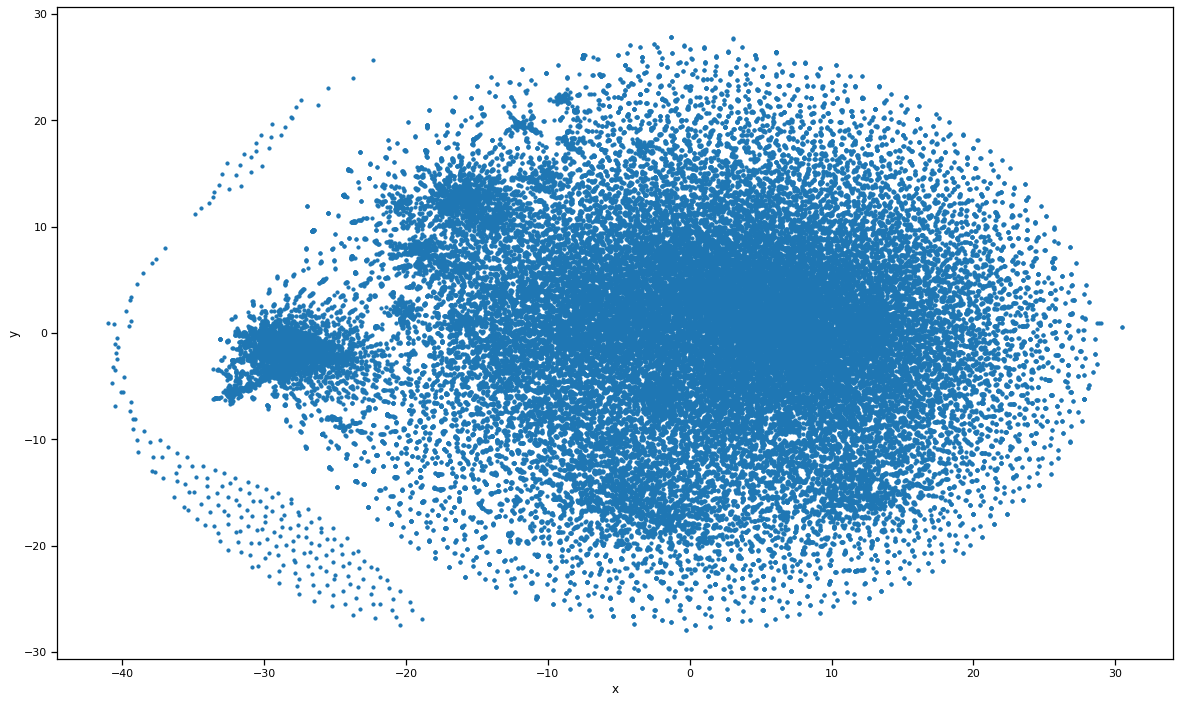

In [229]:
points.plot.scatter("x", "y", s=10, figsize=(20, 12))

A helper function has been defined above with the other methods.  You can navigate the 2-D plane to see how the model is associated words to eachother by configuring the X-bound and Y-bound axis limits.  There are some really interesting areas in the plot.

(*CAUTION: SOME REGIONS CONTAIN EXPLICIT WORDS NOT SUITABLE FOR THOSE UNDER 18 YEARS OF AGE*)

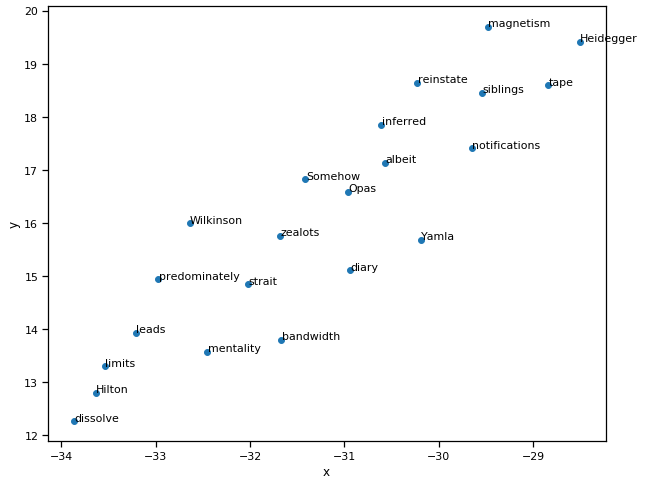

In [228]:
plotTsneRegion(points, x_bounds=(-34, -28), y_bounds=(10, 20))

# Step 6 - Determine Optimal CountVectorizer and Statistical Language Model Parameters via Pipeline and GridSearchCV

Even though this step wasn't really included in the final model workflow, it was included when attempting to integrate the CNN model into an sklearn Pipeline sequence using CountVectorizer(), TfidfTransformer() and then the customized CNN class object.  This didn't pan out, and didn't have time to finish troubleshooting this, so thus the decision to move forward with using Keras built-in tokenizer and sequence padder.  I just thought it would be good to share how I went about obtaining the optimal Count Vectorizer and Logistic Regression model parameters as a comparison, through an iterative process.  In the end I actually used a Pipeline similar to this one below on a handful of models, each with varying results.

Overall there was a total of 6 sklearn models that used this Pipeline structure and experimenting with parameters to hyperparameter tuning performance by tweaking the count vectorizer, or the tfidf transformer, or the model parameters itself.  The 6 models trained and hypter tuned were: 1) LogisticRegression(), 2) MultinomialNB(), 3) KNN(), 4) SGDClassifier(), 5) RandomForestClassifier, and 6) PassiveAggressiveClassifier().  Only the LogisticRegression() model was included here in this notebook for example sake.  The final ROC AUC performance of those models can be seen in the PPTX slide deck for this project.

First need to build a basic pipeline without any parameters defined (except the normalization for tfidf to match strawman.  

In [341]:
logPipe = Pipeline([
    ('vect', CountVectorizer(tokenizer=customTokenizer)),
    ('tfidf', TfidfTransformer(norm = 'l2')),
    ('logreg', LogisticRegression()),
])

This is the parameter grid that was initially defined to explore best parameters for CountVectorizer, TfidfTransformer and LogisticRegression.  However, this grid configuration ran for over 24 hours and I had to comment out many of the parameters.  Finall those that are not commented below were used in training the Pipeline to find the optimal model settings.

In [342]:
parameters = {
    'vect__max_features': (5000, 10000, 15000),
    'vect__analyzer': ['word'], # ['word', 'char', 'char_wb'],
    'vect__ngram_range': ((1,2), (1,3), (1,4), (1,5), (2,3)),
#     'vect__tokenizer': (None, customTokenizer),
#     'vect__min_df': [0.0, 1.0],
    'vect__max_df': (0.5, 0.75, 0.85),
    'vect__lowercase': (True, False),
#     'vect__stop_words': ('english', None),
#     'tfidf__smooth_idf': [True, False],
#     'tfidf__norm': ['l1', 'l2', None],
#     'clf__solver': ['sag', 'saga', 'liblinear'],
#     'clf__penalty': ['l2', 'none']
#     'logreg__verbose': [1]
    'logreg__penalty': ('l2', 'elasticnet')
}

Now we will setup the GridSearch object and fit the data to it.  This takes a really, really long time...

In [345]:
logregSearch = GridSearchCV(logPipe, param_grid=parameters, verbose=5, n_jobs=-1)

![title](v1_log_gridsearch_time.png)

### I had to kill the terminal because it froze up my CPU.  The first time I ran this in another notebook it took multiple hours, so I was not able to reduplicate the hyperparameter tuning output in this cleaned notebook for submission

In [ ]:
t1 = time.time()
gridClf = logregSearch.fit(X_train, y_train)
t2 = time.time()

Fitting 5 folds for each of 180 candidates, totalling 900 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


In [ ]:
# print(f'{(t2-t1)/60} minutes')

Here's an example of the results from hyperparameter tuning a RandomForestClassifer model with GridSearch matrix.

![title](rfc_hyptertuning_example.png)

This next cell won't run unless the logregSearch is successfully constructed, aka the GridSearchCV finishing finding the optimal paramters on the LogisticRegression() model, which literally takes many hours.

In [2]:
# getBestScoreParams(gridClf)

Now that we know what the optimal parameters are for the CountVectorizer (imaginging that these cells ran, which they did in the initial model exploration notebook), we will save them as a dictionary for future use.  In the original testing of all the different sklearn models, this parameter was passed into CountVectorizer() to fit and predict and evaluate performance of the different models.  As mentioned above, in the end, this wasn't used in the Keras workflow.

In [190]:
best_vect_params = {
    "ngram_range": ((1,2),(1,3)), 
    "max_features": 1000, 
    "analyzer": "word", 
    "stop_word": "english",
#     "lowercase": True, 
    "max_df": 0.5,
    "vectorizer": customTokenizer
}

# Step 7 - Train 1D CNN Model with Embedding Matrix Weights

Now that we have rebalanced the classes in the dataset, built our word embedding matrix, and all the other preprocessing steps are completed, it's time to actually build and train the CNN model.  A convolutional neural network (CNN) was chosen because, in comparison to recurrent neural networks (RNN), they are fast(er) and have proven to yield great results in text classification and sentiment analysis, areas of NLP which don't depend heavily on time series sequencing.  Hypothetically an RNN could have been had used we been trying to predict hate speech and personal attacks in comments by following a thread of comments from one person to the next, and observing the cummulative sequence of key phrases in comments as a series/sequence that would lead up to an attack being prevelant. CNN is good then at more simple text classification by observing prevelance of key phrases in comments labeled as an attack.

First we will establish the parameters to pass into the model architecture and for fitting.  These are important because they define the dimensionality of the model, expected sizes of inputs for the word embedded matrix and the prediction output.  It also establishes how many batches there are in each epoch.  I will not provide a detailed account of what all these parameters mean, but there is plenty of research and information available online to learn about these.

In [191]:
# vocab_size = len(keras_tokenizer.word_index) + 1
max_features = 10000
maxlen = 500
batch_size = 32
embedding_dims = 300
filters = 250
kernel_size = 3
hidden_dims = 250
epochs = 10

Now we will pad the sequences to a maximum length defined above, that way all the word vectors can be resized to fit the model.

In [192]:
X_train = sequence.pad_sequences(X_train, maxlen=maxlen)
X_test = sequence.pad_sequences(X_test, maxlen=maxlen)
y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

In [193]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(163638, 500)
(40910, 500)
(163638, 1)
(40910, 1)


In [194]:
# clear session inbetween runs/tests
K.clear_session()

Here is the model structure using the parameters defined above.  The model has an Embedding layer weighted with our word embedding matrix created from Word2Vec, a 1D convnet, global max pooling, and a hidden dense layer, with a dropout of 20% after each layer. Finally the binary classification is made with a sigmoidal function.

In [195]:
# https://keras.io/examples/imdb_cnn/
cnn_model = Sequential()
cnn_model.add(Embedding(input_dim=vocab_size, 
                        output_dim=embedding_dims, 
                        input_length=maxlen,
                        trainable=False,
                        weights=[embedding_matrix]))
cnn_model.add(Dropout(0.2))
cnn_model.add(Conv1D(filters, kernel_size, padding='valid', activation='relu', strides=1))
cnn_model.add(GlobalMaxPooling1D())
cnn_model.add(Dense(hidden_dims))
cnn_model.add(Dropout(0.2))
cnn_model.add(Activation('relu'))
cnn_model.add(Dense(1))
cnn_model.add(Activation('sigmoid'))

For binary classification tasks, the best loss to use in evaluating performance is binary cross entropy.  As you can see below, the model dimensions start out very large, and are compressed down through the model sequence.  A very limited set of the paramters are actually used in training the model.

In [196]:
cnn_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(cnn_model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 500, 300)          45513600  
_________________________________________________________________
dropout_1 (Dropout)          (None, 500, 300)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 498, 250)          225250    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 250)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 250)               62750     
_________________________________________________________________
dropout_2 (Dropout)          (None, 250)               0         
_________________________________________________________________
activation_1 (Activation)    (None, 250)              

Next, we will instantiate the RoCCallback class object defined above (conveniently provided by Keras team) in order to extract ROC AUC at each epoch running.  That way we can compare the model performance equivelantly to the other model types tested.

In [197]:
roc = RocCallback(training_data=(X_train, y_train),
                  validation_data=(X_test, y_test))

Now we actually fit the training data and evaluate it on the valudation/test set created, leveraging the RoCCallback class defined above.  The model runtime takes approx. two hours.  As you can see, the accuracy increases very slowly, but from the first epoch is already achieving .9326 with a loss of .1131.  Also the validation AUC on the first epoch is already .9905, which puts it very close to all the other statistical models tested.  Through each epoch, it performs better.

In [199]:
t1 = time.time()
history_matrix = cnn_model.fit(X_train, y_train, 
                   batch_size=batch_size,
                   callbacks=[roc],
                   epochs=epochs,
                   validation_data=(X_test, y_test))
t2 = time.time()

Train on 163638 samples, validate on 40910 samples
Epoch 1/10
163638/163638 [==============================] - 575s 4ms/step - loss: 0.1735 - accuracy: 0.9326 - val_loss: 0.1131 - val_accuracy: 0.9631
roc-auc_train: 0.9939 - roc-auc_val: 0.9905                                                                                                    
Epoch 2/10
163638/163638 [==============================] - 560s 3ms/step - loss: 0.1133 - accuracy: 0.9601 - val_loss: 0.0881 - val_accuracy: 0.9707
roc-auc_train: 0.997 - roc-auc_val: 0.9932                                                                                                    
Epoch 3/10
163638/163638 [==============================] - 560s 3ms/step - loss: 0.0890 - accuracy: 0.9689 - val_loss: 0.0760 - val_accuracy: 0.9762
roc-auc_train: 0.9981 - roc-auc_val: 0.9941                                                                                                    
Epoch 4/10
163638/163638 [==============================] - 560s 3ms

In [200]:
print(f'1D Convolutional Neural Network took {(t2-t1)/60} minutes to train')

1D Convolutional Neural Network took 124.22676516373953 minutes to train


# Step 8 - Evaluate Model Performance

The CNN has completed training, and we've been seeing the accuracy and AUC go up with each epoch, and the loss going down for the most part.  This could imply that we could train the model for more epochs to get better results.  But one way to see if this is an effective use of our time is to plot the accuracy/loss history of the fitted model, and determine how well fit the model is.  If there is a large divergence between validation accuracy and loss scores, then this likely implies there is overfitting going on.  Another way to visualize this is with a confucsion matrix, depicting the actual count of true positive, false positive, true negative and false negatives from the validation/test set.  Below I have also provided the ROC AUC curves, as well as Precision and Recall curves.  According to researching some different sources, Precision and Recall are good for datasets that aren't balanced while ROC AUC might be better for more balanced distributions.

Overall the model appears to be fitting well when implementing the embedding matrix, significantly less overfitting than before when it was achieving less than .95 validation accuracy, .40 loss, and .934 AUC.  With the embedding matrix, this improved to what is shown below, over .99 validation accuracy, .08 loss, and .995 AUC.  I'm very satisfied with these model results, especially since this is my first time using a CNN to solve a text classification problem, and figuring out how to use a Word2Vec word vector matrix to weight the CNN's embedding layer.

In [201]:
model_name = '1D CNN'

As stated a bit ago, the final model is achieving near **100% accuracy on the training set**, and **99% on the validation set** with very low loss score.

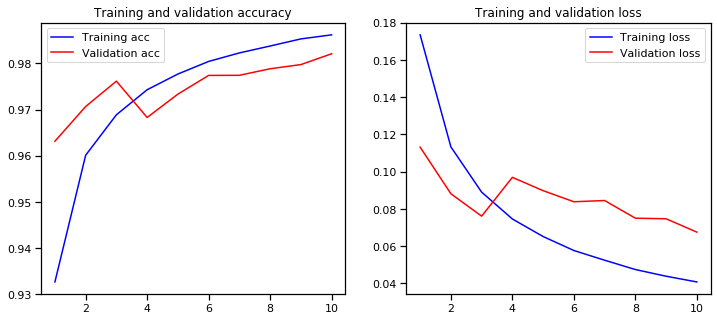

In [224]:
plotModelHistory(history_matrix)

In [205]:
y_preds = cnn_model.predict_proba(X_test)

In [206]:
precision, recall, thresholds = precision_recall_curve(y_test, y_preds)

In [323]:
f1 = f1_score(y_test, getBinaryPredFromProba(y_preds))

In [324]:
print(f'F1 Score Metric: {f1}')

F1 Score Metric: 0.9823452800154358


Also the precision and recall, and f1 score are all very close to 1, over **.982 f1 score**, compared to the baseline model that had a **.688 f1 score**.

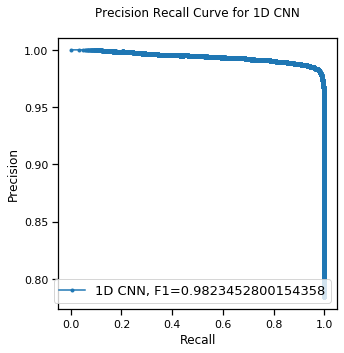

In [326]:
plotPrecisionRecallCurve(model_name, precision, recall, f1)

In [218]:
fpr, tpr, _ = roc_curve(y_test,  y_preds)
auc = roc_auc_score(y_test, y_preds)

Anothe way to visualize the AUC score is with an ROC curve, which shows the **AUC of .995**

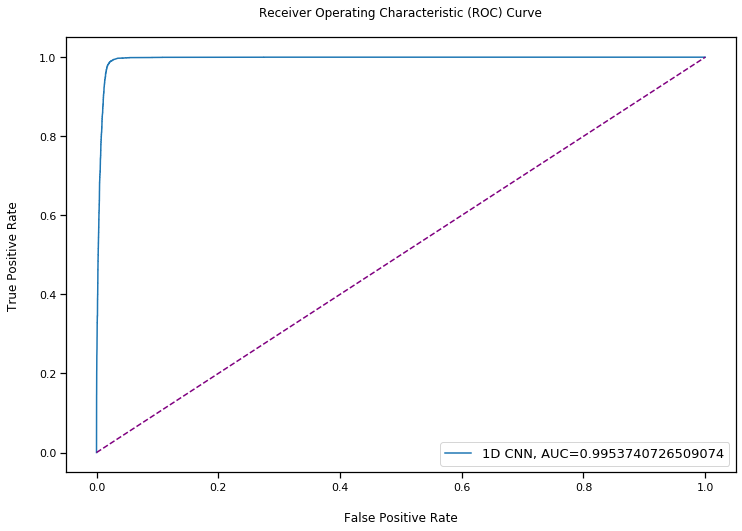

In [226]:
plotRocCurve(model_name, tpr, fpr, auc)

Lastly, we can visualize the precision/recall metric another way, by observing the counts of tp, fp, tn, and fn classes.  Overall from the validation set, there were **19813 true positives** and **20365 true negatives**, but only **642 false positives** (Type I Error), and **90 false negatives** (Type II error). 

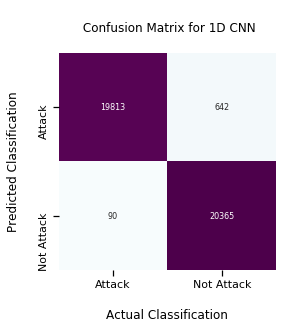

In [227]:
confusionMatrix(model_name, y_test, getBinaryPredFromProba(y_preds))

# Summary and Reflections

**Comparative performance of all models tested before and after hyperparameter tuning / optimization**

![title](final_model_score_comparison.png)

Even though only the CNN model was documented in this notebook, I want to share the performance of all the models tested and optimized through GridSearchCV, text preprocessing, or in the case of CNN word embedding matrix weighting on network layers.

**What was the most interesting thing you learned from doing the report?**

Creating Word2Vec model in order to obtain word embedding matrix and figuring out how to weight the Keras model with those weights, was probably the most challenging but rewarding part of the analysis.  It revealed the advances that deep learning has made compared to statistical language models in the are of text classification.  I really enjoyed learning how to build the word embedding matrix, and why it's important to training models using text data, instead of continuous or categorical data.  Text vectors are so sparse, the features quickly grow to thousands or even hundreds of thousands of features very quickly.  All this sparse data means the model training time exponentially grows, and might affect model accuracy.  Therefore something like Word2Vec from Gensim is a convenient way to reduce the dimensionality and make the matrix more dense and meaningful.  Second to that, it was interesting to see how TSNE can be used to visualize relationshisp between the word embeddings.

**What was the hardest thing to do?**

As stated above one of the most challenging things was to configure the the word embedding matrix in order to weight the CNN appropriately.  However with some troubleshooting, and reading up on Embedding layers, I was able to solve it and move on.  After this, I was attempting to build the CNN as a custom class object that would integrate with the sklearn Pipeline, that way I could still leverage the customized text preprocessing steps with the CountVectorizer and TfidfTransformer objects.  I was unsuccessful at integrating these two different frameworks, although there is evidence of it working in blogs and other resources online.  Due to time and resource contraints, I wasn't able to complete this integration, nor was I able to then use the GridSearch/RandomSearch on top of that pipeline.  Even if I had successfully got these working together, the issue might then have been time.  Using hyperparameter tuning on multiple models, especially a neural network can potentially take many days if not weeks.  Therefore, it seemed this solution was out of scope for this specific project. 